In [1]:
import sys
import os
from timeit import default_timer as timer
import requests
from IPython.display import display, Image, Markdown, Audio
import matplotlib.pyplot as plt
import time
from abc import ABC, abstractmethod
from together import Together
import numpy as np
import matplotlib.pyplot as plt
from openai import OpenAI

In [2]:
%load_ext dotenv
%dotenv

In [3]:
# create an interface for providers (abstract class)
class ProviderInterface(ABC):
    @abstractmethod
    def perform_inference(self, model, prompt):
        pass

    @abstractmethod
    def perform_inference_streaming(self, model, prompt):
        pass

    @abstractmethod
    def get_model_name(self, model):
        pass

## CloudFlare

In [23]:
class Cloudflare(ProviderInterface):
    def __init__(self):
        cloudflare_account_id = os.environ.get("CLOUDFLARE_ACCOUNT_ID")
        cloudflare_api_token = os.environ.get("CLOUDFLARE_AI_TOKEN")
        
        if not cloudflare_account_id or not cloudflare_api_token:
            raise ValueError("Cloudflare account ID and API token must be provided either as arguments or environment variables.")
        
        self.cloudflare_account_id = cloudflare_account_id
        self.cloudflare_api_token = cloudflare_api_token

        # model names 
        self.model_map = {
            "google-gemma-2b-it": "@cf/google/gemma-2b-it-lora",
            "mistral-7b-instruct-v0.1": "@cf/mistral/mistral-7b-instruct-v0.1",
            "meta-llama-3.1-70b-instruct": "@cf/meta/llama-3.1-70b-instruct",
            "meta-llama-3.1-8b-instruct":"@cf/meta/llama-3.1-8b-instruct"
        }
    
    def get_model_name(self, model):
        return self.model_map.get(model, None) # or model

    def perform_inference(self, model, prompt):
        model_id = self.get_model_name(model)
        if model_id is None:
            display(Markdown(f"Model {model} not available for provider {model_id}"))
        start_time = timer()
        response = requests.post(
            f"https://api.cloudflare.com/client/v4/accounts/{self.cloudflare_account_id}/ai/run/{model_id}",
            headers={"Authorization": f"Bearer {self.cloudflare_api_token}"},
            json={
            "messages": [
                # {"role": "system", "content": "Explain your answer step-by-step."},
                # {"role": "system", "content": "Answer only in Yes/No. 1 word answer ONLY."},
                {"role": "user", "content": prompt}
            ]
            }
        )
        elapsed = timer() - start_time
        inference = response.json()
        display(Markdown(inference["result"]["response"]))
        display(Markdown(f"#### _Generated in *{elapsed:.2f}* seconds_"))
        return elapsed

    def perform_inference_streaming(self, model, prompt):
        inter_token_latencies = []
        model_id = self.get_model_name(model)
        start_time = time.perf_counter()

        response = requests.post(
            f"https://api.cloudflare.com/client/v4/accounts/{self.cloudflare_account_id}/ai/run/{model_id}",
            headers={"Authorization": f"Bearer {self.cloudflare_api_token}",     'Content-Type': 'application/json' },
            json={
            "stream" : True,
            "messages": [
                # {"role": "system", "content": "You are a friendly assistant"},
                {"role": "user", "content": prompt}
            ]
            },
            stream=True
        )

        first_token_time = None
        for line in response.iter_lines():
            if line:
                if first_token_time is None:
                    first_token_time = time.perf_counter()
                    TTFT = first_token_time - start_time
                    prev_token_time = first_token_time
                    display(Markdown(f"##### Time to First Token (TTFT): {TTFT:.4f} seconds\n"))

                line_str = line.decode('utf-8').strip()

                # Check if the stream is done
                if line_str == "data: [DONE]":
                    end_time = time.perf_counter()
                    total_time = end_time - start_time
                    display(Markdown(f"##### Total Response Time: {total_time:.4f} seconds"))
                    break
                else:
                    time_to_next_token = time.perf_counter()
                    inter_token_latency = time_to_next_token - prev_token_time
                    prev_token_time = time_to_next_token

                    inter_token_latencies.append(inter_token_latency)
                    print(line_str[19:].split('"')[0], end='')
                    
        display(Markdown(f'##### Number of output tokens/chunks: {len(inter_token_latencies) + 1}'))
        return {'TTFT': TTFT, 'Total Time': total_time, 'Time between Tokens': inter_token_latencies}
    

In [25]:
provider = Cloudflare()

model = "google-gemma-2b-it"
prompt = "What are some fun things to do in New York? Give me 1 short example."

latency = provider.perform_inference(model, prompt)

Sure! Here's a fun idea: Take a helicopter tour over Manhattan and get breathtaking panoramic views of the city.

#### _Generated in *1.48* seconds_

In [7]:
provider = Cloudflare()

model = "google-gemma-2b-it"
prompt = 'Translate "Excuse me, which way to the restroom?" from "English" to "Spanish"'
metrics = provider.perform_inference_streaming(model, prompt)


##### Time to First Token (TTFT): 1.5221 seconds


Sure. The translation is \Excuse me, which way to the restroom?\ in Spanish.

##### Total Response Time: 2.0094 seconds

##### Number of output tokens/chunks: 20

In [8]:
metrics

{'TTFT': 1.522106999999778,
 'Total Time': 2.0093581999999515,
 'Time between Tokens': [0.0011939999999412976,
  0.01654000000007727,
  0.030403000000205793,
  0.027784299999893847,
  0.025727199999892036,
  0.026330700000016805,
  0.02737280000019382,
  0.028965799999696173,
  0.02663280000024315,
  0.0270037999998749,
  0.041000700000040524,
  0.01714559999982157,
  0.02885569999989457,
  0.020043600000008155,
  0.02645520000032775,
  0.03620369999998729,
  0.032417599999917,
  0.01960289999988163,
  0.026897199999893928]}

## TogetherAI

In [26]:
class TogetherAI(ProviderInterface):
    def __init__(self):
        together_api = os.environ["TOGETHER_AI_API"]
        
        if not together_api:
            raise ValueError("Together AI API token must be provided as environment variables.")
        
        self.client = Together(api_key=together_api)

        # model names 
        self.model_map = {
            "google-gemma-2b-it": "google/gemma-2b-it",
            "mistral-7b-instruct-v0.1": "mistralai/Mistral-7B-Instruct-v0.1",
            "meta-llama-3.1-70b-instruct": "meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo",
            "meta-llama-3.1-8b-instruct":"meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo"
        }
    
    def get_model_name(self, model):
        return self.model_map.get(model, None) # or model
    
    def perform_inference(self, model, prompt):
        model_id = self.get_model_name(model)
        if model_id is None:
            display(Markdown(f"Model {model} not available for provider {model_id}"))
        start = timer()
        response = self.client.chat.completions.create(
            model=model_id,
            messages=[{"role": "user", "content": prompt}],
        )
        elapsed = timer() - start

        display(Markdown(response.choices[0].message.content))
        display(Markdown(f"##### _Generated in *{elapsed:.2f}* seconds_"))

        return elapsed

    def perform_inference_streaming(self, model, prompt):    
        model_id = self.get_model_name(model)    
        if model_id is None:
            display(Markdown(f"Model {model} not available for provider {model_id}"))    
        first_token_time = None
        inter_token_latencies = []

        start = timer()

        response = self.client.chat.completions.create(
            model=model_id,
            messages=[{"role": "user", "content": prompt}],
            stream=True
        )

        for chunk in response:
            if first_token_time is None:
                # print(chunk)
                first_token_time = timer()
                TTFT = first_token_time - start
                prev_token_time = first_token_time
                display(Markdown(f"##### Time to First Token (TTFT): {TTFT:.4f} seconds\n"))
            
            if chunk.choices[0].finish_reason :
                elapsed = timer() - start
                display(Markdown(f"##### Total Response Time: {elapsed:.4f} seconds"))
                break
                                            
            time_to_next_token = timer()
            inter_token_latency = time_to_next_token - prev_token_time
            prev_token_time = time_to_next_token

            inter_token_latencies.append(inter_token_latency)
            
            print(chunk.choices[0].delta.content or "", end="", flush=True)
        
        display(Markdown(f'##### Number of output tokens/chunks: {len(inter_token_latencies) + 1}'))

        return {'TTFT': TTFT, 'Total Time': elapsed, 'Time between Tokens': inter_token_latencies}

In [10]:
provider = TogetherAI()

model = "mistral-7b-instruct-v0.1"
prompt = "What are some fun things to do in New York? Give me 1 short example."

latency = provider.perform_inference(model, prompt)

 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### _Generated in *1.03* seconds_

In [11]:
metrics = provider.perform_inference_streaming(model, prompt)

##### Time to First Token (TTFT): 0.9500 seconds


 One fun thing to do in New York is to visit the High Line, an elevated public park built on a former railroad track. You can take a stroll along the park's length, enjoying the beautiful views of the city and the unique plants and artwork installed along the way.

##### Total Response Time: 1.4183 seconds

##### Number of output tokens/chunks: 60

## PerplexityAI

In [4]:

class PerplexityAI(ProviderInterface):
    def __init__(self):
        perplexity_api = os.environ.get("PERPLEXITY_AI_API")
        
        if not perplexity_api:
            raise ValueError("Perplexity AI API token must be provided as an environment variable.")
        
        self.client = OpenAI(api_key=perplexity_api, base_url="https://api.perplexity.ai")

        # model names
        self.model_map = {
            "meta-llama-3.1-70b-instruct": "llama-3.1-70b-instruct", #70b
            "meta-llama-3.1-8b-instruct": "llama-3.1-8b-instruct",   #8b
            "meta-llama-3.1-sonar-405B":"llama-3.1-sonar-huge-128k-online" #405B
        }
    
    def get_model_name(self, model):
        return self.model_map.get(model, None)  # or fallback to default model
    
    def perform_inference(self, model, prompt):
        model_id = self.get_model_name(model)
        if model_id is None:
            display(Markdown(f"Model {model} not available for provider {model_id}"))
            return
        
        start = timer()
        response = self.client.chat.completions.create(
            model=model_id,
            messages=[{"role": "user", "content": prompt}],
        )
        elapsed = timer() - start

        display(Markdown(response.choices[0].message.content))
        display(Markdown(f"##### _Generated in *{elapsed:.2f}* seconds_"))

        return elapsed

    def perform_inference_streaming(self, model, prompt):
        model_id = self.get_model_name(model)
        if model_id is None:
            display(Markdown(f"Model {model} not available for provider {model_id}"))
            return
        
        first_token_time = None
        inter_token_latencies = []

        start = timer()

        response = self.client.chat.completions.create(
            model=model_id,
            messages=[{"role": "user", "content": prompt}],
            stream=True
        )

        for chunk in response:
            if first_token_time is None:
                first_token_time = timer()
                TTFT = first_token_time - start
                prev_token_time = first_token_time
                display(Markdown(f"##### Time to First Token (TTFT): {TTFT:.4f} seconds\n"))
            
            if chunk.choices[0].finish_reason:
                elapsed = timer() - start
                display(Markdown(f"##### Total Response Time: {elapsed:.4f} seconds"))
                break

            time_to_next_token = timer()
            inter_token_latency = time_to_next_token - prev_token_time
            prev_token_time = time_to_next_token

            inter_token_latencies.append(inter_token_latency)
            print(chunk.choices[0].delta.content or "", end="", flush=True)
        
        display(Markdown(f'##### Number of output tokens/chunks: {len(inter_token_latencies) + 1}'))

        return {'TTFT': TTFT, 'Total Time': elapsed, 'Time between Tokens': inter_token_latencies}


In [14]:
provider = PerplexityAI()

model = "meta-llama-3.1-8b-instruct"
prompt = "What are some fun things to do in New York? Give me 1 short example."

latency = provider.perform_inference(model, prompt)

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some photos. It's a free and exhilarating experience that's a quintessential NYC experience

##### _Generated in *0.78* seconds_

In [15]:
provider = PerplexityAI()

model = "meta-llama-3.1-8b-instruct"
prompt = 'Translate "Excuse me, which way to the restroom?" from "English" to "Spanish"'
metrics = provider.perform_inference_streaming(model, prompt)

##### Time to First Token (TTFT): 0.5236 seconds


¿Puedo ayudarte? La traducción de "Excuse me, which way to the restroom?" al español es:

"¿Puedo ayudarte? ¿Dónde está el baño?"

##### Total Response Time: 0.5773 seconds

##### Number of output tokens/chunks: 23

In [16]:
metrics

{'TTFT': 0.5236230999998952,
 'Total Time': 0.5773279000000002,
 'Time between Tokens': [0.0013134999999238062,
  0.000784000000294327,
  0.0012447999997675652,
  0.0008542999999008316,
  0.0005944000004092231,
  0.0012413999997988867,
  0.0010636000001795765,
  0.0008414999997512496,
  0.0009275000002162415,
  0.0007015999999566702,
  0.0006076999998185784,
  0.0008925000001909211,
  0.0008407000000261178,
  0.0008794000000307278,
  0.0022890000000188593,
  0.001113099999656697,
  0.000702499999988504,
  0.0010492000001249835,
  0.031717700000172044,
  0.0008743999997022911,
  0.0009992000000238477,
  0.0010420000003250607]}

## Benchmark Class

In [5]:
class Benchmark:
    def __init__(self, providers, num_requests, models, prompt, streaming=False):
        self.providers = providers
        self.num_requests = num_requests
        self.models = models
        self.prompt = prompt
        self.streaming = streaming
        self.response_times = {}
        self.timetofirsttoken = {}
        self.totaltime = {}
        self.timebetweentokens = {}
        self.timebetweentokens_median = {}
        self.timebetweentokens_p95 = {}


    def plot_metrics(self, metrics_list):
        plt.figure(figsize=(8, 8))
        num_models=len(self.models)*len(self.providers)
        for provider, models in metrics_list.items():
            for model, latencies in models.items():
                # Convert to milliseconds and sort for CDF
                latencies_sorted = np.sort(latencies) * 1000
                cdf = np.arange(1, len(latencies_sorted) + 1) / len(latencies_sorted)
                
                # Plot each model's CDF
                plt.plot(latencies_sorted, cdf, marker='o', linestyle='-', markersize=5, label=f'{provider} - {model}')

        # Add title, labels, and grid
        plt.title(f'Latency Comparison of {num_models} Models')
        plt.xlabel('Latency (ms)', fontsize=12)
        plt.ylabel('Portion of requests', fontsize=12)
        plt.grid(True)

        # Add legend
        plt.legend(loc='lower right')

        # Show the plot
        plt.tight_layout()
        plt.show() 
    
    def run(self):
        for provider in self.providers:
            provider_name = provider.__class__.__name__

            if provider_name not in self.response_times:
                self.response_times[provider_name] = {}
                self.timetofirsttoken[provider_name] = {}
                self.totaltime[provider_name] = {}
                self.timebetweentokens[provider_name] = {}
                self.timebetweentokens_median[provider_name] = {}
                self.timebetweentokens_p95[provider_name] = {}


            display(Markdown(f"##### {provider_name}"))
            for model in self.models:
                display(Markdown(f"##### Model: {model}\n ##### Prompt: {prompt}"))
                self.response_times[provider_name][model] = []
                self.timetofirsttoken[provider_name][model] = []
                self.totaltime[provider_name][model] = []
                self.timebetweentokens[provider_name][model] = []
                self.timebetweentokens_median[provider_name][model] = []
                self.timebetweentokens_p95[provider_name][model] = []
                
                for _ in range(self.num_requests):
                    display(Markdown(f'Request {_}'))
                    if self.streaming:
                        metrics = provider.perform_inference_streaming(model, prompt)
                        self.timetofirsttoken[provider_name][model].append(metrics['TTFT'])
                        self.totaltime[provider_name][model].append(metrics['Total Time'])
                        self.timebetweentokens[provider_name][model].extend(metrics['Time between Tokens'])
                        
                        median = np.percentile(metrics['Time between Tokens'], 50)
                        p95 = np.percentile(metrics['Time between Tokens'], 95)
                        p99 = np.percentile(metrics['Time between Tokens'], 99)
                        
                        self.timebetweentokens_median[provider_name][model].append(median)
                        self.timebetweentokens_p95[provider_name][model].append(p95)
                    else:
                        result = provider.perform_inference(model, prompt)
                        self.response_times[provider_name][model].append(result)           

## Benchmarking between 3 providers

### Meta-llama-8b benchmark

##### TogetherAI

##### Model: meta-llama-3.1-8b-instruct
 ##### Prompt: What are some fun things to do in New York? Give me 1 short example.

Request 0

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including the iconic Empire State Building and Central Park.

##### _Generated in *2.26* seconds_

Request 1

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *1.26* seconds_

Request 2

One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### _Generated in *2.01* seconds_

Request 3

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *1.41* seconds_

Request 4

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *1.59* seconds_

Request 5

One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### _Generated in *1.07* seconds_

Request 6

One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### _Generated in *1.33* seconds_

Request 7

One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### _Generated in *1.98* seconds_

Request 8

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *1.00* seconds_

Request 9

One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### _Generated in *1.50* seconds_

Request 10

One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### _Generated in *1.47* seconds_

Request 11

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *1.48* seconds_

Request 12

One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### _Generated in *1.30* seconds_

Request 13

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *1.07* seconds_

Request 14

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *1.25* seconds_

Request 15

One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### _Generated in *1.66* seconds_

Request 16

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *1.20* seconds_

Request 17

One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### _Generated in *1.26* seconds_

Request 18

One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### _Generated in *1.50* seconds_

Request 19

One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### _Generated in *1.12* seconds_

Request 20

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *1.08* seconds_

Request 21

One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### _Generated in *2.09* seconds_

Request 22

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including the iconic Empire State Building and Central Park.

##### _Generated in *1.48* seconds_

Request 23

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *1.41* seconds_

Request 24

One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### _Generated in *1.17* seconds_

Request 25

One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### _Generated in *2.24* seconds_

Request 26

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *0.84* seconds_

Request 27

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including the iconic Empire State Building and Central Park.

##### _Generated in *1.03* seconds_

Request 28

One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### _Generated in *2.43* seconds_

Request 29

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *1.16* seconds_

Request 30

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *1.23* seconds_

Request 31

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *0.99* seconds_

Request 32

One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### _Generated in *1.38* seconds_

Request 33

One fun thing to do in New York is visiting the Top of the Rock Observation Deck. It offers breathtaking views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *1.52* seconds_

Request 34

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *1.32* seconds_

Request 35

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *1.50* seconds_

Request 36

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *1.06* seconds_

Request 37

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *1.11* seconds_

Request 38

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including the iconic Empire State Building and Central Park.

##### _Generated in *1.17* seconds_

Request 39

One fun thing to do in New York is visiting the Top of the Rock Observation Deck. It offers breathtaking views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *1.01* seconds_

Request 40

One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### _Generated in *2.48* seconds_

Request 41

One fun thing to do in New York is visiting the Top of the Rock Observation Deck. It offers breathtaking views of the Manhattan skyline and iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *1.07* seconds_

Request 42

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *1.02* seconds_

Request 43

One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### _Generated in *1.64* seconds_

Request 44

One fun thing to do in New York is visiting the Top of the Rock Observation Deck. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *1.03* seconds_

Request 45

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *1.30* seconds_

Request 46

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *0.82* seconds_

Request 47

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *1.68* seconds_

Request 48

One fun thing to do in New York is visiting the Top of the Rock Observation Deck. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *0.73* seconds_

Request 49

One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### _Generated in *1.24* seconds_

Request 50

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *1.20* seconds_

Request 51

One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### _Generated in *1.18* seconds_

Request 52

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *1.38* seconds_

Request 53

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *1.18* seconds_

Request 54

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including the iconic Empire State Building and Central Park.

##### _Generated in *1.51* seconds_

Request 55

One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### _Generated in *1.30* seconds_

Request 56

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including the iconic Empire State Building and Central Park.

##### _Generated in *1.07* seconds_

Request 57

One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### _Generated in *1.53* seconds_

Request 58

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *1.15* seconds_

Request 59

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including the iconic Empire State Building and Central Park.

##### _Generated in *1.18* seconds_

Request 60

One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### _Generated in *1.53* seconds_

Request 61

One fun thing to do in New York is visiting the Top of the Rock Observation Deck. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *1.17* seconds_

Request 62

One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### _Generated in *1.68* seconds_

Request 63

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including the iconic Empire State Building and Central Park.

##### _Generated in *1.31* seconds_

Request 64

One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### _Generated in *1.91* seconds_

Request 65

One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### _Generated in *1.10* seconds_

Request 66

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *1.27* seconds_

Request 67

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *0.94* seconds_

Request 68

One fun thing to do in New York is visiting the Top of the Rock Observation Deck. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *1.13* seconds_

Request 69

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including the iconic Empire State Building and Central Park.

##### _Generated in *1.04* seconds_

Request 70

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *1.32* seconds_

Request 71

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *1.19* seconds_

Request 72

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including the iconic Empire State Building and Central Park.

##### _Generated in *1.11* seconds_

Request 73

One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### _Generated in *2.05* seconds_

Request 74

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *1.51* seconds_

Request 75

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *1.09* seconds_

Request 76

One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### _Generated in *1.04* seconds_

Request 77

One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, or take a leisurely boat ride on the lake.

##### _Generated in *1.23* seconds_

Request 78

One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### _Generated in *1.17* seconds_

Request 79

One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### _Generated in *1.36* seconds_

Request 80

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including the iconic Empire State Building and Central Park.

##### _Generated in *1.04* seconds_

Request 81

One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### _Generated in *1.47* seconds_

Request 82

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *1.00* seconds_

Request 83

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *1.14* seconds_

Request 84

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *0.97* seconds_

Request 85

One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### _Generated in *1.65* seconds_

Request 86

One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### _Generated in *1.45* seconds_

Request 87

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *1.10* seconds_

Request 88

One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### _Generated in *1.62* seconds_

Request 89

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *0.96* seconds_

Request 90

One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### _Generated in *1.16* seconds_

Request 91

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *1.23* seconds_

Request 92

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *1.53* seconds_

Request 93

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including the iconic Empire State Building and Central Park.

##### _Generated in *1.43* seconds_

Request 94

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *0.97* seconds_

Request 95

One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a variety of activities, including walking, jogging, boating, and picnicking. You can also visit famous landmarks like the Bethesda Fountain, the Loeb Boathouse, and the Central Park Zoo.

##### _Generated in *1.69* seconds_

Request 96

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *1.12* seconds_

Request 97

One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### _Generated in *1.67* seconds_

Request 98

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *1.23* seconds_

Request 99

One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### _Generated in *1.26* seconds_

##### Cloudflare

##### Model: meta-llama-3.1-8b-instruct
 ##### Prompt: What are some fun things to do in New York? Give me 1 short example.

Request 0

The city that never sleeps! Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: This iconic bridge offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can walk or bike across, taking in the sights and sounds of the city while getting some exercise. It's a thrilling experience that's free and accessible 24/7!

Would you like more ideas?

#### _Generated in *6.92* seconds_

Request 1

The city that never sleeps! New York has endless options for entertainment, art, history, and culture. Here's a fun one:

**Explore the High Line**

The High Line is an elevated park built on an old rail line, featuring stunning views of the Hudson River, public art installations, and gardens. It's a unique and tranquil oasis in the midst of Manhattan's bustling streets. Take a leisurely stroll, grab a snack or coffee from one of the many vendors, and enjoy the sights and sounds of this iconic NY landmark.

Would you like me to suggest more ideas or help with something specific?

#### _Generated in *10.13* seconds_

Request 2

The possibilities are endless in the city that never sleeps! Here's a short example:

**Take a Stroll through Central Park at Night**

Imagine walking through the lush greenery and scenic landscapes of Central Park after the sun goes down. The park transforms into a magical wonderland with twinkling lights, street performers, and lively street food vendors. You can rent a bike, take a horse-drawn carriage ride, or simply enjoy a peaceful walk along the winding paths. It's a quintessential New York experience that's sure to leave you in awe of the city's energy and beauty.

#### _Generated in *9.87* seconds_

Request 3

The city that never sleeps! Here's a short and fun example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge for spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can start at Brooklyn Bridge Park and end at City Hall in Manhattan. Along the way, you'll see street performers, vendors, and stunning cityscapes. It's a quintessential NYC experience!

How's that for a taste of the Big Apple?

#### _Generated in *8.87* seconds_

Request 4

The city that never sleeps! New York City has endless options for entertainment, culture, and adventure. Here's a short example of one fun thing to do in New York:

**Take a stroll through Central Park**

Central Park is an 843-acre green oasis in the middle of Manhattan. Take a leisurely walk through the park and enjoy the scenic beauty, rent a bike or a swan-shaped boat, or people-watch at the Bethesda Fountain. In the summer, catch a performance at the park's many outdoor spaces, like the Central Park SummerStage concert series or Shakespeare in the Park.

(This is just a taste, but there are many more adventures to be had in NYC!)

#### _Generated in *11.10* seconds_

Request 5

Here's a fun idea:

**Take a sunset stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, taking in the stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. You'll feel the energy of the city as you walk alongside pedestrians, joggers, and cyclists, and you might even catch a glimpse of street performers or artists along the way. It's a unique and unforgettable experience that captures the spirit of New York City.

#### _Generated in *7.53* seconds_

Request 6

The city that never sleeps! Here's a short example:

**Take a stroll through Central Park**: Walk through the iconic park, visit iconic landmarks like the Bethesda Fountain and Loeb Boathouse, and enjoy a leisurely stroll through the scenic paths, gardens, and lakes. You might even spot a Broadway audition or a celebrity or two!

#### _Generated in *5.83* seconds_

Request 7

The city that never sleeps! Here's one fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: This iconic bridge offers breathtaking views of the Manhattan skyline, the East River, and the Statue of Liberty. You can walk, bike, or take a leisurely stroll across the bridge, which connects Brooklyn to Manhattan. It's a great way to take in the sights and sounds of the city while getting some exercise.

How's that? Would you like more ideas?

#### _Generated in *7.45* seconds_

Request 8

The city that never sleeps!

Here's a short example of a fun thing to do in New York:

**Take a stroll through Central Park**: This 843-acre green oasis in the middle of Manhattan offers a serene escape from the hustle and bustle of city life. Take a leisurely walk through the park, visit famous landmarks like the Bethesda Fountain and Loeb Boathouse, and rent a horse-drawn carriage for a romantic ride. You can also visit the Central Park Zoo and Conservatory Garden, or rent a bike and ride through the park.

#### _Generated in *10.14* seconds_

Request 9

The city that never sleeps! Here's a short and fun idea:

**Take a sunset stroll across the Brooklyn Bridge**

Start at the iconic Brooklyn Bridge in Lower Manhattan and walk across the pedestrian path to Brooklyn. Enjoy the stunning views of the Manhattan skyline, the East River, and the city's vibrant streets. The walk is about 1.1 miles each way and takes about 30-45 minutes. You can stop at DUMBO (Down Under the Manhattan Bridge Overpass) for breathtaking views of the Manhattan skyline and some great food options for dinner or snacks. It's a great way to experience the energy and beauty of New York City!

#### _Generated in *9.76* seconds_

Request 10

The city that never sleeps! Here's a fun activity to do in New York:

**Take a stroll across the Brooklyn Bridge**

Catch the beautiful views of the Manhattan skyline, the East River, and Brooklyn as you walk across this iconic bridge. The pedestrian walkway offers stunning vistas, street performers, and photo opportunities galore. Plus, you'll feel like a true New Yorker, walking where millions of commuters and tourists do every day.

#### _Generated in *7.46* seconds_

Request 11

The city that never sleeps! Here's a short example of a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. It's a great way to experience the city's energy and take in the sights and sounds of the bustling metropolis.

#### _Generated in *5.92* seconds_

Request 12

The city that never sleeps! Here's a fun thing to do in New York:

**Take a stroll through Central Park!**
Walk through the 843 acres of lush greenery, visit the Bethesda Fountain, Loeb Boathouse, and Strawberry Fields, and all the other iconic spots. You might even catch a free concert or movie screening in the summer!

There are countless more fun things to do in New York, such as visiting the Statue of Liberty, catching a Broadway show, exploring the Met Museum, or trying a slice of classic NYC pizza.

#### _Generated in *8.20* seconds_

Request 13

The city that never sleeps! Here's a fun activity to get you started:

**Visit the Top of the Rock Observation Deck**

Take a thrilling elevator ride to the 70th floor of the Rockefeller Center for breathtaking 360-degree views of the city. On a clear day, you can see the Statue of Liberty, Central Park, and iconic skyscrapers like the Empire State Building and One World Trade Center. It's an unforgettable experience, especially at sunset or during the holiday season when the city lights are extra magical!

#### _Generated in *7.86* seconds_

Request 14

The city that never sleeps! New York has endless options for entertainment, food, and culture. Here's a fun example:

**Take a stroll through Central Park**

Walk through the lush green oasis in the heart of Manhattan, passing by famous landmarks like the Loeb Boathouse, Bethesda Fountain, and Bethesda Terace. You can also rent a bike, play a game of chess in the Chess and Checkers House, or simply sit on a bench and people-watch. With over 843 acres to explore, you'll find something new and exciting at every turn!

Would you like more ideas?

#### _Generated in *10.03* seconds_

Request 15

The city that never sleeps! There are countless fun things to do in New York! Here's a short example:

**Take a sunset cruise around Manhattan**

Imagine gliding through the Hudson River, taking in the breathtaking views of the Manhattan skyline as the sun sets behind it. You'll pass by iconic landmarks like the Statue of Liberty, the Empire State Building, and the Brooklyn Bridge. You might even get to see the sailboats, yachts, or ferries docked along the way. Many companies offer sunset cruises, often with food, drinks, and live music. It's a spectacular way to experience the energy and beauty of New York City!

#### _Generated in *10.40* seconds_

Request 16

The city that never sleeps! Here's a fun example:

**Take a stroll through Central Park at night**

Imagine walking through a lush green oasis in the middle of Manhattan, surrounded by iconic skyscrapers and famous landmarks. Central Park at night is a magical experience, with the park's beautiful lights and fountains illuminated, and the city's vibrant energy all around. You can rent a GPS-guided bike or a horse-drawn carriage, or simply take a leisurely walk to enjoy the sights and sounds of the park. It's a quintessential NYC experience that's sure to leave you in awe!

#### _Generated in *9.80* seconds_

Request 17

The city that never sleeps! Here's a fun one:

**Take a sunset stroll across the Brooklyn Bridge**

Imagine walking on the historic Brooklyn Bridge, taking in the stunning views of the Manhattan skyline, the East River, and the Statue of Liberty while the sun sets over the Hudson River. You can walk across the bridge in either direction, but the views are especially breathtaking as the sun sets over the city. It's a unique perspective on one of the world's most iconic cities!

#### _Generated in *7.86* seconds_

Request 18

The city that never sleeps! Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**

Walk across this iconic 1.1-mile suspension bridge that connects Brooklyn to Manhattan, offering spectacular views of the Manhattan skyline, the East River, and Governor's Island. On a clear day, you can even see the Statue of Liberty! It's a romantic, thrilling, and Instagram-worthy experience that's free and accessible.

Would you like more ideas?

#### _Generated in *8.51* seconds_

Request 19

The city that never sleeps! Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge at sunset**: Walk across this iconic suspension bridge that connects Brooklyn to Manhattan and enjoy breathtaking views of the Manhattan skyline, the East River, and the Statue of Liberty while watching the sunset. It's a quintessential NYC experience!

#### _Generated in *5.77* seconds_

Request 20

The city that never sleeps! Here's one fun thing to do in New York:

**Take a stroll through Central Park at night**: As the sun sets, Central Park transforms into a magical wonderland. The lights and landmarks of the park and surrounding Manhattan lights up the night sky, creating a romantic and enchanting atmosphere. You can walk through the park, taking in the sights and sounds of the city, and enjoy the many public art installations, fountains, and walking paths.

Would you like more ideas?

#### _Generated in *8.63* seconds_

Request 21

The city that never sleeps! Here's a fun one:

**Take a stroll across the Brooklyn Bridge**

This iconic bridge offers breathtaking views of the Manhattan skyline, the East River, and the Statue of Liberty. You can walk or bike across the bridge, and take in the vibrant street performers and vendors along the way. It's a great way to experience the city's energy and history in one exciting adventure!

(And if you want more ideas, I'd be happy to give you plenty!)

#### _Generated in *7.70* seconds_

Request 22

The city that never sleeps! Here's a fun example:

**Attend a Broadway Show**: New York City is famous for its theater scene, and there's no better way to experience it than watching a live musical or play on Broadway! From classic hits like The Lion King to modern hits like Hamilton, there's something for every taste and budget. You can even take a guided tour of a theater or attend a matinee or night show to catch your favorite performance.

Are you looking for more ideas? I'd be happy to give you a few more!

#### _Generated in *8.52* seconds_

Request 23

The city that never sleeps! Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. The bridge is pedestrian and cyclist friendly, making it an accessible and exciting experience for all. You can stop at the bridge's many observation decks, including the Brooklyn Bridge Park, to take in the breathtaking views of the city.

#### _Generated in *7.26* seconds_

Request 24

The city that never sleeps! There are countless fun things to do in New York City! Here's a short example:

**Take a stroll across the Brooklyn Bridge at sunset:** Stand atop the iconic Brooklyn Bridge and enjoy breathtaking views of the Manhattan skyline, the East River, and the Statue of Liberty. Catch the sunset over the city, and snap some amazing photos to commemorate the moment. It's a free and unforgettable experience!

Would you like more ideas?

#### _Generated in *7.44* seconds_

Request 25

The city that never sleeps! Here's a fun example:

**Take a stroll across the Brooklyn Bridge**

Walking across the iconic Brooklyn Bridge offers breathtaking views of the Manhattan skyline, the East River, and the Statue of Liberty. The pedestrian walkway is a 1.1-mile promenade that's free and accessible 24/7. Enjoy the street performers, historic architecture, and stunning vistas while walking from Brooklyn to Manhattan!

Want to know more fun activities in NYC?

#### _Generated in *6.89* seconds_

Request 26

The city that never sleeps! Here's a classic example of a fun thing to do in New York:

**Take a stroll through Central Park!**

Walk through the beautiful, 843-acre park, exploring its many walking paths, gardens, lakes, and landmarks, such as the Bethesda Fountain, Loeb Boathouse, and the Conservatory Garden. You can also rent a bike, have a picnic, or attend a concert or event at the park. It's a quintessential New York experience that's free and fun for all ages!

#### _Generated in *8.16* seconds_

Request 27

New York City! There are endless options! Here's a short example:

**Take a Ride on the Staten Island Ferry**

Catch the iconic Staten Island Ferry, which runs 24 hours a day, every day of the year. This free ferry ride offers stunning views of the Manhattan skyline, the Statue of Liberty, and Ellis Island. You can even spot the skyscrapers of Manhattan from the water! It's a great way to experience the city's energy and see its famous landmarks from a unique perspective.

How's that? Want more ideas?

#### _Generated in *8.56* seconds_

Request 28

The city that never sleeps! New York has endless options for fun activities. Here's a short example:

**Take a stroll across the Brooklyn Bridge**: Walk across the iconic Brooklyn Bridge, taking in the stunning views of the Manhattan skyline, the East River, and the Brooklyn waterfront. It's a great way to experience the city's energy and get some exercise while taking in the sights. Start at Castle Clinton in Manhattan and walk to Brooklyn Bridge Park for even more breathtaking views!

#### _Generated in *7.37* seconds_

Request 29

The city that never sleeps! Here's a fun activity to get you started:

**Take a stroll across the Brooklyn Bridge**

Walk across the Brooklyn Bridge, taking in the stunning views of the Manhattan skyline, the East River, and Brooklyn waterfront. You can stop at the midpoint, known as the DUMBO (Down Under the Manhattan Bridge Overpass) area, for a snack or drink and take in the street performers, artists, and laid-back atmosphere. It's a quintessential New York experience that's free and full of character!

Would you like more ideas?

#### _Generated in *8.16* seconds_

Request 30

The city that never sleeps! Here's a short example of a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge!**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. The walkway is open to pedestrians and bikers, and it's a great way to experience the city's energy and charm. You can stop at the high-rise observatories in the buildings and along the way for panoramic views, grab some eats from street vendors, or take a romantic stroll with your favorite person.

There are countless other fun things to do in New York, including visiting iconic museums like the MoMA and the Met, exploring the bright lights of Times Square, or taking in a Broadway show. What's your interest?

#### _Generated in *13.14* seconds_

Request 31

The city that never sleeps! Here's a quick and exciting activity to get you started:

**Take a walk across the Brooklyn Bridge at sunset**

This iconic bridge offers breathtaking views of the Manhattan skyline, the East River, and the Statue of Liberty. You can take a leisurely walk across the bridge, enjoy the street performers and vendors along the way, and capture stunning photos of the NYC skyline during sunset. It's a classic New York experience!

#### _Generated in *7.58* seconds_

Request 32

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Experience the iconic skyline of New York City with a walk across the historic Brooklyn Bridge. Enjoy stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. On a clear day, you can even see all the way to New Jersey! It's a great way to take in the sights and sounds of the city and get a feel for the unique character of Brooklyn.

#### _Generated in *7.27* seconds_

Request 33

The city that never sleeps! Here's a fun thing to do in New York:

**Take a stroll through Central Park**

Walk through the picturesque Central Park, one of the world's greatest urban green spaces. Explore the different neighborhoods, visit famous landmarks like the Bethesda Fountain and Loeb Boathouse, and enjoy the beautiful scenery, street performers, and lively atmosphere. You can walk, bike, or rent a boat on the lake for a relaxing and memorable experience.

#### _Generated in *8.90* seconds_

Request 34

The city that never sleeps! Here's a short example of a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**

Walk across one of the world's most iconic bridges, taking in the stunning views of the Manhattan skyline, the East River, and the Brooklyn skyline. You can also stop at the Brooklyn Bridge Park, which offers great food, drinks, and views of the bridge in all its glory. It's a fun and free activity that's sure to give you a taste of the city's energy and excitement!

#### _Generated in *8.86* seconds_

Request 35

Here's a short example of a fun thing to do in New York:

**Visit the Top of the Rock Observation Deck**: Enjoy stunning 360-degree views of the Manhattan skyline from the 70th floor of 30 Rockefeller Plaza. It's a great spot to take in the iconic sights like the Empire State Building, Central Park, and the bright lights of Times Square. Plus, the observation deck is open late into the evening, making it a perfect spot to watch the sunset or the city lights sparkle.

#### _Generated in *10.23* seconds_

Request 36

The city that never sleeps! Here's a fun thing to do in New York:

**Take a sunset heli-hop over the Manhattan Skyline**: Imagine flying over the breathtaking Manhattan skyline at sunset, with the glittering lights of the city below you. You'll get a bird's-eye view of iconic landmarks like the Statue of Liberty, Central Park, and the Empire State Building. It's a thrilling and unforgettable experience!

Would you like more ideas?

#### _Generated in *7.11* seconds_

Request 37

One fun thing to do in New York is to take a stroll through Central Park during a spring or summer evening. The park transforms into a magical oasis with glowing lights and beautiful scenery, and you can enjoy a leisurely walk, a picnic, or rent a boat and paddle around the lake.

#### _Generated in *5.40* seconds_

Request 38

The city that never sleeps! Here's a fun thing to do in New York:

**Take a walk across the Brooklyn Bridge**: This iconic pedestrian bridge offers stunning 360-degree views of the Manhattan skyline, the East River, and Brooklyn. You can start at City Hall in Manhattan and walk across the bridge, taking in the sights and sounds of the city. On a clear day, you can see the Statue of Liberty in the distance. It's a free and exhilarating experience that's a must-do when visiting New York!

#### _Generated in *8.90* seconds_

Request 39

The city that never sleeps! There are countless fun things to do in New York. Here's a classic example:

**Take a stroll through Central Park**

Walk through the heart of Manhattan and experience one of the world's most iconic urban parks. Enjoy a leisurely stroll through the scenic paths, rent a bike or a boat, or visit famous spots like the Bethesda Fountain, Loeb Boathouse, and the Central Park Zoo. It's a serene escape from the hustle and bustle of the city.

#### _Generated in *7.71* seconds_

Request 40

Here's a fun one:

**Take a stroll across the Brooklyn Bridge**

Get breathtaking views of the Manhattan skyline, the Statue of Liberty, and the East River while walking across this iconic bridge, which connects Brooklyn to Manhattan. It's a iconic NYC experience that's perfect for tourists and locals alike. You can also stop at the scenic viewpoints and take in the street performers, vendors, and Statue of Liberty views along the way.

#### _Generated in *6.39* seconds_

Request 41

Here's a fun thing to do in New York:

**Take a stroll through Central Park**

Wander through the lush green surroundings, visit the famous Bethesda Fountain, and take in the stunning views of the Manhattan skyline. You can also rent a bike or take a leisurely walk through the park, exploring its many walking trails and scenic spots.

#### _Generated in *5.85* seconds_

Request 42

The city that never sleeps! New York has endless options for entertainment, culture, and adventure. Here's a fun activity to get you started:

**Example:** Take a sunset stroll across the Brooklyn Bridge for breathtaking views of the Manhattan skyline!

Imagine walking across this iconic 1.1-mile-long bridge while the city lights start to twinkle to life. It's a free activity that offers a unique perspective on the towering skyscrapers and the East River.

#### _Generated in *6.92* seconds_

Request 43

The city that never sleeps! Here's a fun example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge for spectacular views of the Manhattan skyline, the East River, and New York Harbor. The bridge offers a unique perspective on the city, and you'll feel a rush of excitement as you walk alongside pedestrians, cars, and boats. On a clear day, you can see the Statue of Liberty and the Chrysler Building from the bridge. It's a free and unforgettable experience!

What do you think? Are you inspired to explore the city that never sleeps?

#### _Generated in *8.28* seconds_

Request 44

Here's a fun one:

**Take a stroll across the Brooklyn Bridge**

Experience the iconic New York City skyline while crossing the historic Brooklyn Bridge, a symbol of the city. You'll get breathtaking views of the Manhattan skyline, the East River, and the Statue of Liberty. The bridge's pedestrian walkway is open 24/7, making it a great activity to tackle at any time of day or night.

Did I entice you to take a bite out of the Big Apple?

#### _Generated in *7.04* seconds_

Request 45

The city that never sleeps! Here's a brief example of a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**

Walk across this iconic suspension bridge, taking in the stunning views of the Manhattan skyline, the East River, and Brooklyn. You can start in Brooklyn and walk to Manhattan, or vice versa. It's a great way to get some exercise, enjoy the city sights, and snap some amazing photos!

How does that sound? Would you like to explore more ideas?

#### _Generated in *7.45* seconds_

Request 46

The city that never sleeps! New York is a vibrant and exciting destination with countless options for entertainment, food, art, and culture. Here's one short example:

**Take a sunset stroll across the Brooklyn Bridge**

Imagine walking across one of the most iconic bridges in the world, with breathtaking views of the Manhattan skyline, the Statue of Liberty, and the East River. The sunset on the Brooklyn Bridge is simply stunning, and it's a great way to experience the city's energy and beauty from a unique perspective. You can even stop at the DUMBO (Down Under the Manhattan Bridge Overpass) neighborhood in Brooklyn, known for its trendy bars, restaurants, and street art.

Would you like to hear more ideas?

#### _Generated in *11.41* seconds_

Request 47

The city that never sleeps! Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: This iconic bridge offers stunning views of the Manhattan skyline, the East River, and Brooklyn. At sunset, the city lights start to twinkle, making for a breathtakingly beautiful sight. You can walk across the bridge, take in the views, and explore the trendy neighborhoods of DUMBO and Brooklyn Heights when you reach the other side.

#### _Generated in *8.41* seconds_

Request 48

The city that never sleeps! Here's a short example of a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Enjoy breathtaking views of the Manhattan skyline, the East River, and the Statue of Liberty while walking across the iconic Brooklyn Bridge. You can also stop at the Brooklyn Bridge Park for great food and drink options afterward!

What else would you like to know about New York?

#### _Generated in *6.92* seconds_

Request 49

The city that never sleeps! Here's one fun thing to do in New York:

**See the Top of the Rock Observation Deck**: Take a lift to the top of Rockefeller Center for breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building, Central Park, and the Chrysler Building.

Is that a good start? Do you want more ideas?

#### _Generated in *6.91* seconds_

Request 50

The city that never sleeps! Here's a super fun example:

**Take a stroll through Central Park**: Walking through Central Park in spring or summer is a quintessential New York experience. Rent a boat and paddle around the lake, visit the Central Park Zoo, or sit on the Great Lawn and people-watch. You can also grab a slice of pizza or a hot dog from a street vendor to fuel up for your adventures.

What a great way to experience the beauty and energy of the Big Apple!

#### _Generated in *8.30* seconds_

Request 51

The city that never sleeps! Here's a fun thing to do in New York:

**Take a walk across the Brooklyn Bridge!**

This iconic bridge offers stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. You can walk or bike across the bridge, which takes about 20-30 minutes. On a clear day, you can see the towering skyscrapers of Lower Manhattan, the Hudson River, and the city's iconic landmarks like the Empire State Building and the Chrysler Building. It's a classic NYC experience that's fun, accessible, and free!

#### _Generated in *9.97* seconds_

Request 52

The city that never sleeps! There are countless exciting things to do in New York! Here's a short and sweet example:

**Take a sunset stroll across the Brooklyn Bridge**

Experience the iconic NYC skyline from a different perspective by walking across the Brooklyn Bridge. Watch the sun set over the Manhattan skyline while taking in the stunning views of the East River, the Statue of Liberty, and the bustling city streets. It's a free and unforgettable experience!

Would you like more suggestions?

#### _Generated in *7.05* seconds_

Request 53

The city that never sleeps!

Here's a fun example:

**Take a stroll across the Brooklyn Bridge:** Walk or bike across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway and take in the sights and sounds of the city, and visit the Brooklyn Bridge Park at the other end for some great food and shopping options.

This experience offers a perfect mix of history, architecture, and urban adventure!

#### _Generated in *7.76* seconds_

Request 54

The city that never sleeps! Here's a fun thing to do in New York:

**Visit the Top of the Rock Observation Deck**: Enjoy breathtaking 360-degree views of the city from the 70th floor of 30 Rockefeller Plaza. On a clear day, you can see iconic landmarks like the Statue of Liberty, Central Park, and the Brooklyn Bridge. You might even spot some celebrity sightings!

Would you like more examples?

#### _Generated in *6.77* seconds_

Request 55

Here's a fun one:

**Take a sunset stroll across the Brooklyn Bridge**: Walk from Brooklyn to Manhattan while taking in the stunning views of the Manhattan skyline and the East River. You'll feel like you're on a romantic movie set! Plus, you can stop at the Nobel Prize-winning's poet Walt Whitman's former home in Brooklyn on the way back for a literary bonus.

More ideas? I'd be happy to provide!

#### _Generated in *6.92* seconds_

Request 56

The city that never sleeps! Here's a short and fun example of something to do in New York:

**Visit the Top of the Rock Observation Deck!**

Head to the Top of the Rock Observation Deck at Rockefeller Center, where you can enjoy breathtaking 360-degree views of the Manhattan skyline from the 70th floor of the 30 Rockefeller Plaza building. On a clear day, you can see iconic landmarks like the Empire State Building, Central Park, and the Statue of Liberty. It's a thrilling experience that's worth repeating!

There are many, many more fun things to do in New York, but this gives you a taste of the excitement! What would you like to know next?

#### _Generated in *9.61* seconds_

Request 57

The city that never sleeps! New York City has endless options for fun and entertainment. Here's a short example:

**Visit the Top of the Rock Observation Deck**

Enjoy breathtaking views of the Manhattan skyline from the 70th floor of 30 Rockefeller Plaza. You can see iconic landmarks like the Empire State Building, Central Park, and the Chrysler Building, all while taking in the stunning panoramic views of the city. It's a must-do experience for anyone visiting NYC!

#### _Generated in *7.19* seconds_

Request 58

The City That Never Sleeps! Here's a short example of a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Enjoy breathtaking city views of the Manhattan skyline, the East River, and Brooklyn while walking across this iconic bridge. Whether you're a foodie, a photographer, or just a curious traveler, this experience is a must-do while in New York City.

Would you like more ideas?

#### _Generated in *6.54* seconds_

Request 59

The city that never sleeps! Here's a fun activity to get you started:

**Take a stroll across the Brooklyn Bridge:** Walk or bike across this iconic bridge, which offers stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. You'll get a sense of the city's history, architecture, and energy. Plus, the bridge connects to Brooklyn where you can explore trendy neighborhoods like DUMBO and Williamsburg.

What's next? Do you want to explore more ideas?

#### _Generated in *7.53* seconds_

Request 60

The city that never sleeps! Here's a short example of a fun thing to do in New York:

**Take a stroll through Central Park**

Imagine walking through the heart of Manhattan, surrounded by towering skyscrapers, beautiful gardens, and picturesque lakes. Central Park is an 843-acre oasis in the middle of the city, offering a peaceful escape from the hustle and bustle. Take a leisurely walk, rent a bike, or grab a picnic and enjoy the serene atmosphere. Don't miss the Bethesda Fountain, Loeb Boathouse, and the Strawberry Fields, a nod to John Lennon's iconic music.

Want more suggestions?

#### _Generated in *8.92* seconds_

Request 61

The city that never sleeps!

Here's a fun example:

**Take a stroll across the Brooklyn Bridge**

Experience the iconic views of the Manhattan skyline, the East River, and Brooklyn's trendy neighborhoods all at once. You can walk or bike across the bridge for free, and then explore the charming neighborhoods of DUMBO (Down Under the Manhattan Bridge Overpass) or Brooklyn Heights on the other side. You might even spot street performers, live music, or food vendors along the way!

#### _Generated in *7.05* seconds_

Request 62

The city that never sleeps! Here's a short example of a fun thing to do in New York:

**Visit the Top of the Rock Observation Deck**

Take in the breathtaking views of the city from the observation deck of the Top of the Rock, located at Rockefeller Center. Enjoy panoramic views of the Manhattan skyline, from the iconic Empire State Building to the Statue of Liberty. You can even spot famous neighborhoods like Times Square and the Brooklyn Bridge from up high.

This attraction offers stunning views, family-friendly entertainment, and some amazing photography opportunities. Plus, you can easily walk to neighboring attractions like the MoMA and Grand Central Station.

How's that for a taste of the big city?

#### _Generated in *11.39* seconds_

Request 63

The city that never sleeps! Here's a short example:

**Take a stroll across the Brooklyn Bridge**: Walk across one of the world's most iconic bridges, taking in the stunning Manhattan skyline, the East River, and the sights and sounds of the bustling city below. On a clear day, you can even spot the Statue of Liberty in the distance!

Is this the kind of thing you're looking for?

#### _Generated in *6.99* seconds_

Request 64

The city that never sleeps! Here's a short example of a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You'll get a unique perspective on the city and fun photo opportunities!

Is that enough to spark your interest? Would you like more ideas?

#### _Generated in *7.96* seconds_

Request 65

The city that never sleeps! Here's a short example:

**Take a stroll across the Brooklyn Bridge**: Catch breathtaking views of the Manhattan skyline, the East River, and the Statue of Liberty while walking across this historic bridge. It's a great way to experience the city's iconic scenery and get some exercise at the same time. Plus, it's a great spot for photo ops!

#### _Generated in *7.13* seconds_

Request 66

The city that never sleeps! Here's a fun idea:

**Take a stroll through Central Park**

Imagine walking through a tranquil oasis in the middle of Manhattan, surrounded by beautiful gardens, lakes, and walking paths. You can:

* Rent a bike and ride through the park
* Have a picnic on the Great Lawn
* Visit the famous Bethesda Fountain
* Kayak or boat on the lake

It's a great way to escape the hustle and bustle of the city and enjoy the scenery!

#### _Generated in *8.81* seconds_

Request 67

The city that never sleeps! New York City is a treasure trove of exciting activities. Here's a short example:

**Visit the Top of the Rock Observation Deck at Rockefeller Center**: Enjoy stunning 360-degree views of the Manhattan skyline from the 70th floor of the Rockefeller Center. On a clear day, you can see iconic landmarks like the Empire State Building, Central Park, and the Hudson River. It's a thrilling experience that's sure to leave you in awe!

Would you like more ideas?

#### _Generated in *8.77* seconds_

Request 68

Here's one fun thing to do in New York:

**Take a sunset stroll across the Brooklyn Bridge**

Imagine walking across the iconic Brooklyn Bridge, surrounded by the stunning Manhattan skyline and the East River. The views of the Manhattan skyline, the Statue of Liberty, and the skyscrapers of Brooklyn are breathtaking. You can stop at the viewing platforms along the way to take in the sights and snap photos. It's a unique and memorable experience that's free and open to the public!

#### _Generated in *8.67* seconds_

Request 69

The city that never sleeps! Here's a fun thing to do in New York:

**Take a stroll through Central Park**: This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. Walk through the park, rent a bike, or take a leisurely boat ride on the lake, and enjoy the beautiful scenery, monuments, and people-watching opportunities.

#### _Generated in *6.49* seconds_

Request 70

The city that never sleeps! Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge at sunset**

Walk across the iconic Brooklyn Bridge, which offers breathtaking views of the Manhattan skyline, the Statue of Liberty, and the East River. Time it just right, and you can catch a stunning sunset over the city. It's a quintessential NYC experience that's free and easy to do.

#### _Generated in *6.36* seconds_

Request 71

The city that never sleeps! Here's a fun thing to do in New York:

**Take a stroll through Central Park**: Walk through the park, grab a bagel or hot dog from a street vendor, and enjoy the scenic views, street performers, and picturesque spots like the Bethesda Fountain, Loeb Boathouse, and the Conservatory Garden.

Want more ideas?

#### _Generated in *5.91* seconds_

Request 72

The city that never sleeps! Here's a fun thing to do in New York:

**Walk across the Brooklyn Bridge**: Take a stroll across this iconic bridge while enjoying spectacular views of the Manhattan skyline, the East River, and Brooklyn. You'll feel the pulse of the city and get a sense of its energy and history. Plus, you'll have a great photo op!

How's that for a taste of adventure in the Big Apple?

#### _Generated in *6.39* seconds_

Request 73

The city that never sleeps! Here's a fun thing to do in New York:

**Take a Stroll through Central Park**

Walk through the beautiful Great Lawn, rent a bike, or take a leisurely boat ride on the lake. You can also visit the park's many gardens, including the Shakespeare Garden, the Conservatory Garden, and the Conservatory Water (where you can feed the ducks!). Pack a picnic lunch and enjoy the scenery, or grab a food cart snack and people-watch from a bench. Central Park is a must-visit destination in New York, and it's free!

#### _Generated in *8.24* seconds_

Request 74

The city that never sleeps! Here's a fun thing to do in New York:

**Visit the Top of the Rock Observation Deck at Sunset**
Enjoy breathtaking views of the Manhattan skyline, Central Park, and iconic landmarks like the Empire State Building and the Chrysler Building while the sun sets over the city. The observation deck is a great place to take in the sights and sounds of the bustling city, and it's a perfect spot to snap some amazing photos!

Is this a good starting point?

#### _Generated in *6.90* seconds_

Request 75

The city that never sleeps! Here's a fun one:

**Attend a sporting event at Yankee Stadium or Madison Square Garden**: Catch a Yankees baseball game at the Bronx's iconic stadium or a Knicks or Rangers game at the world-famous Madison Square Garden in Midtown Manhattan. Even if you're not a huge sports fan, the energy of the crowd and the history of the venues make for an exhilarating experience.

#### _Generated in *6.36* seconds_

Request 76

Here's one example:

**Take a Statue of Liberty and Ellis Island Ferry**

Visit one of the most iconic landmarks in the world, the Statue of Liberty, while also learning about American history at Ellis Island. The ferry ride offers stunning views of the Manhattan skyline and harbor. You'll get to see the statue up close and explore the Ellis Island Immigration Museum to learn about the history of immigration in the United States.

#### _Generated in *6.30* seconds_

Request 77

The city that never sleeps! Here's a fun thing to do in New York:

**Take a stroll through Central Park**: Walk through the beautiful paths, visit the Bethesda Fountain, rent a bike, or take a leisurely boat ride on the lake. You can even grab a snack at the Loeb Boathouse or go to the Alice in Wonderland statue near the Loeb Boathouse.

#### _Generated in *5.78* seconds_

Request 78

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk or bike across this iconic bridge that offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. Stop at the pier at the midpoint to take in the sights and snap some instagram-worthy photos. It's a classic NYC experience that's free and fun!

Would you like more ideas?

#### _Generated in *5.37* seconds_

Request 79

The city that never sleeps! Here's a fun thing to do in New York:

**Take a stroll through Central Park**

Imagine a beautiful 843-acre green oasis in the middle of Manhattan. Central Park offers a peaceful escape from the hustle and bustle of the city, with plenty of walking paths, lakes, gardens, and landmarks like the Loeb Boathouse and the Bethesda Fountain. You can rent a bike, take a stroll through the park, or simply sit and people-watch while enjoying the scenery.

Would you like to know more fun activities in NYC?

#### _Generated in *10.57* seconds_

Request 80

The city that never sleeps! Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: This iconic bridge offers breathtaking views of the Manhattan skyline, the East River, and Brooklyn. The walk is about 1.1 miles each way, and you can stop at the Brooklyn Bridge Park for a picnic or some street food. It's a quintessential NYC experience!

Would you like more ideas?

#### _Generated in *7.62* seconds_

Request 81

The city that never sleeps! Here's one fun thing to do in New York:

**Watch the Sunset from the Top of the Rockefeller Center**: Imagine sipping hot cocoa (or champagne, if you're feeling fancy!) while taking in the breathtaking views of the Manhattan skyline as the sun sets over the Hudson River. It's a quintessential NYC experience that's sure to leave you in awe.

#### _Generated in *6.31* seconds_

Request 82

The city that never sleeps! Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**

Walk across this iconic bridge, which offers stunning views of the Manhattan skyline, the East River, and Brooklyn's waterfront. You can start in Brooklyn and end in Manhattan, or vice versa. It's a great way to experience the city's energy and take in the sights of the #1 tourist attraction in NYC!

#### _Generated in *8.72* seconds_

Request 83

Here's one short example of a fun thing to do in New York: 

Take a stroll across the Brooklyn Bridge for spectacular views of the Manhattan skyline and the East River.

#### _Generated in *3.93* seconds_

Request 84

The city that never sleeps! Here's a fun thing to do in New York:

**Take a sunset stroll across the Brooklyn Bridge**: Walk across the iconic bridge and enjoy the stunning views of the Manhattan skyline, the East River, and Brooklyn. The walk is about 1.1 miles long and offers breathtaking views at sunset. Plus, you can stop at the bridge's picturesque piers, take photos, and explore the trendy neighborhoods of DUMBO and Brooklyn Heights on the other side.

Want more ideas?

#### _Generated in *8.86* seconds_

Request 85

The city that never sleeps! Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can take in the historic architecture, street performers, and snapping photos at the bridge's three piers for a unique perspective on the city. The walk across the bridge is about 1.1 miles and offers an unforgettable experience.

Would you like more ideas?

#### _Generated in *8.53* seconds_

Request 86

The city that never sleeps! New York City has endless options for fun and entertainment. Here's a short example:

**Take a stroll across the Brooklyn Bridge at sunset**

Walking across the iconic Brooklyn Bridge offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can start in Brooklyn and end in Manhattan, taking in the vibrant street performers and food vendors along the way. It's a unique and Instagram-worthy experience to cap off the day.

#### _Generated in *7.67* seconds_

Request 87

The city that never sleeps! Here's a fun example:

**Take a Top of the Rock Observation Deck Tour**

Grab a skip-the-line ticket and ascend to the 70th floor of the Rockefeller Center for breathtaking 360-degree views of Manhattan. You'll feel on top of the world as you see iconic skyscrapers, Central Park, and the Hudson River. It's a great way to get a bird's-eye view of the city and take memorable photos!

This is just one of many exciting things to do in New York. There are countless other experiences to explore, from Broadway shows to world-class museums, and from pizza slices to iconic TV show tapings.

#### _Generated in *9.83* seconds_

Request 88

The city that never sleeps! Here's a fun activity to get you started:

**Visit the Top of the Rock Observation Deck**: Enjoy breathtaking 360-degree views of Manhattan from the 70th floor of Rockefeller Plaza. You can see iconic landmarks like the Empire State Building, Central Park, and the Chrysler Building. It's a thrilling way to experience the city's energy and excitement!

How's that sound? Do you want to explore more ideas?

#### _Generated in *7.43* seconds_

Request 89

Here's one:

**Take a stroll through Central Park**: Central Park is an 843-acre green oasis in the middle of Manhattan, offering plenty of walking paths, lakes, gardens, and scenic views. You can take a leisurely walk, rent a bike, or have a picnic on the Great Lawn. It's a great way to escape the hustle and bustle of the city and enjoy some fresh air.

#### _Generated in *7.05* seconds_

Request 90

The city that never sleeps! Here's one fun thing to do in New York:

**Take a sunset helicopter tour over Manhattan**

Imagine soaring above the towering skyscrapers, iconic landmarks like the Statue of Liberty, and breathtaking views of Central Park. You'll get a bird's-eye view of the city's endless energy and excitement. And what a romantic way to spend an evening!

There are many tour operators offering helicopter tours, but some popular ones include Liberty Helicopters, Manhattan Helicopters, and Helicopter Tour Company. Just make sure to book in advance, as these tours fill up quickly!

#### _Generated in *9.06* seconds_

Request 91

The city that never sleeps!

Here's one fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk or bike across the iconic Brooklyn Bridge for spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can start from either Brooklyn or Manhattan and enjoy the pedestrian walkway, which offers great photo opportunities and a taste of NYC's energy!

#### _Generated in *5.56* seconds_

Request 92

The city that never sleeps! New York City has endless options for entertainment, culture, and adventure. Here's one fun thing to do in NYC:

**Take a stroll through Central Park**

Walk through the scenic paths of Central Park, which spans 843 acres in the heart of Manhattan. You can:

* Rent a bike or take a leisurely walk through the park
* Visit iconic landmarks like the Bethesda Fountain and the Loeb Boathouse
* Enjoy street performers, food vendors, and picnic spots
* Take in the breathtaking views of the Manhattan skyline

This is just one of many fun things to do in NYC. From the bright lights of Times Square to the top of the Statue of Liberty, there's always something new to discover in New York!

#### _Generated in *11.16* seconds_

Request 93

The city that never sleeps! Here's just one example of a fun thing to do in New York:

**Take a stroll through Central Park**

Imagine walking through the green oasis in the middle of Manhattan, surrounded by iconic landmarks like the Bethesda Fountain, the Loeb Boathouse, and the Alice in Wonderland statue. You can rent a bike, have a picnic, or simply enjoy the street performers and people-watching. It's a quintessential New York experience that's perfect for any time of year!

Is this giving you ideas?

#### _Generated in *8.40* seconds_

Request 94

The city that never sleeps! Here's a fun thing to do in New York:

**Visit the Top of the Rock Observation Deck**: Enjoy breathtaking views of the Manhattan skyline from the 70th floor of 30 Rockefeller Plaza. On a clear day, you can see iconic sights like the Statue of Liberty, Central Park, and the Empire State Building from a unique perspective.

Would you like more ideas?

#### _Generated in *6.04* seconds_

Request 95

The city that never sleeps! Here's a fun example:

**Take a stroll across the Brooklyn Bridge at sunset**: Walk across this iconic suspension bridge, which offers stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. You can even stop at the pedestrian walkway and take in the sights and sounds of the city. It's a unique and unforgettable experience!

#### _Generated in *6.89* seconds_

Request 96

The city that never sleeps! Here's a fun suggestion:

**Take a stroll across the Brooklyn Bridge**: For a breathtaking view of the Manhattan skyline and the East River, walk across the iconic Brooklyn Bridge. You'll feel like you're walking on top of the world as you take in the stunning views of the city while the street performers, vendors, and boisterous crowds add to the excitement!

How's that? Would you like more ideas?

#### _Generated in *6.85* seconds_

Request 97

The city that never sleeps!

Here's a quick and fun example:

**Take a stroll through Central Park**: This iconic 843-acre park in the heart of Manhattan offers a serene escape from the bustling city streets. You can walk through the park's many scenic paths, rent a bike, or have a picnic on the Great Lawn. Visit the Central Park Zoo, rent a boat on the lake, or simply sit on a bench and people-watch. It's a great way to experience the beauty and tranquility that New York has to offer.

#### _Generated in *8.84* seconds_

Request 98

The city that never sleeps! Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge!**

Walk across the iconic Brooklyn Bridge for breathtaking views of the Manhattan skyline, the East River, and the Statue of Liberty. It's a great way to experience the city's energy and take in some of its most iconic sights. Plus, you can stop at the waterfront shops and food vendors at the end of the bridge for some snacks and souvenirs.

Would you like more ideas?

#### _Generated in *8.31* seconds_

Request 99

Here's a short example of a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge with spectacular Manhattan views**

Stand at the base of the iconic Brooklyn Bridge and walk across the pedestrian walkway, which connects Brooklyn and Manhattan. The bridge offers breathtaking views of the Manhattan skyline, the East River, and the Statue of Liberty. As you walk, take in the historic architecture and eclectic street art on display. It's a fantastic way to experience the city's energy and beauty!

#### _Generated in *8.30* seconds_

##### PerplexityAI

##### Model: meta-llama-3.1-8b-instruct
 ##### Prompt: What are some fun things to do in New York? Give me 1 short example.

Request 0

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some photos. It's a free and exhilarating experience that's a quintessential NYC experience

##### _Generated in *1.66* seconds_

Request 1

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the Brooklyn Bridge Park on the other side for a picnic or to grab a bite to eat at one of the many food vendors. It's a classic NYC experience that's free and fun for all ages

##### _Generated in *0.79* seconds_

Request 2

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a must-do for any NYC visitor

##### _Generated in *0.75* seconds_

Request 3

Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can also stop at the Brooklyn Bridge Park on the other side for some great food and drink options. It's a free and iconic NYC experience

##### _Generated in *0.71* seconds_

Request 4

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can also stop at the Brooklyn Bridge Park on the other side for some great food, drinks, and people-watching. It's a classic New York experience that's free and fun for all ages

##### _Generated in *0.77* seconds_

Request 5

Here's a short example of a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential NYC experience

##### _Generated in *0.78* seconds_

Request 6

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some photos. It's a free and fun activity that's perfect for a day out in the city

##### _Generated in *0.73* seconds_

Request 7

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a classic New York experience that's free and fun for all ages

##### _Generated in *0.75* seconds_

Request 8

Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can also stop at the Brooklyn Bridge Park on the other side for food, drinks, and great people-watching.

##### _Generated in *0.65* seconds_

Request 9

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a classic New York experience that's free and accessible to everyone

##### _Generated in *0.75* seconds_

Request 10

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a classic NYC experience that's free and fun for all ages

##### _Generated in *0.86* seconds_

Request 11

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. The bridge is especially beautiful at sunset or twilight, when the city lights start to twinkle. It's a free and relatively easy activity that's perfect for tourists and locals alike

##### _Generated in *0.73* seconds_

Request 12

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential NYC adventure

##### _Generated in *0.76* seconds_

Request 13

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on the other side for a picnic or to take in the views. It's a free and exhilarating experience that's perfect for a sunny day

##### _Generated in *0.78* seconds_

Request 14

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential NYC adventure

##### _Generated in *0.77* seconds_

Request 15

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and fun activity that's perfect for a day out in New York City

##### _Generated in *0.74* seconds_

Request 16

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can start at either the Brooklyn or Manhattan side and enjoy the pedestrian walkway, which is closed to cars. It's a great way to experience the city's energy and take in the breathtaking views.

##### _Generated in *0.76* seconds_

Request 17

Here's a short example:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on the Brooklyn side for a picnic or to grab a bite to eat. It's a great way to experience the city's energy and beauty

##### _Generated in *0.70* seconds_

Request 18

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on the other side for a picnic or to explore the waterfront. It's a great way to experience the city's energy and take in the sights and sounds of the Big Apple

##### _Generated in *0.82* seconds_

Request 19

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a classic New York experience that's free and fun for all ages

##### _Generated in *0.76* seconds_

Request 20

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a classic NYC experience that's free and fun for all ages

##### _Generated in *0.76* seconds_

Request 21

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some photos. It's a free and exhilarating experience that's a quintessential NYC experience

##### _Generated in *0.73* seconds_

Request 22

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across this iconic bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on the other side for a picnic or to explore the waterfront. It's a great way to experience the city's energy and beauty

##### _Generated in *0.70* seconds_

Request 23

Here's a short example:

**Take a stroll across the Brooklyn Bridge**: Enjoy breathtaking views of the Manhattan skyline, the East River, and Brooklyn while walking across this iconic bridge. You can also stop at the Brooklyn Bridge Park on the other side for food, drinks, and great people-watching.

##### _Generated in *0.63* seconds_

Request 24

Here's a short example:

**Take a stroll through Central Park**: This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse. It's a great way to experience the beauty of nature in the heart of New York City

##### _Generated in *0.82* seconds_

Request 25

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a must-do for any New York visitor

##### _Generated in *0.76* seconds_

Request 26

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a classic New York experience that's free and accessible to everyone

##### _Generated in *1.52* seconds_

Request 27

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential NYC experience

##### _Generated in *0.75* seconds_

Request 28

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a classic New York experience that's free and accessible to everyone

##### _Generated in *0.74* seconds_

Request 29

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some photos. It's a free and exhilarating experience that's a quintessential New York City experience

##### _Generated in *0.71* seconds_

Request 30

Here's a short example of a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential NYC experience

##### _Generated in *0.79* seconds_

Request 31

Here's a short example:

**Take a stroll through Central Park**

Walk through the beautiful gardens, visit the Bethesda Fountain, and rent a bike or boat to enjoy the scenery. You can also grab a picnic lunch and enjoy it in the park. It's a classic New York experience that's free and fun for all ages

##### _Generated in *0.67* seconds_

Request 32

Here's a short example:

**Take a stroll through Central Park**

Walk through the beautiful gardens, visit the Bethesda Fountain, and rent a bike or boat to enjoy the scenery. You can also attend a free concert or movie screening in the park during the summer months. It's a classic New York experience that's free and fun for all ages

##### _Generated in *0.70* seconds_

Request 33

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on either side for a picnic or to take in the sights. It's a free and exhilarating experience that's a quintessential NYC adventure

##### _Generated in *0.74* seconds_

Request 34

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential NYC adventure

##### _Generated in *0.76* seconds_

Request 35

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some photos. It's a free and exhilarating experience that's a quintessential NYC experience

##### _Generated in *0.75* seconds_

Request 36

Here's a short example of a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential New York experience

##### _Generated in *0.78* seconds_

Request 37

Here's a short example:

**Take a stroll through Central Park**: This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Loeb Boathouse, the Bethesda Fountain, or the Conservatory Garden. It's a great way to experience the beauty of nature in the heart of New York City

##### _Generated in *0.84* seconds_

Request 38

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across this iconic bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some photos. It's a free and exhilarating experience that's perfect for a sunny day or a romantic evening stroll.

##### _Generated in *0.77* seconds_

Request 39

Here's a short example:

**Take a stroll through Central Park**: Walk through the beautiful gardens, visit the Bethesda Fountain, and rent a boat to row across the lake. It's a peaceful oasis in the middle of Manhattan, and a great way to experience the city's natural beauty.

##### _Generated in *0.63* seconds_

Request 40

Here's a short example:

**Take a stroll through Central Park**

Walk through the beautiful gardens, visit the Bethesda Fountain, and enjoy the scenery. You can also rent a bike or take a leisurely boat ride on the lake. It's a great way to experience the city's natural beauty and get some exercise at the same time

##### _Generated in *0.68* seconds_

Request 41

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a classic NYC experience that's free and fun for all ages

##### _Generated in *0.74* seconds_

Request 42

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some photos. It's a free and exhilarating experience that's a quintessential New York City experience

##### _Generated in *0.75* seconds_

Request 43

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a classic NYC experience that's free and fun for all ages

##### _Generated in *0.73* seconds_

Request 44

Here's a short example:

**Take a stroll through Central Park**: This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse. It's a great way to experience the beauty of nature in the heart of New York City

##### _Generated in *0.84* seconds_

Request 45

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on the other side for some great food, drinks, and people-watching. It's a classic NYC experience that's free and fun for all ages

##### _Generated in *0.78* seconds_

Request 46

Here's a short example:

**Take a stroll through Central Park**

Walk through the iconic park, which offers a peaceful escape from the hustle and bustle of the city. You can rent a bike, have a picnic, or simply take in the scenery and people-watch. It's a great way to experience the beauty of nature in the middle of Manhattan

##### _Generated in *0.72* seconds_

Request 47

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a classic New York experience that's free and fun for all ages

##### _Generated in *0.74* seconds_

Request 48

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some photos. It's a free and exhilarating experience that's a quintessential NYC experience

##### _Generated in *0.74* seconds_

Request 49

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's perfect for a sunny day or a romantic evening stroll.

##### _Generated in *0.73* seconds_

Request 50

Here's a short example:

**Take a stroll through Central Park**: This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Loeb Boathouse, the Bethesda Fountain, or the Central Park Zoo. It's a great way to experience the beauty of nature in the heart of New York City

##### _Generated in *0.95* seconds_

Request 51

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a must-do for any NYC visitor

##### _Generated in *0.76* seconds_

Request 52

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a classic NYC experience that's free and accessible to everyone

##### _Generated in *0.87* seconds_

Request 53

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some photos. It's a classic New York experience that's free and accessible to everyone

##### _Generated in *0.76* seconds_

Request 54

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on either side for a picnic or to take in the sights. It's a free and exhilarating experience that's perfect for a sunny day in the city

##### _Generated in *0.74* seconds_

Request 55

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a classic NYC experience that's free and fun for all ages

##### _Generated in *0.75* seconds_

Request 56

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential New York City experience

##### _Generated in *0.75* seconds_

Request 57

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on the other side for a picnic or to visit the Brooklyn Bridge Park's playgrounds and gardens. It's a free and exhilarating experience that's perfect for a sunny day

##### _Generated in *0.75* seconds_

Request 58

Here's a short example:

**Take a stroll through Central Park**: This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Loeb Boathouse, the Bethesda Fountain, or the Conservatory Garden. It's a great way to experience the beauty of nature in the heart of New York City

##### _Generated in *0.84* seconds_

Request 59

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on the other side for a picnic or to explore the waterfront. It's a free and exhilarating experience that's a must-do for any New York visitor

##### _Generated in *0.73* seconds_

Request 60

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on the other side for a picnic or to take in the views. It's a classic New York experience that's free and accessible to all

##### _Generated in *0.71* seconds_

Request 61

Here's a short example:

**Take a stroll through Central Park**: This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse. It's a great way to experience the beauty of nature in the heart of New York City

##### _Generated in *0.82* seconds_

Request 62

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across this iconic bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on the other side for a picnic or to explore the waterfront. It's a free and exhilarating experience that's a quintessential New York City experience

##### _Generated in *0.74* seconds_

Request 63

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the Brooklyn Bridge Park on the other side for a picnic or to grab a bite to eat at one of the many food vendors. It's a classic New York experience that's free and fun for all ages

##### _Generated in *0.81* seconds_

Request 64

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some photos. It's a free and fun activity that's perfect for a sunny day or a romantic evening stroll.

##### _Generated in *0.75* seconds_

Request 65

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the Brooklyn Bridge Park on either side for great food, drinks, and people-watching. It's a classic New York experience that's free and fun for all ages

##### _Generated in *0.74* seconds_

Request 66

Here's a short example:

**Take a stroll through Central Park**: This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse. It's a great way to experience the beauty of nature in the heart of New York City

##### _Generated in *0.80* seconds_

Request 67

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential NYC experience

##### _Generated in *0.74* seconds_

Request 68

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the Brooklyn Bridge Park on the other side for a picnic or to explore the waterfront. It's a fun and free activity that's perfect for a sunny day in the city

##### _Generated in *0.75* seconds_

Request 69

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential NYC experience

##### _Generated in *0.72* seconds_

Request 70

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a fun and free activity that's perfect for a sunny day in the city

##### _Generated in *0.89* seconds_

Request 71

Here's a short example:

**Take a stroll through Central Park**: Walk through the beautiful gardens, visit the Bethesda Fountain, and enjoy the street performers and vendors. You can also rent a bike or take a leisurely boat ride on the lake. It's a quintessential New York experience that's free and fun for all ages

##### _Generated in *0.68* seconds_

Request 72

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential NYC adventure

##### _Generated in *0.83* seconds_

Request 73

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a classic NYC experience that's free and fun for all ages

##### _Generated in *0.76* seconds_

Request 74

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential NYC experience

##### _Generated in *0.75* seconds_

Request 75

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a classic NYC experience that's free and fun for all ages

##### _Generated in *0.79* seconds_

Request 76

Here's a short example:

**Take a stroll through Central Park**: This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse. It's a great way to experience the beauty of nature in the heart of New York City

##### _Generated in *0.81* seconds_

Request 77

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential New York City experience

##### _Generated in *0.79* seconds_

Request 78

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a classic NYC experience that's free and fun for all ages

##### _Generated in *0.76* seconds_

Request 79

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential NYC adventure

##### _Generated in *0.74* seconds_

Request 80

Here's a short example:

**Take a stroll through Central Park**

Walk through the beautiful gardens, visit the Bethesda Fountain, and rent a bike or boat to enjoy the scenery. You can also catch a free outdoor concert or movie during the summer months. It's a quintessential New York experience that's free and fun for all ages

##### _Generated in *0.71* seconds_

Request 81

Here's a short example of a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential NYC experience

##### _Generated in *0.83* seconds_

Request 82

Here's a short example:

**Take a stroll across the Brooklyn Bridge**: This iconic bridge offers breathtaking views of the Manhattan skyline, the East River, and Brooklyn. You can walk or bike across the bridge, and stop at the Brooklyn Bridge Park on the other side for food, drinks, and great views.

There are countless other fun things to do in New York, but this is just one example to get you started

##### _Generated in *0.80* seconds_

Request 83

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's sure to be a highlight of your trip to New York

##### _Generated in *0.78* seconds_

Request 84

Here's a short example:

**Take a stroll through Central Park**: This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. Walk through the park, rent a bike, or have a picnic on the Great Lawn. You can also visit the Central Park Zoo, Loeb Boathouse, or the Conservatory Garden, among other attractions.

##### _Generated in *0.78* seconds_

Request 85

Here's a short example:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take photos, and enjoy the city's energy. It's a free and exhilarating experience that's perfect for a sunny day.

Would you like more ideas?

##### _Generated in *0.74* seconds_

Request 86

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a classic New York experience that's free and fun for all ages

##### _Generated in *0.80* seconds_

Request 87

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some photos. It's a free and exhilarating experience that's a quintessential NYC experience

##### _Generated in *0.73* seconds_

Request 88

Here's a short example:

**Take a stroll through Central Park**: This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse. It's a great way to experience the beauty of nature in the heart of New York City

##### _Generated in *0.84* seconds_

Request 89

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on the other side for some great food, drinks, and people-watching. It's a classic NYC experience that's free and fun for all ages

##### _Generated in *0.73* seconds_

Request 90

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some photos. It's a free and exhilarating experience that's a quintessential NYC experience

##### _Generated in *0.72* seconds_

Request 91

Here's a short example:

**Take a stroll through Central Park**: Walk through the beautiful gardens, visit the Bethesda Fountain, and rent a bike or take a leisurely boat ride on the lake. It's a great way to experience the city's natural beauty and people-watch in one of the world's most iconic parks.

Would you like more ideas?

##### _Generated in *0.70* seconds_

Request 92

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential NYC experience

##### _Generated in *0.75* seconds_

Request 93

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the Brooklyn Bridge Park on the other side for a picnic or to explore the waterfront. It's a free and exhilarating experience that's a quintessential New York City experience

##### _Generated in *0.74* seconds_

Request 94

Here's a short example:

**Take a stroll through Central Park**: This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse. It's a great way to experience the beauty of nature in the heart of New York City

##### _Generated in *0.82* seconds_

Request 95

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the Brooklyn Bridge Park on either side for a picnic or to take in the sights. It's a free and exhilarating experience that's perfect for tourists and locals alike

##### _Generated in *0.75* seconds_

Request 96

Here's a short example:

**Take a stroll through Central Park**: This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and Loeb Boathouse. It's a great way to experience the beauty of nature in the heart of New York City

##### _Generated in *0.81* seconds_

Request 97

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. The bridge is especially beautiful at sunset or twilight, when the city lights start to twinkle. It's a free and accessible activity that's perfect for tourists and locals alike

##### _Generated in *0.71* seconds_

Request 98

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a classic New York experience that's free and accessible to everyone

##### _Generated in *0.75* seconds_

Request 99

Here's a short example:

**Take a stroll across the Brooklyn Bridge**: This iconic bridge offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can walk or bike across the bridge, and stop at the Brooklyn Bridge Park on the other side for great food, drinks, and people-watching. It's a classic NYC experience that's free and fun for all ages

##### _Generated in *0.74* seconds_

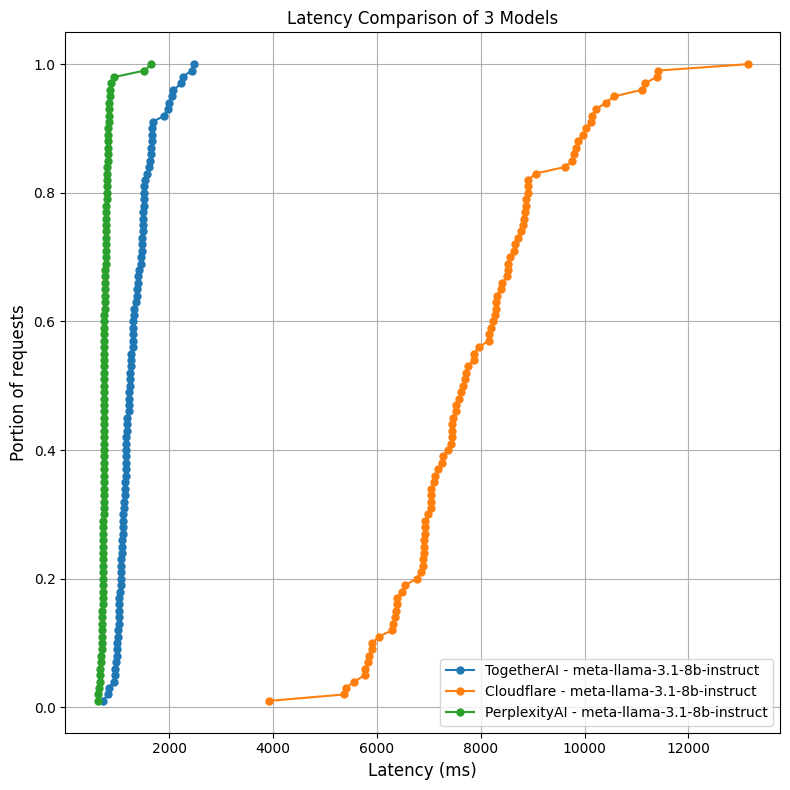

In [28]:

prompt = "What are some fun things to do in New York? Give me 1 short example."
b = Benchmark([TogetherAI(), Cloudflare(),PerplexityAI()], 100, models=["meta-llama-3.1-8b-instruct"], prompt=prompt)
b.run()
b.plot_metrics(b.response_times)

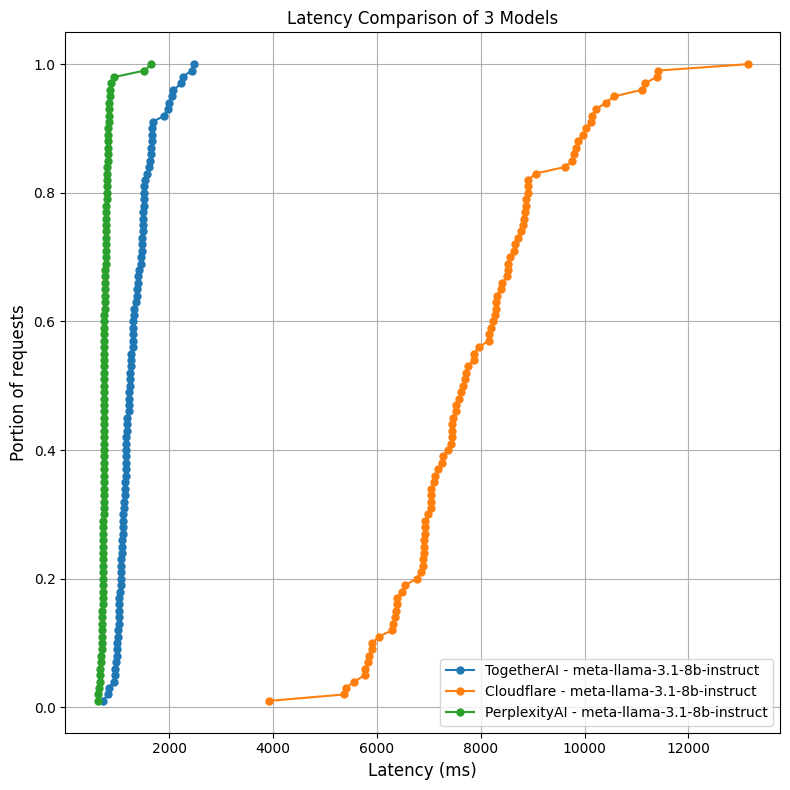

In [29]:
b.plot_metrics(b.response_times)

In [30]:

prompt = "What are some fun things to do in New York? Give me 1 short example."
b = Benchmark([TogetherAI(), Cloudflare(),PerplexityAI()], 100, models=["meta-llama-3.1-8b-instruct"], prompt=prompt,streaming=True)
b.run()


##### TogetherAI

##### Model: meta-llama-3.1-8b-instruct
 ##### Prompt: What are some fun things to do in New York? Give me 1 short example.

Request 0

##### Time to First Token (TTFT): 0.4666 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.0258 seconds

##### Number of output tokens/chunks: 43

Request 1

##### Time to First Token (TTFT): 0.6421 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.1621 seconds

##### Number of output tokens/chunks: 46

Request 2

##### Time to First Token (TTFT): 0.4212 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.1115 seconds

##### Number of output tokens/chunks: 46

Request 3

##### Time to First Token (TTFT): 0.4311 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.0605 seconds

##### Number of output tokens/chunks: 46

Request 4

##### Time to First Token (TTFT): 0.6460 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck. It offers breathtaking views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.1601 seconds

##### Number of output tokens/chunks: 40

Request 5

##### Time to First Token (TTFT): 1.0106 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.6980 seconds

##### Number of output tokens/chunks: 43

Request 6

##### Time to First Token (TTFT): 0.6859 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including the iconic Empire State Building and Central Park.

##### Total Response Time: 1.3013 seconds

##### Number of output tokens/chunks: 41

Request 7

##### Time to First Token (TTFT): 0.4743 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.0135 seconds

##### Number of output tokens/chunks: 46

Request 8

##### Time to First Token (TTFT): 0.9969 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.8387 seconds

##### Number of output tokens/chunks: 46

Request 9

##### Time to First Token (TTFT): 0.4800 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.4365 seconds

##### Number of output tokens/chunks: 43

Request 10

##### Time to First Token (TTFT): 0.4642 seconds


One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### Total Response Time: 0.8436 seconds

##### Number of output tokens/chunks: 74

Request 11

##### Time to First Token (TTFT): 0.6375 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.1708 seconds

##### Number of output tokens/chunks: 46

Request 12

##### Time to First Token (TTFT): 0.6437 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.2928 seconds

##### Number of output tokens/chunks: 43

Request 13

##### Time to First Token (TTFT): 0.4083 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.2176 seconds

##### Number of output tokens/chunks: 46

Request 14

##### Time to First Token (TTFT): 1.0195 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck. It offers breathtaking views of the Manhattan skyline and iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.6989 seconds

##### Number of output tokens/chunks: 39

Request 15

##### Time to First Token (TTFT): 0.9698 seconds


One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### Total Response Time: 2.1486 seconds

##### Number of output tokens/chunks: 74

Request 16

##### Time to First Token (TTFT): 0.4601 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including the iconic Empire State Building and Central Park.

##### Total Response Time: 0.9711 seconds

##### Number of output tokens/chunks: 41

Request 17

##### Time to First Token (TTFT): 0.4066 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.0052 seconds

##### Number of output tokens/chunks: 43

Request 18

##### Time to First Token (TTFT): 1.7981 seconds


One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### Total Response Time: 3.0549 seconds

##### Number of output tokens/chunks: 74

Request 19

##### Time to First Token (TTFT): 0.5136 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.3450 seconds

##### Number of output tokens/chunks: 46

Request 20

##### Time to First Token (TTFT): 0.6831 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck. It offers breathtaking views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.1708 seconds

##### Number of output tokens/chunks: 40

Request 21

##### Time to First Token (TTFT): 0.4220 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 0.8580 seconds

##### Number of output tokens/chunks: 46

Request 22

##### Time to First Token (TTFT): 0.8154 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.5026 seconds

##### Number of output tokens/chunks: 46

Request 23

##### Time to First Token (TTFT): 0.4230 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.0533 seconds

##### Number of output tokens/chunks: 46

Request 24

##### Time to First Token (TTFT): 0.9326 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including the iconic Empire State Building and Central Park.

##### Total Response Time: 1.3884 seconds

##### Number of output tokens/chunks: 41

Request 25

##### Time to First Token (TTFT): 0.6513 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.1532 seconds

##### Number of output tokens/chunks: 46

Request 26

##### Time to First Token (TTFT): 0.5045 seconds


One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### Total Response Time: 1.2428 seconds

##### Number of output tokens/chunks: 74

Request 27

##### Time to First Token (TTFT): 0.5554 seconds


One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### Total Response Time: 1.3838 seconds

##### Number of output tokens/chunks: 74

Request 28

##### Time to First Token (TTFT): 0.5021 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.0553 seconds

##### Number of output tokens/chunks: 46

Request 29

##### Time to First Token (TTFT): 0.6878 seconds


One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### Total Response Time: 1.4616 seconds

##### Number of output tokens/chunks: 74

Request 30

##### Time to First Token (TTFT): 0.8498 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including the iconic Empire State Building and Central Park.

##### Total Response Time: 1.4691 seconds

##### Number of output tokens/chunks: 41

Request 31

##### Time to First Token (TTFT): 0.4178 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.0234 seconds

##### Number of output tokens/chunks: 43

Request 32

##### Time to First Token (TTFT): 0.4962 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.2870 seconds

##### Number of output tokens/chunks: 46

Request 33

##### Time to First Token (TTFT): 0.5430 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including the iconic Empire State Building and Central Park.

##### Total Response Time: 1.1268 seconds

##### Number of output tokens/chunks: 41

Request 34

##### Time to First Token (TTFT): 0.4293 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.0052 seconds

##### Number of output tokens/chunks: 46

Request 35

##### Time to First Token (TTFT): 1.0201 seconds


One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, or take a leisurely boat ride on the lake.

##### Total Response Time: 1.9848 seconds

##### Number of output tokens/chunks: 65

Request 36

##### Time to First Token (TTFT): 0.3477 seconds


One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### Total Response Time: 0.8378 seconds

##### Number of output tokens/chunks: 74

Request 37

##### Time to First Token (TTFT): 0.3718 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 0.8749 seconds

##### Number of output tokens/chunks: 46

Request 38

##### Time to First Token (TTFT): 1.6664 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 2.4029 seconds

##### Number of output tokens/chunks: 43

Request 39

##### Time to First Token (TTFT): 0.5659 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.0709 seconds

##### Number of output tokens/chunks: 46

Request 40

##### Time to First Token (TTFT): 0.7142 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.2146 seconds

##### Number of output tokens/chunks: 46

Request 41

##### Time to First Token (TTFT): 0.6337 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.2124 seconds

##### Number of output tokens/chunks: 43

Request 42

##### Time to First Token (TTFT): 0.6389 seconds


One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, or take a leisurely boat ride on the lake.

##### Total Response Time: 1.6925 seconds

##### Number of output tokens/chunks: 65

Request 43

##### Time to First Token (TTFT): 0.3700 seconds


One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### Total Response Time: 0.7351 seconds

##### Number of output tokens/chunks: 74

Request 44

##### Time to First Token (TTFT): 0.6154 seconds


One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, or take a leisurely boat ride on the lake.

##### Total Response Time: 1.1139 seconds

##### Number of output tokens/chunks: 65

Request 45

##### Time to First Token (TTFT): 0.7121 seconds


One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### Total Response Time: 1.4839 seconds

##### Number of output tokens/chunks: 74

Request 46

##### Time to First Token (TTFT): 0.6640 seconds


One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, or take a leisurely boat ride on the lake.

##### Total Response Time: 1.6363 seconds

##### Number of output tokens/chunks: 65

Request 47

##### Time to First Token (TTFT): 0.5306 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.1319 seconds

##### Number of output tokens/chunks: 46

Request 48

##### Time to First Token (TTFT): 0.4935 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including the iconic Empire State Building and Central Park.

##### Total Response Time: 1.2099 seconds

##### Number of output tokens/chunks: 41

Request 49

##### Time to First Token (TTFT): 0.5319 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including the iconic Empire State Building and Central Park.

##### Total Response Time: 0.8462 seconds

##### Number of output tokens/chunks: 41

Request 50

##### Time to First Token (TTFT): 0.5293 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.2198 seconds

##### Number of output tokens/chunks: 46

Request 51

##### Time to First Token (TTFT): 0.5683 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.2170 seconds

##### Number of output tokens/chunks: 43

Request 52

##### Time to First Token (TTFT): 0.6615 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.3438 seconds

##### Number of output tokens/chunks: 46

Request 53

##### Time to First Token (TTFT): 0.6350 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.4833 seconds

##### Number of output tokens/chunks: 46

Request 54

##### Time to First Token (TTFT): 0.4546 seconds


One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### Total Response Time: 1.0123 seconds

##### Number of output tokens/chunks: 74

Request 55

##### Time to First Token (TTFT): 0.5997 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 0.9414 seconds

##### Number of output tokens/chunks: 46

Request 56

##### Time to First Token (TTFT): 1.8285 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 2.4366 seconds

##### Number of output tokens/chunks: 46

Request 57

##### Time to First Token (TTFT): 0.9597 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including the iconic Empire State Building and Central Park.

##### Total Response Time: 1.4645 seconds

##### Number of output tokens/chunks: 41

Request 58

##### Time to First Token (TTFT): 0.4967 seconds


One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### Total Response Time: 1.3016 seconds

##### Number of output tokens/chunks: 74

Request 59

##### Time to First Token (TTFT): 0.4686 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.0714 seconds

##### Number of output tokens/chunks: 46

Request 60

##### Time to First Token (TTFT): 0.7093 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.4758 seconds

##### Number of output tokens/chunks: 46

Request 61

##### Time to First Token (TTFT): 0.6127 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.2392 seconds

##### Number of output tokens/chunks: 46

Request 62

##### Time to First Token (TTFT): 0.6127 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.1212 seconds

##### Number of output tokens/chunks: 46

Request 63

##### Time to First Token (TTFT): 0.6570 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.2948 seconds

##### Number of output tokens/chunks: 46

Request 64

##### Time to First Token (TTFT): 0.7250 seconds


One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### Total Response Time: 1.7829 seconds

##### Number of output tokens/chunks: 74

Request 65

##### Time to First Token (TTFT): 0.3756 seconds


One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### Total Response Time: 1.0251 seconds

##### Number of output tokens/chunks: 74

Request 66

##### Time to First Token (TTFT): 0.3742 seconds


One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### Total Response Time: 0.9719 seconds

##### Number of output tokens/chunks: 74

Request 67

##### Time to First Token (TTFT): 0.7913 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.5259 seconds

##### Number of output tokens/chunks: 43

Request 68

##### Time to First Token (TTFT): 0.9266 seconds


One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### Total Response Time: 2.2340 seconds

##### Number of output tokens/chunks: 74

Request 69

##### Time to First Token (TTFT): 0.4196 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.0647 seconds

##### Number of output tokens/chunks: 43

Request 70

##### Time to First Token (TTFT): 0.6563 seconds


One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### Total Response Time: 1.8333 seconds

##### Number of output tokens/chunks: 74

Request 71

##### Time to First Token (TTFT): 0.8392 seconds


One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### Total Response Time: 1.7723 seconds

##### Number of output tokens/chunks: 74

Request 72

##### Time to First Token (TTFT): 0.7349 seconds


One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### Total Response Time: 1.7575 seconds

##### Number of output tokens/chunks: 74

Request 73

##### Time to First Token (TTFT): 0.8455 seconds


One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### Total Response Time: 1.8924 seconds

##### Number of output tokens/chunks: 74

Request 74

##### Time to First Token (TTFT): 0.4773 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 0.9896 seconds

##### Number of output tokens/chunks: 46

Request 75

##### Time to First Token (TTFT): 0.4818 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.1390 seconds

##### Number of output tokens/chunks: 43

Request 76

##### Time to First Token (TTFT): 0.6399 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.3479 seconds

##### Number of output tokens/chunks: 46

Request 77

##### Time to First Token (TTFT): 0.4553 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 0.9717 seconds

##### Number of output tokens/chunks: 43

Request 78

##### Time to First Token (TTFT): 0.4883 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.1525 seconds

##### Number of output tokens/chunks: 43

Request 79

##### Time to First Token (TTFT): 0.5720 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.2472 seconds

##### Number of output tokens/chunks: 46

Request 80

##### Time to First Token (TTFT): 0.5389 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.1161 seconds

##### Number of output tokens/chunks: 46

Request 81

##### Time to First Token (TTFT): 0.4966 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including the iconic Empire State Building and Central Park.

##### Total Response Time: 0.9800 seconds

##### Number of output tokens/chunks: 41

Request 82

##### Time to First Token (TTFT): 1.1923 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.8999 seconds

##### Number of output tokens/chunks: 43

Request 83

##### Time to First Token (TTFT): 1.1277 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including the iconic Empire State Building and Central Park.

##### Total Response Time: 1.7541 seconds

##### Number of output tokens/chunks: 41

Request 84

##### Time to First Token (TTFT): 0.5040 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 0.8541 seconds

##### Number of output tokens/chunks: 46

Request 85

##### Time to First Token (TTFT): 0.5564 seconds


One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### Total Response Time: 1.2275 seconds

##### Number of output tokens/chunks: 74

Request 86

##### Time to First Token (TTFT): 0.7520 seconds


One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse, or attend one of the many events and concerts held there throughout the year.

##### Total Response Time: 1.6549 seconds

##### Number of output tokens/chunks: 84

Request 87

##### Time to First Token (TTFT): 0.4866 seconds


One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### Total Response Time: 1.2042 seconds

##### Number of output tokens/chunks: 74

Request 88

##### Time to First Token (TTFT): 0.4608 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.0466 seconds

##### Number of output tokens/chunks: 46

Request 89

##### Time to First Token (TTFT): 0.6908 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.1691 seconds

##### Number of output tokens/chunks: 46

Request 90

##### Time to First Token (TTFT): 0.4607 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking views of the Manhattan skyline, including the iconic Empire State Building and Central Park.

##### Total Response Time: 1.1440 seconds

##### Number of output tokens/chunks: 41

Request 91

##### Time to First Token (TTFT): 0.4862 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 0.9602 seconds

##### Number of output tokens/chunks: 46

Request 92

##### Time to First Token (TTFT): 0.5575 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.0507 seconds

##### Number of output tokens/chunks: 46

Request 93

##### Time to First Token (TTFT): 0.8620 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.4309 seconds

##### Number of output tokens/chunks: 46

Request 94

##### Time to First Token (TTFT): 0.4631 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 0.9798 seconds

##### Number of output tokens/chunks: 46

Request 95

##### Time to First Token (TTFT): 1.0954 seconds


One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### Total Response Time: 2.2877 seconds

##### Number of output tokens/chunks: 74

Request 96

##### Time to First Token (TTFT): 0.6623 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck at Rockefeller Center. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.1795 seconds

##### Number of output tokens/chunks: 46

Request 97

##### Time to First Token (TTFT): 0.5586 seconds


One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### Total Response Time: 1.2888 seconds

##### Number of output tokens/chunks: 74

Request 98

##### Time to First Token (TTFT): 0.4118 seconds


One fun thing to do in New York is to take a stroll through Central Park. This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse.

##### Total Response Time: 1.2755 seconds

##### Number of output tokens/chunks: 74

Request 99

##### Time to First Token (TTFT): 0.6631 seconds


One fun thing to do in New York is visiting the Top of the Rock Observation Deck. It offers breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building and Central Park.

##### Total Response Time: 1.1968 seconds

##### Number of output tokens/chunks: 43

##### Cloudflare

##### Model: meta-llama-3.1-8b-instruct
 ##### Prompt: What are some fun things to do in New York? Give me 1 short example.

Request 0

##### Time to First Token (TTFT): 2.2100 seconds


The city that never sleeps! Here's a fun example:\n\n**Take a stroll across the Brooklyn Bridge with amazing views of the Manhattan skyline**\n\nWalk across the iconic Brooklyn Bridge, which connects Brooklyn to Manhattan. The pedestrian walkway offers breathtaking views of the Manhattan skyline, the East River, and the Statue of Liberty. Stop at the midpoint to take in the views and snap some memorable photos!\n\nIs this a good starting point? I'd be happy to give you more suggestions!

##### Total Response Time: 9.1364 seconds

##### Number of output tokens/chunks: 97

Request 1

##### Time to First Token (TTFT): 0.8720 seconds


The city that never sleeps! Here's a quick example of a fun thing to do in New York:\n\n**Take a stroll across the High Line**\n\nThe High Line is an elevated park built on an old rail line, offering stunning views of the Hudson River and the city. You can walk along the park, take in the public art installations, and enjoy the gardens and food vendors. It's a great way to experience the city's unique energy and beauty.

##### Total Response Time: 8.2355 seconds

##### Number of output tokens/chunks: 94

Request 2

##### Time to First Token (TTFT): 0.6409 seconds


The city that never sleeps! Here's a fun one:\n\n**Take a Walk Across the Brooklyn Bridge**\n\nExperience the majestic view of the Manhattan skyline while walking across one of the most iconic bridges in the world. The pedestrian walkway offers stunning views of the Statue of Liberty, the East River, and the skyscrapers of Lower Manhattan. Once you reach the other side, explore DUMBO (Down Under the Manhattan Bridge Overpass) and enjoy the trendy shops, restaurants, and street art.\n\nWhat do you think?

##### Total Response Time: 7.8570 seconds

##### Number of output tokens/chunks: 107

Request 3

##### Time to First Token (TTFT): 0.9959 seconds


The city that never sleeps! Here's a fun thing to do in New York:\n\n**Take a stroll through Central Park at sunset**\n\nWalk through the park's winding paths, enjoy the beautiful scenery, and take in the breathtaking views of the Manhattan skyline. Rent a bike or a boat, or simply sit on a bench and people-watch. You might even catch a live performance at one of the many music venues or street performers scattered throughout the park.

##### Total Response Time: 6.6585 seconds

##### Number of output tokens/chunks: 92

Request 4

##### Time to First Token (TTFT): 0.9596 seconds


The city that never sleeps! Here's a short and fun example of something to do in New York:\n\n**Take a stroll across the Brooklyn Bridge**\n\nImagine walking across one of the most iconic bridges in the world, with stunning views of the Manhattan skyline, the East River, and the Statue of Liberty in the distance. You can start in Brooklyn and make your way to Manhattan, stopping at the bridge's pedestrian walkway and taking in the sights and sounds of the city. It's a great way to experience the energy of New York and get some amazing photo opportunities!

##### Total Response Time: 8.1631 seconds

##### Number of output tokens/chunks: 116

Request 5

##### Time to First Token (TTFT): 0.9616 seconds


The city that never sleeps! Here's one fun example:\n\n**Take a stroll across the Brooklyn Bridge**: Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. It's a free and exhilarating experience that's great for photos and taking in the city's energy.\n\nHave any other specific interests (e.g. museums, food, entertainment)? I can give you more tailored suggestions!

##### Total Response Time: 6.7057 seconds

##### Number of output tokens/chunks: 93

Request 6

##### Time to First Token (TTFT): 1.2097 seconds


The city that never sleeps! New York has endless options for fun activities. Here's a short example:\n\n**Take a stroll across the Brooklyn Bridge**\n\nWalk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can start at either end of the bridge, in Manhattan or in Brooklyn, and enjoy the street performers, food vendors, and photo opportunities along the way. It's a classic NYC experience!\n\nWould you like more ideas?

##### Total Response Time: 7.6515 seconds

##### Number of output tokens/chunks: 103

Request 7

##### Time to First Token (TTFT): 0.6801 seconds


The city that never sleeps! New York is a treasure trove of exciting experiences. Here's a short example:\n\n**Walk across the Brooklyn Bridge**: Catch a stunning view of the Manhattan skyline, the East River, and the Statue of Liberty while walking across the iconic Brooklyn Bridge. The bridge connects Brooklyn to Manhattan and offers breathtaking views of the city and the waterfront. It's a great way to experience the city's energy and beauty!

##### Total Response Time: 6.1426 seconds

##### Number of output tokens/chunks: 89

Request 8

##### Time to First Token (TTFT): 0.6491 seconds


The city that never sleeps! Here's a fun example:\n\n**See a Broadway Show**\n\nNew York City is home to some of the world's most iconic theaters, and catching a Broadway show is a classic must-do experience. Whether it's a musical, play, or comedy, there's something for every taste and age. You can buy tickets in advance or try for same-day rush tickets at the theater box office. Many shows also offer backstage tours or meet-and-greets for an extra special experience!\n\nWhat else would you like to do in NYC?

##### Total Response Time: 7.9661 seconds

##### Number of output tokens/chunks: 114

Request 9

##### Time to First Token (TTFT): 2.2439 seconds


The city that never sleeps! New York has endless possibilities for fun and excitement. Here's one short example:\n\n**Take a stroll across the Brooklyn Bridge**\n\nImagine walking across one of the most iconic bridges in the world, with stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. The Brooklyn Bridge offers breathtaking panoramic views and makes for a romantic and scenic walk. You can start in Brooklyn or Manhattan and experience the charming atmosphere of the city.

##### Total Response Time: 8.1198 seconds

##### Number of output tokens/chunks: 96

Request 10

##### Time to First Token (TTFT): 1.0127 seconds


The city that never sleeps! Here's a fun thing to do in New York:\n\n**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge and take in the stunning views of Manhattan, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on the way, grab a snack, and enjoy the street performers and stunning city skyline views. It's a free and iconic NYC experience!

##### Total Response Time: 6.1768 seconds

##### Number of output tokens/chunks: 85

Request 11

##### Time to First Token (TTFT): 2.0198 seconds


The city that never sleeps! Here's a fun thing to do in New York:\n\n**Take a stroll across the Brooklyn Bridge**\n\nWalk across the iconic Brooklyn Bridge for spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You'll enjoy stunning cityscapes, street performers, and a taste of the city's diverse culture. It's a free and invigorating experience that's sure to leave you with amazing memories!\n\nIs that all you wanted to know, or would you like more ideas?

##### Total Response Time: 10.6510 seconds

##### Number of output tokens/chunks: 107

Request 12

##### Time to First Token (TTFT): 1.0155 seconds


The city that never sleeps! Here's a fun example:\n\n**Take a stroll across the Brooklyn Bridge at sunset**\n\nWalk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. The bridge is especially beautiful during sunset, when the lights of the city come alive. You can start at either end of the bridge, in Brooklyn or Manhattan, and enjoy the pedestrian walkway, which is lined with street performers, food carts, and elevated views of the city.\n\nHow's that for a taste of New York City's unique energy?

##### Total Response Time: 9.6744 seconds

##### Number of output tokens/chunks: 121

Request 13

##### Time to First Token (TTFT): 2.6412 seconds


The city that never sleeps! Here's a fun idea:\n\n**Take a sunset stroll across the Brooklyn Bridge**: Start at the Manhattan side of the bridge, walk across to Brooklyn, and take in the stunning views of the Manhattan skyline, the East River, and the Brooklyn Bridge itself. Time it right, and you'll catch a beautiful sunset over the city. It's a classic NYC experience that's free and full of photo ops!

##### Total Response Time: 8.8077 seconds

##### Number of output tokens/chunks: 89

Request 14

##### Time to First Token (TTFT): 2.2142 seconds


The city that never sleeps! Here's a fun thing to do in New York:\n\n**Take a stroll across the Brooklyn Bridge**\n\nWalk across this iconic landmark and enjoy the stunning views of the Manhattan skyline, the East River, and Brooklyn. It's a great way to take in the sights and sounds of the city, and you might even spot some street performers, bike riders, or fellow tourists along the way. Plus, you'll get to experience two of NYC's coolest neighborhoods: Brooklyn and Manhattan.

##### Total Response Time: 9.5341 seconds

##### Number of output tokens/chunks: 103

Request 15

##### Time to First Token (TTFT): 0.6439 seconds


The city that never sleeps! Here are some fun things to do in New York, and one short example:\n\n**One short example:** **Take a stroll through Central Park!** Rent a bike or walk through the 843 acres of beautiful green space in the heart of Manhattan. You can visit famous landmarks like the Bethesda Fountain, Loeb Boathouse, and the Conservatory Garden. It's a great way to escape the hustle and bustle of the city and enjoy some fresh air and NYC scenery.\n\nSome other ideas to explore:\n\n* Visit the Statue of Liberty and Ellis Island\n* Take in a Broadway show or a TV taping\n* Explore the Metropolitan Museum of Art or MoMA\n* Shop at iconic department stores like Macy's or Bloomingdale's\n* Sample the diverse food scene in Chinatown, Little Italy, or Koreatown\n* Visit the Top of the Rock Observation Deck for stunning views of the city\n\nLet me know if you'd like more ideas!

##### Total Response Time: 15.6480 seconds

##### Number of output tokens/chunks: 201

Request 16

##### Time to First Token (TTFT): 1.0767 seconds


The city that never sleeps! Here's a fun thing to do in New York:\n\n**Visit the Top of the Rock Observation Deck**\n\nTake a trip to the Top of the Rock Observation Deck in Midtown Manhattan for breathtaking views of the city. On a clear day, you can see iconic landmarks like the Statue of Liberty, the Empire State Building, and the Chrysler Building. It's a thrilling way to experience the energy and excitement of the city from a unique perspective.\n\nHope you find this a great suggestion! Do you want more ideas?

##### Total Response Time: 8.3521 seconds

##### Number of output tokens/chunks: 110

Request 17

##### Time to First Token (TTFT): 4.2711 seconds


The city that never sleeps! New York has endless options, but here's a fun one:\n\n**Catch a Broadway Show**\n\nExperience the magic of live theater in the heart of New York City. Choose from a vast array of iconic shows like Hamilton, The Lion King, Wicked, or Les Misérables, or opt for a classic broadway musical. The energy of the crowd, the iconic theaters, and the excitement of live performance make for an unforgettable night out!

##### Total Response Time: 10.3860 seconds

##### Number of output tokens/chunks: 97

Request 18

##### Time to First Token (TTFT): 1.3497 seconds


The city that never sleeps! Here's a fun thing to do in New York:\n\n**Take a boat tour of the Statue of Liberty and Ellis Island**: Imagine cruising through New York Harbor, taking in the stunning views of the Manhattan skyline, and learning about the history of two iconic American landmarks. You can even visit the Statue of Liberty's pedestal and Ellis Island's Immigration Museum. It's a thrilling adventure that combines history, culture, and stunning views of the city.

##### Total Response Time: 7.2776 seconds

##### Number of output tokens/chunks: 96

Request 19

##### Time to First Token (TTFT): 1.0440 seconds


New York City! The city that never sleeps! Here's just one fun thing to do in New York:\n\n**Take a walk across the Brooklyn Bridge**: Walk across this iconic bridge while taking in the stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. It's a classic NYC experience that's free and accessible to everyone. Plus, the walk is about 1.1 miles, so you can enjoy a leisurely stroll while taking in the sights and sounds of the city.

##### Total Response Time: 7.5983 seconds

##### Number of output tokens/chunks: 104

Request 20

##### Time to First Token (TTFT): 0.6869 seconds


The city that never sleeps! Here's a short example:\n\n**Ice Skating at Rockefeller Center**\n\nEvery winter, the iconic Rockefeller Center ice rink in Midtown Manhattan transforms into a festive winter wonderland. You can lace up your skates and enjoy the magic of ice skating surrounded by towering skyscrapers, holiday lights, and the iconic Christmas tree. It's a quintessential NYC experience that's fun for all ages!\n\n(Note: This is just one example, and New York City offers countless other exciting activities, from world-class museums and Broadway shows to food tours and parks to explore. Would you like more ideas?)

##### Total Response Time: 8.6015 seconds

##### Number of output tokens/chunks: 127

Request 21

##### Time to First Token (TTFT): 1.3385 seconds


The city that never sleeps! Here's a fun thing to do in New York:\n\n**Take a stroll through Central Park:** Walk through the scenic paths, rent a bike, or grab a picnic blanket and enjoy the lakes, fountains, and gardens of the 843-acre green oasis right in the heart of Manhattan.

##### Total Response Time: 6.8538 seconds

##### Number of output tokens/chunks: 66

Request 22

##### Time to First Token (TTFT): 1.2901 seconds


The city that never sleeps! Here's a fun thing to do in New York:\n\n**Take a stroll across the Brooklyn Bridge**\n\nImagine walking across an iconic suspension bridge with the Manhattan skyline as your backdrop. The views of the East River, the Statue of Liberty, and the Manhattan skyscrapers are simply breathtaking. It's a great way to take in the sights and sounds of the city while getting some exercise. Plus, you'll feel like a true New Yorker!\n\nWould you like more ideas?

##### Total Response Time: 8.4813 seconds

##### Number of output tokens/chunks: 102

Request 23

##### Time to First Token (TTFT): 1.1622 seconds


The city that never sleeps! Here's a brief example of a fun thing to do in New York:\n\n**Take a stroll through Times Square at night**: Experience the bright lights, giant billboards, and lively energy of the famous Times Square. Grab a slice of pizza, catch a street performer, or simply take in the neon spectacle that is Times Square after dark.\n\nWould you like to know more about things to do in New York or would you like another example?

##### Total Response Time: 8.0078 seconds

##### Number of output tokens/chunks: 96

Request 24

##### Time to First Token (TTFT): 0.8796 seconds


The city that never sleeps! Here's a fun example:\n\n**Take a stroll through Central Park during sunset**\n\nJoin the lively atmosphere at Central Park, one of the largest urban parks in the world. As the sun sets over the Manhattan skyline, walk through the park's many scenic paths and stops, such as the Bethesda Fountain, the Loeb Boathouse, and the Conservatory Garden. You might even catch some street performers, live music, or a free outdoor concert.\n\nThis is just one of many amazing experiences to be had in the one and only New York City!

##### Total Response Time: 9.2181 seconds

##### Number of output tokens/chunks: 118

Request 25

##### Time to First Token (TTFT): 0.9874 seconds


Here's a short and fun idea:\n\n**Take a stroll across the Brooklyn Bridge**\n\nWalk across this iconic suspension bridge, taking in the stunning city views of Manhattan, Brooklyn, and the East River. You'll have a bird's eye view of the Statue of Liberty and the Lower Manhattan skyline. The bridge is pedestrian-friendly, so you can stop and take photos or grab a snack at a street vendor along the way. Plus, it's a great way to explore two of New York's coolest neighborhoods: DUMBO (Down Under the Manhattan Bridge Overpass) in Brooklyn and the Financial District in Manhattan!

##### Total Response Time: 10.4722 seconds

##### Number of output tokens/chunks: 124

Request 26

##### Time to First Token (TTFT): 1.4635 seconds


The city that never sleeps! New York City has endless options for fun and adventure. Here's a short example:\n\n**Take a stroll through Central Park**\n\nTake a romantic walk through the 843 acres of Central Park, one of the most famous parks in the world. You could people-watch, visit the Bethesda Fountain, boat in Central Park Lake, or take a leisurely bike ride through the park. Whatever you choose, you'll experience the best of nature and urban living in one place!\n\nThere are many more fun things to do in NYC, but this is just one example to get you started.

##### Total Response Time: 10.6045 seconds

##### Number of output tokens/chunks: 123

Request 27

##### Time to First Token (TTFT): 1.1816 seconds


The city that never sleeps! Here's a short and fun idea:\n\n**Take a Walk across the Brooklyn Bridge**\n\nExperience the iconic New York City skyline and the East River by walking across the iconic Brooklyn Bridge. The views of the Manhattan skyline, including the Statue of Liberty, are breathtaking. Plus, you'll walk through charming Brooklyn neighborhoods like DUMBO and Brooklyn Heights. It's a great way to take in the city's energy and get some exercise!\n\nWould you like more ideas?

##### Total Response Time: 8.1758 seconds

##### Number of output tokens/chunks: 100

Request 28

##### Time to First Token (TTFT): 0.8930 seconds


Here's a short example of a fun thing to do in New York:\n\n**Take a stroll across the Brooklyn Bridge**: Imagine walking across an iconic landmark that connects two of the city's most vibrant neighborhoods (DUMBO and Brooklyn Heights). Enjoy spectacular city views of the Manhattan skyline, the East River, and the Statue of Liberty while taking a leisurely walk across this beloved bridge.\n\nThat's just one of the many exciting experiences waiting for you in the city that never sleeps!

##### Total Response Time: 8.0034 seconds

##### Number of output tokens/chunks: 98

Request 29

##### Time to First Token (TTFT): 0.9803 seconds


The city that never sleeps! Here's a quick and fun example:\n\n**Take a stroll across the Brooklyn Bridge at sunset**: This iconic bridge offers stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. As the sun sets, the bridge is illuminated, making for a breathtaking sight. It's a classic New York experience that's free and accessible to everyone!\n\nWould you like more suggestions?

##### Total Response Time: 6.6082 seconds

##### Number of output tokens/chunks: 85

Request 30

##### Time to First Token (TTFT): 0.6919 seconds


The city that never sleeps! Here's a fun example:\n\n**Take a stroll across the Brooklyn Bridge**: Walk across the iconic Brooklyn Bridge, which offers spectacular 360-degree views of the Manhattan skyline, the East River, and Brooklyn. You can take in the sights and sounds of the city while getting a taste of history as you explore one of the most famous bridges in the world.

##### Total Response Time: 5.4777 seconds

##### Number of output tokens/chunks: 79

Request 31

##### Time to First Token (TTFT): 1.4242 seconds


The city that never sleeps! New York is a vibrant and exciting destination with endless options for entertainment, culture, and adventure. Here's a fun thing to do in New York:\n\n**Take a stroll across the Brooklyn Bridge!**\n\nExperience the iconic Manhattan skyline, the East River, and the breathtaking views of the Statue of Liberty from the famous pedestrian walkway of the Brooklyn Bridge. You'll feel like a true New Yorker as you walk across this historic landmark, and the photo opportunities are endless!\n\nWould you like more ideas?

##### Total Response Time: 7.9603 seconds

##### Number of output tokens/chunks: 107

Request 32

##### Time to First Token (TTFT): 0.8078 seconds


The city that never sleeps! Here's a fun thing to do in New York:\n\n**Take a Sunset Helicopter Tour over the Manhattan Skyline**\n\nImagine soaring above the towering skyscrapers, iconic landmarks, and bustling streets of Manhattan as the sun sets behind you. This thrilling 20-minute tour offers an unforgettable bird's-eye view of iconic spots like the Statue of Liberty, Central Park, and Times Square. It's a unique perspective on the city that will leave you in awe!\n\nWould you like more ideas or have a specific interest (e.g., museums, food, arts, etc.)?

##### Total Response Time: 8.4176 seconds

##### Number of output tokens/chunks: 123

Request 33

##### Time to First Token (TTFT): 0.9091 seconds


The city that never sleeps! Here's a fun thing to do in New York:\n\n**Take a stroll across the Brooklyn Bridge for breathtaking city views**: Walk or bike across this iconic suspension bridge, which offers spectacular views of the Manhattan skyline, the Statue of Liberty, and the East River. It's a great way to experience the energy of the city and take in its sights and sounds.

##### Total Response Time: 5.8495 seconds

##### Number of output tokens/chunks: 80

Request 34

##### Time to First Token (TTFT): 2.6453 seconds


Here's a fun one:\n\n**Take a stroll through Central Park**\n\nGet inspired by the lush greenery, picturesque lakes, and beautifully maintained gardens of Central Park. Pack a picnic and sit by the Loeb Boathouse, visit the Children's Zoo, or ride the famous Loeb Boathouse Carousel. You can also take a leisurely walk through the park to explore the various landmarks, including the Bethesda Fountain, the Alice in Wonderland statue, and the Conservatory Garden. Whichever you choose, it's a quintessential New York experience that's perfect for all ages!

##### Total Response Time: 11.5001 seconds

##### Number of output tokens/chunks: 119

Request 35

##### Time to First Token (TTFT): 1.2256 seconds


The city that never sleeps! Here's a fun idea:\n\n**Take a stroll across the Brooklyn Bridge**\n\nWalk across the iconic Brooklyn Bridge, taking in the breathtaking views of the Manhattan skyline, the East River, and the Statue of Liberty. It's a great way to experience the energy and history of the city, and you can even pause to grab a snack or take a selfie at the midpoint!

##### Total Response Time: 6.8834 seconds

##### Number of output tokens/chunks: 82

Request 36

##### Time to First Token (TTFT): 0.6732 seconds


The city that never sleeps! New York City is a treasure trove of exciting activities, cultural experiences, and entertainment. Here's one fun idea:\n\n**Take a stroll through Central Park**\n\nCentral Park is an 843-acre oasis in the middle of Manhattan, offering a peaceful escape from the hustle and bustle of the city. You can walk, bike, or take a leisurely boat ride on the lake, visit the famous Bethesda Fountain, and enjoy the stunning contrasts of urban and natural landscapes. It's a great way to relax, people-watch, and take in the city's unique energy.\n\nWould you like more ideas or information?

##### Total Response Time: 10.0244 seconds

##### Number of output tokens/chunks: 130

Request 37

##### Time to First Token (TTFT): 1.5411 seconds


The city that never sleeps! Here's one short example of a fun thing to do in New York:\n\n**Take a stroll across the Brooklyn Bridge at sunset**\n\nWatch the Manhattan skyline unfold as you walk across this iconic bridge, taking in the stunning views of the East River, the Statue of Liberty, and the Manhattan skyline. You can stop at the Brooklyn Bridge Park on one side or Pier 15 on the other for a picnic or snacks. It's a great way to experience the excitement and energy of the big city.

##### Total Response Time: 8.7412 seconds

##### Number of output tokens/chunks: 107

Request 38

##### Time to First Token (TTFT): 1.2302 seconds


The city that never sleeps! Here's a fun thing to do in New York:\n\n**Take a stroll across the Brooklyn Bridge**: Start at City Hall in Manhattan and walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and Brooklyn. Stop at the Brooklyn Bridge Park on the other side for some great spots to take photos and enjoy the waterfront.\n\nWant more ideas? Just let me know!

##### Total Response Time: 7.2408 seconds

##### Number of output tokens/chunks: 89

Request 39

##### Time to First Token (TTFT): 0.6417 seconds


The city that never sleeps! Here's a short example:\n\n**Take a sunset stroll across the Brooklyn Bridge**\n\nImagine walking across the iconic Brooklyn Bridge while taking in the breathtaking views of the Manhattan skyline, the East River, and the Statue of Liberty. As the sun sets over the Hudson River, the sky turns pink and orange, and the bridge is surrounded by a sense of energy and excitement. It's a quintessential New York experience that's sure to leave you with lifelong memories.

##### Total Response Time: 7.3186 seconds

##### Number of output tokens/chunks: 99

Request 40

##### Time to First Token (TTFT): 1.3481 seconds


The city that never sleeps! Here's a fun thing to do in New York:\n\n**Walk across the Brooklyn Bridge**: Take a stroll across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can also stop at the Brooklyn Bridge Park or DUMBO neighborhood on the Brooklyn side for great food, shopping, and photo ops.

##### Total Response Time: 6.2810 seconds

##### Number of output tokens/chunks: 76

Request 41

##### Time to First Token (TTFT): 1.4330 seconds


The city that never sleeps! Here's a fun thing to do in New York:\n\n**Take a stroll across the Brooklyn Bridge at sunset**\n\nExperience the breathtaking views of the Manhattan skyline, the East River, and the Statue of Liberty while walking across the historic Brooklyn Bridge. The Manhattan skyline lights up at sunset, creating a stunning backdrop for your photo ops. You can also stop in Brooklyn for a slice of pizza or a drink at one of the trendy cafes in DUMBO.\n\nWould you like more ideas?

##### Total Response Time: 7.8512 seconds

##### Number of output tokens/chunks: 104

Request 42

##### Time to First Token (TTFT): 0.8732 seconds


The city that never sleeps! Here's one fun thing to do in New York:\n\n**Take a stroll through Central Park**: Escape the hustle and bustle of Manhattan and enjoy a leisurely walk through the picturesque Central Park. Rent a bike, have a picnic on the Great Lawn, or visit famous spots like the Loeb Boathouse, the Bethesda Fountain, and the Conservatory Garden. It's a free or low-cost activity that's perfect for all ages!\n\nWould you like another example or any specific type of activity?

##### Total Response Time: 7.7100 seconds

##### Number of output tokens/chunks: 108

Request 43

##### Time to First Token (TTFT): 1.0679 seconds


The city that never sleeps! Here's a fun thing to do in New York: **Take a stroll through Central Park**\n\nRent a bike or take a leisurely walk through the park, which offers a tranquil oasis in the midst of Manhattan's bustling streets. You can visit famous landmarks like the Bethesda Fountain, Loeb Boathouse, and the Conservatory Garden, and take a break at one of the many picnic spots. It's a great way to experience the city's natural beauty and get some exercise too!

##### Total Response Time: 7.5186 seconds

##### Number of output tokens/chunks: 106

Request 44

##### Time to First Token (TTFT): 1.9999 seconds


The city that never sleeps! There are countless fun things to do in New York. Here's a short example:\n\n**Take a stroll across the Brooklyn Bridge**\n\nWalk across this iconic suspension bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. The bridge offers an exhilarating on-foot route that's approximately 1.1 miles long and takes around 20-30 minutes to walk. Plus, you'll get to see the city's majestic skyline and enjoy the warm breeze (if it's a nice day).

##### Total Response Time: 8.7558 seconds

##### Number of output tokens/chunks: 109

Request 45

##### Time to First Token (TTFT): 0.6662 seconds


The city that never sleeps! Here's a fun thing to do in New York:\n\n**Visit the Top of the Rock Observation Deck at Rockefeller Center**\n\nTake a high-speed elevator to the 70th floor of Rockefeller Center and enjoy breathtaking 360-degree views of the Manhattan skyline, including iconic landmarks like the Empire State Building, the Chrysler Building, and Central Park. It's a great way to see the city in all its glory, and the views are especially stunning at sunset or twilight.

##### Total Response Time: 8.3288 seconds

##### Number of output tokens/chunks: 100

Request 46

##### Time to First Token (TTFT): 0.7716 seconds


The city that never sleeps! Here's a fun thing to do in New York:\n\n**Take a stroll through Central Park**: Wander through the beautiful gardens, explore the Central Park Zoo, rent a bike or boat, and enjoy a picnic on the Great Lawn. It's a peaceful oasis in the middle of the bustling city.\n\nWhat type of activities are you interested in? I'd be happy to give you more examples!

##### Total Response Time: 6.8806 seconds

##### Number of output tokens/chunks: 86

Request 47

##### Time to First Token (TTFT): 0.6995 seconds


Here's a fun thing to do in New York:\n\nRide the Staten Island Ferry for free! The ferry offers stunning views of the Manhattan skyline, Statue of Liberty, and Brooklyn Bridge. Plus, it's completely free and runs 24/7. You can catch it from Whitehall Terminal in Lower Manhattan or St. George Terminal on Staten Island. It's a great way to experience NYC without breaking the bank!

##### Total Response Time: 7.4505 seconds

##### Number of output tokens/chunks: 86

Request 48

##### Time to First Token (TTFT): 1.0317 seconds


The city that never sleeps! New York has endless opportunities for fun and adventure. Here's a short example:\n\n**Take a stroll across the Brooklyn Bridge at sunset**: Walk across one of the most iconic bridges in the world and enjoy breathtaking views of the Manhattan skyline, the East River, and Brooklyn. It's a romantic and scenic experience that's free and open to the public. You can even stop at the Brooklyn Bridge Park on the Brooklyn side and grab a slice of pizza or a snack to enjoy while taking in the views!\n\nWhat would you like to know more about in New York?

##### Total Response Time: 9.8237 seconds

##### Number of output tokens/chunks: 120

Request 49

##### Time to First Token (TTFT): 1.8796 seconds


The city that never sleeps! New York City has endless options for fun and exciting experiences. Here's just one example:\n\n**Take a stroll through Central Park**\n\nRent a bike or walk through this 843-acre green oasis in the middle of Manhattan. You can explore the Bethesda Fountain, Loeb Boathouse, and the Conservatory Garden, or take a horse-drawn carriage ride through the park. In the winter, you can ice skate at Wollman Rink or rent ice skates and enjoy the festive atmosphere. Come back at sunset or nighttime to experience the park's stunning lights and beautiful views of the city skyline.

##### Total Response Time: 11.2170 seconds

##### Number of output tokens/chunks: 129

Request 50

##### Time to First Token (TTFT): 1.5848 seconds


The city that never sleeps! New York City has endless options for entertainment, food, and culture. Here's a short example of a fun thing to do in New York:\n\n**Take a stroll through Central Park**: Escape the hustle and bustle of the city and walk through the beautiful Central Park, one of the most famous urban parks in the world. You can walk through the park, rent a bike, have a picnic, or attend one of the many events and festivals held here throughout the year. It's a great way to experience the natural beauty of New York without leaving the city!\n\nThere are many more fun things to do in New York, but I'd be happy to give you more recommendations if you'd like!

##### Total Response Time: 14.5924 seconds

##### Number of output tokens/chunks: 148

Request 51

##### Time to First Token (TTFT): 1.0122 seconds


The city that never sleeps! Here's a fun thing to do in New York:\n\n**Take a sunset ride on the Staten Island Ferry**: For free! Catch a beautiful view of the Manhattan skyline, the Statue of Liberty, and Ellis Island as you cross New York Harbor. It's a great way to see the city from a different perspective, and it's absolutely free.

##### Total Response Time: 6.3776 seconds

##### Number of output tokens/chunks: 77

Request 52

##### Time to First Token (TTFT): 0.4972 seconds


The city that never sleeps!\n\nHere's a fun example:\n\n**Visit the Top of the Rock Observation Deck**\n\nTake in breathtaking views of the Manhattan skyline, including the iconic Empire State Building, at the Top of the Rock Observation Deck. You'll get 320 degrees of stunning views from the 70th floor of the Rockefeller Center building. Enjoy the stunning vistas, great photo opportunities, and a fun experience with friends and family.\n\nWould you like more ideas?

##### Total Response Time: 7.5090 seconds

##### Number of output tokens/chunks: 94

Request 53

##### Time to First Token (TTFT): 1.3407 seconds


The city that never sleeps! Here's a fun thing to do in New York:\n\n**Take a stroll across the Brooklyn Bridge for breathtaking city views!**\n\nWalk across the iconic Brooklyn Bridge, take in the stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. It's a free andthrilling experience that's a must-do during your visit to New York City.

##### Total Response Time: 6.6184 seconds

##### Number of output tokens/chunks: 81

Request 54

##### Time to First Token (TTFT): 1.9232 seconds


The city that never sleeps! Here's a short example of something fun to do in New York:\n\n**Visit the Top of the Rock Observation Deck**: Take in breathtaking 360-degree views of the Manhattan skyline from the 70th floor of 30 Rockefeller Plaza. The observation deck offers stunning panoramic views of the city's iconic landmarks, including the Statue of Liberty, Central Park, and the skyscrapers of Midtown. On a clear day, you can see for miles!\n\nIs this something that interests you, or would you like more suggestions?

##### Total Response Time: 9.2915 seconds

##### Number of output tokens/chunks: 112

Request 55

##### Time to First Token (TTFT): 1.1331 seconds


The city that never sleeps! Here's a fun thing to do in New York:\n\n**Take a walk across the Brooklyn Bridge**: Enjoy stunning views of the Manhattan skyline, the East River, and Brooklyn while walking across the iconic Brooklyn Bridge. It's a short walk with incredible views and a great way to experience the city's energy. Plus, you can take a photo at the end of the bridge for a classic NYC postcard shot!\n\nWould you like more suggestions?

##### Total Response Time: 7.1689 seconds

##### Number of output tokens/chunks: 96

Request 56

##### Time to First Token (TTFT): 0.8003 seconds


The city that never sleeps! New York has endless options for fun and adventure. Here's a short example:\n\n**Take a sunset stroll across the Brooklyn Bridge**\n\nWalk across the iconic Brooklyn Bridge, taking in the stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. You can also stop at the bridge's pedestrian walkway for a great spot to take photos. This 1.1-mile walk is a classic New York experience that offers a unique perspective on the city. Plus, it's free and open 24/7!

##### Total Response Time: 7.8396 seconds

##### Number of output tokens/chunks: 114

Request 57

##### Time to First Token (TTFT): 0.5446 seconds


The city that never sleeps! New York City has endless options for entertainment, culture, and adventure. Here's a fun one:\n\n**Take a stroll across the iconic Brooklyn Bridge for spectacular city views**: This iconic bridge connects Brooklyn to Manhattan and offers breathtaking 360-degree views of the Manhattan skyline, the East River, and Brooklyn Bridge Park. It's a free activity that's perfect for photos ops and a great way to experience the city's energy.\n\nWhat's next?

##### Total Response Time: 6.6594 seconds

##### Number of output tokens/chunks: 96

Request 58

##### Time to First Token (TTFT): 1.4591 seconds


The city that never sleeps! Here's a quick example:\n\n**Take a stroll across the Brooklyn Bridge**\n\nWalk across the iconic Brooklyn Bridge, which connects Brooklyn to Manhattan. Take in the stunning views of the Manhattan skyline, the East River, and the Brooklyn Bridge Park. It's a 1.1-mile walk with plenty of photo opportunities, street performers, and a taste of NYC's energy. You can also stop by Brooklyn Bridge Park on either side for a picnic, ice cream, or a snack.\n\nWant more ideas? I'd be happy to provide more!

##### Total Response Time: 8.7561 seconds

##### Number of output tokens/chunks: 116

Request 59

##### Time to First Token (TTFT): 1.6796 seconds


The city that never sleeps! Here's a fun thing to do in New York:\n\n**Take a walk across the Brooklyn Bridge!**\n\nEnjoy breathtaking views of the Manhattan skyline, the East River, and the Statue of Liberty while walking across the iconic Brooklyn Bridge. You can stop at the Brooklyn Bridge Park for a snack or to take in the views from the other side. It's a quintessential NYC experience that's free and loads of fun!

##### Total Response Time: 7.4969 seconds

##### Number of output tokens/chunks: 91

Request 60

##### Time to First Token (TTFT): 0.6267 seconds


The city that never sleeps! Here's a fun activity to get you started:\n\n**Take a stroll across the Brooklyn Bridge**\n\nThis iconic bridge offers breathtaking views of the Manhattan skyline, the East River, and Brooklyn. On a clear day, you can see the Statue of Liberty and Ellis Island in the distance. It's a great way to experience the city's energy and history. Plus, you'll get to walk on one of the most famous bridges in the world!\n\nWhat do you think? Would you like more ideas?

##### Total Response Time: 8.3711 seconds

##### Number of output tokens/chunks: 107

Request 61

##### Time to First Token (TTFT): 1.2059 seconds


The city that never sleeps! Here's a fun thing to do in New York:\n\n**Visit the Top of the Rock Observation Deck at Rockefeller Center**\n\nTake the elevator to the 70th floor of the Rockefeller Center and enjoy breathtaking 360-degree views of the Manhattan skyline, the Empire State Building, and the stunning cityscape at sunset or nighttime. You can even spot iconic landmarks like the Statue of Liberty and the Brooklyn Bridge from up high!

##### Total Response Time: 7.6454 seconds

##### Number of output tokens/chunks: 91

Request 62

##### Time to First Token (TTFT): 1.1708 seconds


The city that never sleeps! Here's a fun thing to do in New York:\n\n**See a Broadway Musical**!\n\nCatch a performance of a hit musical like Hamilton, The Lion King, Wicked, or Les Misérables on the Great White Way in the heart of Manhattan. It's an unforgettable experience that's sure to leave you humming the tunes for days.

##### Total Response Time: 7.1469 seconds

##### Number of output tokens/chunks: 76

Request 63

##### Time to First Token (TTFT): 1.1948 seconds


The city that never sleeps! Here's a fun thing to do in New York:\n\n**Take a stroll across the Brooklyn Bridge**\n\nTake a sunset walk across the iconic Brooklyn Bridge, which offers breathtaking views of the Manhattan skyline, the East River, and New York Harbor. Start in Brooklyn, walk across the bridge, and end in Manhattan. It's a free and exciting experience that's perfect for photography enthusiasts and those who love a great view!

##### Total Response Time: 7.8141 seconds

##### Number of output tokens/chunks: 91

Request 64

##### Time to First Token (TTFT): 0.5036 seconds


Here's a fun thing to do in New York:\n\n**Take a stroll across the Brooklyn Bridge with views of the Manhattan skyline**\n\nWalk across the iconic Brooklyn Bridge, which spans the East River, and take in the stunning views of the Manhattan skyline, the Statue of Liberty, and the downtown Brooklyn waterfront. You can stop at the Brooklyn Bridge Park on the way back for great food, drinks, and people-watching. It's a classic NYC experience that's free and always memorable!

##### Total Response Time: 7.3207 seconds

##### Number of output tokens/chunks: 99

Request 65

##### Time to First Token (TTFT): 1.4280 seconds


The city that never sleeps! Here's a fun thing to do in New York:\n\n**Take a stroll across the Brooklyn Bridge**\n\nWalk across this iconic bridge, which offers stunning views of the Manhattan skyline, the East River, and Brooklyn. The walk is about 1.1 miles and takes about 20-30 minutes to complete. You can take in the sights, take photos, and enjoy the lively atmosphere.\n\nWhat do you think? Is this something you'd like to do?

##### Total Response Time: 8.3376 seconds

##### Number of output tokens/chunks: 100

Request 66

##### Time to First Token (TTFT): 1.0803 seconds


The city that never sleeps! Here's a fun idea to get you started:\n\n**Take a walk across the Brooklyn Bridge at sunset**\n\nOne of the most iconic New York City experiences, walking across the Brooklyn Bridge offers breathtaking 360-degree views of the Manhattan skyline, the East River, and the Statue of Liberty. Plus, you'll get a unique perspective on the city's architecture, street art, and daily life. Time your walk with sunset for an unforgettable experience!

##### Total Response Time: 8.1439 seconds

##### Number of output tokens/chunks: 96

Request 67

##### Time to First Token (TTFT): 0.6500 seconds


Here's one fun thing to do in New York:\n\nVisit the Top of the Rock Observation Deck: For a panoramic view of the Manhattan skyline, head to the Top of the Rock Observation Deck, located on the 70th floor of the Rockefeller Center. With unobstructed views of iconic sights like the Empire State Building, Central Park, and the Brooklyn Bridge, you'll feel like you're on top of the world.

##### Total Response Time: 6.7374 seconds

##### Number of output tokens/chunks: 88

Request 68

##### Time to First Token (TTFT): 1.1919 seconds


Here's a fun one:\n\n**Take a stroll across the Brooklyn Bridge**\n\nWalk across the iconic Brooklyn Bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn's trendy neighborhoods. Stop at the bridge's pedestrian walkway and take in the sights, sounds, and smells of the city. It's a quintessential NYC experience that's free and easy to do!\n\nWould you like some more ideas?

##### Total Response Time: 7.5575 seconds

##### Number of output tokens/chunks: 85

Request 69

##### Time to First Token (TTFT): 1.0941 seconds


The city that never sleeps! Here's a fun thing to do in New York:\n\n**Take a stroll across the High Line**\n\nThe High Line is an elevated park built on an old freight rail line elevated above the streets of Manhattan. The park offers stunning views of the city, public art installations, and gardens. Start at the southernmost point (Gansevoort St) and walk north to 34th St, stopping along the way to take in the sights and enjoy the local food vendors.\n\nWould you like more ideas?

##### Total Response Time: 8.1456 seconds

##### Number of output tokens/chunks: 109

Request 70

##### Time to First Token (TTFT): 1.0885 seconds


The city that never sleeps! New York City has endless options for entertainment, culture, and adventure. Here's a fun example:\n\n**Visit the Top of the Rock Observation Deck**\n\nCatch breathtaking views of the Manhattan skyline from the Top of the Rock Observation Deck, one of the most iconic spots in NYC. Enjoy panoramic views of the city from the 70th floor, taking in the glittering lights of Times Square, the majesty of the Empire State Building, and more. It's an unforgettable experience!

##### Total Response Time: 8.0473 seconds

##### Number of output tokens/chunks: 104

Request 71

##### Time to First Token (TTFT): 0.6726 seconds


The city that never sleeps! New York has endless options for fun activities. Here's a short example:\n\n**Take a stroll through Central Park:** Walk through this 843-acre green oasis in the middle of Manhattan, explore the famous landmarks like the Bethesda Fountain, Loeb Boathouse, and the Central Park Zoo. You can also rent a bike or a horse-drawn carriage to experience the park in a different way. Plus, take in the breathtaking views of the city skyline and enjoy the seasonal events and concerts the park has to offer!

##### Total Response Time: 7.4390 seconds

##### Number of output tokens/chunks: 111

Request 72

##### Time to First Token (TTFT): 2.8390 seconds


The city that never sleeps! Here's a fun activity to get you started:\n\n**Take a walk across the Brooklyn Bridge**\n\nTake in the stunning views of the Manhattan skyline, the East River, and Brooklyn Heights while walking across this iconic bridge. You'll get a taste of the city's bustling energy and breathtaking vistas, and you can even stop at the bridge's many scenic overlooks to take photos!\n\nWhat do you think? Want more ideas?

##### Total Response Time: 8.5792 seconds

##### Number of output tokens/chunks: 92

Request 73

##### Time to First Token (TTFT): 1.2680 seconds


One fun thing to do in New York is take a stroll across the Brooklyn Bridge. The bridge offers amazing views of the Manhattan skyline and the East River, and you can walk or bike across during the day or at sunset.

##### Total Response Time: 4.0656 seconds

##### Number of output tokens/chunks: 47

Request 74

##### Time to First Token (TTFT): 0.9710 seconds


The city that never sleeps! Here's a fun example:\n\n**Take a stroll across the Brooklyn Bridge**: This iconic NYC landmark offers breathtaking views of the Manhattan skyline, the East River, and the Statue of Liberty. Start at the Brooklyn side and walk east on the pedestrian walkway to Manhattan, taking in the sights and sounds of the city. It's a free and exhilarating experience that's a quintessential New York experience!\n\nWhatelse would you like to know or experience in NYC?

##### Total Response Time: 7.4040 seconds

##### Number of output tokens/chunks: 100

Request 75

##### Time to First Token (TTFT): 1.0727 seconds


The city that never sleeps! Here's a short and fun example:\n\n**Take a stroll across the Brooklyn Bridge**: Experience breathtaking views of the Manhattan skyline, the East River, and Brooklyn while walking across this iconic 1.1-mile-long bridge. You can walk it with friends, take selfies, and enjoy the street performers and vendors along the way.\n\nThere are many more exciting things to do in New York, like visiting the Statue of Liberty, taking a food tour in Chinatown, or attending a Broadway show. What's your interest?

##### Total Response Time: 7.8838 seconds

##### Number of output tokens/chunks: 111

Request 76

##### Time to First Token (TTFT): 0.6921 seconds


The city that never sleeps! New York is a vibrant and exciting place to explore. Here's a fun activity to get you started:\n\n**Take a stroll through Central Park**: Escape the hustle and bustle of the city and immerse yourself in nature in the middle of Manhattan. Central Park offers over 843 acres of beautiful walking paths, lakes, gardens, and landmarks like the Bethesda Fountain and Loeb Boathouse. You can rent a bike, boat, or simply sit and people-watch on a blanket.\n\nWhat would you like to do next?

##### Total Response Time: 8.1950 seconds

##### Number of output tokens/chunks: 113

Request 77

##### Time to First Token (TTFT): 1.3265 seconds


The city that never sleeps! New York has endless options for entertainment, culture, and excitement. Here's a short example of one fun thing to do in New York:\n\n**Take a stroll across the Brooklyn Bridge**\n\nExperience the iconic views of the Manhattan skyline, the East River, and Brooklyn while walking across the historic Brooklyn Bridge. The bridge offers a unique perspective on the city and is especially beautiful at sunset or twilight. You can also grab a bite to eat at one of the many food vendors or restaurants in DUMBO (Down Under the Manhattan Bridge Overpass) after your walk!\n\nThere's so much more to explore in NYC - what are you interested in?

##### Total Response Time: 11.6832 seconds

##### Number of output tokens/chunks: 136

Request 78

##### Time to First Token (TTFT): 0.9100 seconds


The city that never sleeps! Here's a fun activity to get you started:\n\n**Times Square at Night:** Catch a Broadway musical or play a game of giant chess at the iconic Times Square at night. The bright lights, giant billboards, and bustling energy of the area are an experience you'll never forget!\n\nWould you like more ideas?

##### Total Response Time: 6.2843 seconds

##### Number of output tokens/chunks: 71

Request 79

##### Time to First Token (TTFT): 0.9110 seconds


The city that never sleeps! Here's a short example:\n\n**Take a stroll across the Brooklyn Bridge with the Manhattan skyline views**\n\nWalk across the iconic Brooklyn Bridge, which connects Brooklyn and Manhattan, and enjoy breathtaking views of the Manhattan skyline, the East River, and the Statue of Liberty. You can even stop at the Brooklyn side for some prime photo opportunities, especially during sunset.

##### Total Response Time: 6.2662 seconds

##### Number of output tokens/chunks: 78

Request 80

##### Time to First Token (TTFT): 0.7255 seconds


The city that never sleeps! Here's a short example:\n\n**Take a sunset stroll across the Brooklyn Bridge**\n\nBreath in the salty air, take in the stunning Manhattan skyline, and walk across the iconic Brooklyn Bridge for spectacular views of the city. Stop at the high-rise lookout points, enter the adjacent Brooklyn Bridge Park, and enjoy a snack or ice cream at one of the many food vendors or cafes. This is a free and breathtaking experience that's perfect for any time of the year!\n\nWould you like more suggestions?

##### Total Response Time: 8.2207 seconds

##### Number of output tokens/chunks: 107

Request 81

##### Time to First Token (TTFT): 2.1026 seconds


The city that never sleeps! Here's a short example:\n\n**Take a Sunset Walk across the Brooklyn Bridge**\n\nEnd your day with a spectacular view of the Manhattan skyline by walking across the iconic Brooklyn Bridge. As the sun sets over the Hudson River, you'll experience the city's vibrant energy and take in breathtaking views of the Manhattan skyline, the Statue of Liberty, and the Brooklyn waterfront. It's a free, unique, and unforgettable experience that's perfect for tourists and locals alike!

##### Total Response Time: 9.6327 seconds

##### Number of output tokens/chunks: 99

Request 82

##### Time to First Token (TTFT): 0.8895 seconds


One fun thing to do in New York is to take a stroll through Central Park at sunset. You can walk across the pedestrian bridge over the Great Lawn and enjoy the beautiful views of the Manhattan skyline as the sun goes down over the park.

##### Total Response Time: 4.4078 seconds

##### Number of output tokens/chunks: 50

Request 83

##### Time to First Token (TTFT): 1.4937 seconds


The city that never sleeps! Here's one fun thing to do in New York:\n\n**Take a stroll across the Brooklyn Bridge**\n\nWalk across the iconic Brooklyn Bridge, taking in the stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. Stop at the bridge's pedestrian walkway, which offers a thrilling and eclectic mix of street performers, food vendors, and photographers. The bridge is about 1.1 miles long, and it typically takes about 30 minutes to an hour to walk across. Don't miss the spectacular views of the New York City skyline at sunset or at night, when the skyscrapers light up like diamonds!

##### Total Response Time: 11.9357 seconds

##### Number of output tokens/chunks: 135

Request 84

##### Time to First Token (TTFT): 1.3070 seconds


Here's a fun example:\n\n**Take a stroll through Central Park**: Central Park is a massive 843-acre park in the middle of Manhattan that offers something for everyone. You can walk or rent a bike through its many paths, rent a boat and enjoy a relaxing ride on the lake, or simply sit and people-watch at one of its many famous spots like the Bethesda Fountain or the Loeb Boathouse.

##### Total Response Time: 7.2930 seconds

##### Number of output tokens/chunks: 85

Request 85

##### Time to First Token (TTFT): 0.4065 seconds


The city that never sleeps!\n\nHere's a fun thing to do in New York:\n\n**Take a stroll through the High Line**\n\nThe High Line is an elevated park built on an old New York City rail line, offering a unique perspective on the city. You can walk along the 1.45-mile park, which features gardens, public art installations, and street performers. The views of the Hudson River and surrounding cityscape are stunning, and you might even spot some street vendors or food trucks along the way!\n\nI hope this gives you a taste of what fun you can have in the Big Apple!

##### Total Response Time: 9.8935 seconds

##### Number of output tokens/chunks: 123

Request 86

##### Time to First Token (TTFT): 0.9874 seconds


The city that never sleeps! Here's a classic example:\n\n**Take a stroll across the Brooklyn Bridge**: This iconic bridge offers breathtaking views of the Manhattan skyline, including the Statue of Liberty and the East River. On a clear day, you can see for miles in every direction. It's a great way to experience the city's energy and architecture. Elizabeth Tower, which houses New York Times, is right next to the bridge!\n\n(And of course, there are many more amazing things to do in NY, from visiting the Met to rock climbing in Brooklyn, eating pizza in Little Italy, or catching a Broadway show... but that's a whole different conversation)

##### Total Response Time: 10.4936 seconds

##### Number of output tokens/chunks: 134

Request 87

##### Time to First Token (TTFT): 0.7932 seconds


The city that never sleeps! Here's a fun example:\n\n**Take a stroll across the Brooklyn Bridge**\n\nImagine walking across one of the world's most iconic bridges, with the Manhattan skyline unfolding before you. The views of the Hudson River, the Statue of Liberty, and the sunset over the city are breathtaking. Take a leisurely walk, stop at the Brooklyn Bridge Park for some food and snacks, and enjoy the city in all its glory!\n\n(And there are many more fun things to do in New York - let me give you more examples if you'd like!)

##### Total Response Time: 8.6331 seconds

##### Number of output tokens/chunks: 116

Request 88

##### Time to First Token (TTFT): 1.0501 seconds


The city that never sleeps! Here's a fun activity to get you started:\n\n**Ice Skating at Rockefeller Center's Rink**: Enjoy the iconic ice skating rink, surrounded by the bustling energy of Manhattan. Skate through a picturesque winter wonderland, take in the stunning views of the towering skyscrapers, and top it off with a swing by the nearby Cornelia Street Cafe for a warm cup of hot chocolate.\n\nHave you considered any other specific interests or preferences? I'd be happy to suggest more tailored activities!

##### Total Response Time: 7.6710 seconds

##### Number of output tokens/chunks: 107

Request 89

##### Time to First Token (TTFT): 1.6976 seconds


The city that never sleeps! Here's a fun example:\n\n**Take a stroll across the Brooklyn Bridge at sunset**: Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. Bring a camera to capture the stunning photos and enjoy the bustling city atmosphere. Plus, you can visit the shops and restaurants in DUMBO (Down Under the Manhattan Bridge Overpass) after your walk.

##### Total Response Time: 7.3790 seconds

##### Number of output tokens/chunks: 92

Request 90

##### Time to First Token (TTFT): 0.5800 seconds


The city that never sleeps! Here's a fun example:\n\n**Take a stroll across the Brooklyn Bridge**\n\nExperience the breathtaking views of the Manhattan skyline, the East River, and the Statue of Liberty while walking across this iconic pedestrian bridge. The 1.1-mile walkway is a great way to enjoy the city's sights and sounds, and it's free!\n\nWhat would you like to do next?

##### Total Response Time: 5.6874 seconds

##### Number of output tokens/chunks: 83

Request 91

##### Time to First Token (TTFT): 1.0993 seconds


The city that never sleeps! Here's a short example of a fun thing to do in New York:\n\n**Take a stroll through the High Line**: The High Line is an elevated park built on an old rail line, offering stunning views of the Hudson River and Manhattan. Walk along the park's elevated pathways, enjoy public art installations, and discover gardens, restaurants, and shops. It's a unique and scenic way to experience the city.\n\nWant more ideas?

##### Total Response Time: 6.8545 seconds

##### Number of output tokens/chunks: 94

Request 92

##### Time to First Token (TTFT): 0.5133 seconds


The city that never sleeps! New York City has endless options. Here's a short example of a fun thing to do:\n\n**Take a stroll across the Brooklyn Bridge**\n\nWalk across the iconic Brooklyn Bridge with stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. Stop at the promenade shops, restaurants, and street performers at the bridge's midpoint. It's a great way to experience the energy of New York City and take in its iconic landmarks.

##### Total Response Time: 6.4862 seconds

##### Number of output tokens/chunks: 98

Request 93

##### Time to First Token (TTFT): 0.8750 seconds


The city that never sleeps! Here's a classic example:\n\n**Take a stroll across the Brooklyn Bridge**\n\nWalk across the iconic Brooklyn Bridge, which offers breathtaking views of the Manhattan skyline, the East River, and the Statue of Liberty. The bridge is pedestrian-friendly and provides a unique perspective on the city's towering skyscrapers and bustling streets below.

##### Total Response Time: 6.1983 seconds

##### Number of output tokens/chunks: 72

Request 94

##### Time to First Token (TTFT): 1.6328 seconds


The city that never sleeps! Here's one fun thing to do in New York:\n\n**Take a stroll across the Brooklyn Bridge**\n\nExperience the iconic city skyline views, walk across the 1.1 miles of the famous Brooklyn Bridge, and take a peek at the Statue of Liberty in the distance. It's a great spot for photos, people-watching, and getting a glimpse of the city's unique energy.

##### Total Response Time: 8.4727 seconds

##### Number of output tokens/chunks: 85

Request 95

##### Time to First Token (TTFT): 1.2908 seconds


The city that never sleeps! Here's a fun example:\n\n**Take a stroll across the Brooklyn Bridge for breathtaking city views**\n\nWalk from Manhattan to Brooklyn, taking in the stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. The bridge is an iconic landmark and a quintessential NYC experience. You can even stop at the Brooklyn Bridge Park on the Brooklyn side for a picnic or a snack.\n\nWould you like more ideas?

##### Total Response Time: 7.7438 seconds

##### Number of output tokens/chunks: 92

Request 96

##### Time to First Token (TTFT): 1.1968 seconds


The city that never sleeps! NYC has endless options for fun. Here's a short example:\n\n**Take a walk across the Brooklyn Bridge**: One of the cheapest and most iconic activities to do in New York City. Walk across the majestic Brooklyn Bridge with stunning views of the Manhattan skyline, the East River, and Brooklyn. Take in the sights, grab a snack from a street vendor, and snap some incredible photos.

##### Total Response Time: 7.3285 seconds

##### Number of output tokens/chunks: 85

Request 97

##### Time to First Token (TTFT): 1.2699 seconds


Here's a fun example:\n\n**Visit the Top of the Rock Observation Deck:** Enjoy breathtaking 360-degree views of the Manhattan skyline from the 70th floor of 30 Rockefeller Plaza. You can see the Empire State Building, Central Park, and many other iconic NYC landmarks on a clear day. It's a thrilling way to take in the city's energy and grandeur!\n\nHow about I give you a few more ideas if you're interested?

##### Total Response Time: 7.3016 seconds

##### Number of output tokens/chunks: 92

Request 98

##### Time to First Token (TTFT): 1.0707 seconds


The city that never sleeps! Here's a fun thing to do in New York:\n\n**Take a sunset stroll across the Brooklyn Bridge**\n\nEnjoy breathtaking views of the Manhattan skyline, the East River, and Brooklyn while walking across this iconic suspension bridge. The best time to visit is during sunset, around 7-8 pm, when the sky is painted with hues of orange and pink. It's a romantic and iconic New York experience!

##### Total Response Time: 7.3486 seconds

##### Number of output tokens/chunks: 89

Request 99

##### Time to First Token (TTFT): 1.8468 seconds


The city that never sleeps! Here's a quick example of a fun thing to do in New York:\n\n**Take a stroll across the Brooklyn Bridge at sunset**\n\nWalk across the iconic Brooklyn Bridge, taking in the stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. You can walk to the edge of the bridge and look out at the NYC skyline, feeling the rush of the city. The sunset views are especially breathtaking, and it's a great way to experience the energy of the city.

##### Total Response Time: 9.1376 seconds

##### Number of output tokens/chunks: 106

##### PerplexityAI

##### Model: meta-llama-3.1-8b-instruct
 ##### Prompt: What are some fun things to do in New York? Give me 1 short example.

Request 0

##### Time to First Token (TTFT): 0.5045 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a classic NYC experience that's free and fun for all ages

##### Total Response Time: 0.7940 seconds

##### Number of output tokens/chunks: 40

Request 1

##### Time to First Token (TTFT): 0.5027 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and fun activity that's perfect for a day out in the city

##### Total Response Time: 0.7919 seconds

##### Number of output tokens/chunks: 42

Request 2

##### Time to First Token (TTFT): 0.5031 seconds


Here's a short example of a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on the other side for a picnic or to grab a bite to eat. It's a free and exhilarating experience that's a must-do for any NYC visitor

##### Total Response Time: 0.8203 seconds

##### Number of output tokens/chunks: 44

Request 3

##### Time to First Token (TTFT): 0.5142 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a classic NYC experience that's free and fun for all ages

##### Total Response Time: 0.8097 seconds

##### Number of output tokens/chunks: 40

Request 4

##### Time to First Token (TTFT): 0.5120 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the Brooklyn Bridge Park on the other side for a picnic or to explore the waterfront. It's a free and exhilarating experience that's perfect for a day trip or a romantic evening walk.

##### Total Response Time: 0.8184 seconds

##### Number of output tokens/chunks: 43

Request 5

##### Time to First Token (TTFT): 0.4920 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a classic New York experience that's free and fun for all ages

##### Total Response Time: 0.7653 seconds

##### Number of output tokens/chunks: 41

Request 6

##### Time to First Token (TTFT): 0.5090 seconds


Here's a short example:

**Take a stroll through Central Park**: Walk through the beautiful gardens, visit the Bethesda Fountain, and enjoy the scenery of this iconic 843-acre park in the heart of Manhattan. You can also rent a bike, have a picnic, or attend a free concert or movie screening during the summer months

##### Total Response Time: 0.7151 seconds

##### Number of output tokens/chunks: 34

Request 7

##### Time to First Token (TTFT): 0.4936 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a must-do for any New York visitor

##### Total Response Time: 0.7894 seconds

##### Number of output tokens/chunks: 42

Request 8

##### Time to First Token (TTFT): 0.5043 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across this iconic bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on the other side for a picnic, grab a bite to eat at one of the many food vendors, or visit the Brooklyn Bridge Park's playgrounds and gardens. It's a fun and free activity that's perfect for a sunny day in New York

##### Total Response Time: 0.8754 seconds

##### Number of output tokens/chunks: 49

Request 9

##### Time to First Token (TTFT): 0.4813 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential New York City experience

##### Total Response Time: 0.7571 seconds

##### Number of output tokens/chunks: 40

Request 10

##### Time to First Token (TTFT): 1.2683 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential NYC adventure

##### Total Response Time: 1.5427 seconds

##### Number of output tokens/chunks: 41

Request 11

##### Time to First Token (TTFT): 0.4988 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on either side for food, drinks, and people-watching. It's a free and exhilarating experience that's a quintessential NYC experience

##### Total Response Time: 0.7316 seconds

##### Number of output tokens/chunks: 37

Request 12

##### Time to First Token (TTFT): 0.5032 seconds


Here's a short example:

**Take a stroll through Central Park**

Walk through the beautiful gardens, visit the Bethesda Fountain, and rent a bike or boat to enjoy the scenery. You can also visit the Central Park Zoo or catch a free outdoor concert or movie in the summer. It's a quintessential New York experience that's perfect for any time of year

##### Total Response Time: 0.7429 seconds

##### Number of output tokens/chunks: 38

Request 13

##### Time to First Token (TTFT): 1.2508 seconds


Here's a short example:

**Take a stroll through Central Park**: Walk through the beautiful gardens, visit the Bethesda Fountain, and enjoy the scenery of this iconic 843-acre park in the heart of Manhattan. You can also rent a bike, have a picnic, or attend one of the many free events and concerts held in the park throughout the year.

##### Total Response Time: 1.5165 seconds

##### Number of output tokens/chunks: 37

Request 14

##### Time to First Token (TTFT): 0.4952 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can also stop at the Brooklyn Bridge Park on the other side for some great food, drinks, and people-watching. It's a classic NYC experience that's free and fun for all ages

##### Total Response Time: 0.8020 seconds

##### Number of output tokens/chunks: 42

Request 15

##### Time to First Token (TTFT): 0.4879 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some photos. It's a classic New York experience that's free and accessible to everyone

##### Total Response Time: 0.7453 seconds

##### Number of output tokens/chunks: 38

Request 16

##### Time to First Token (TTFT): 0.5485 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**: This iconic bridge offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can walk or bike across the bridge, and stop at the Brooklyn Bridge Park on the other side for food, drinks, and great views.

Would you like more ideas

##### Total Response Time: 0.7731 seconds

##### Number of output tokens/chunks: 35

Request 17

##### Time to First Token (TTFT): 0.4862 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a classic NYC experience that's free and fun for all ages

##### Total Response Time: 0.7675 seconds

##### Number of output tokens/chunks: 40

Request 18

##### Time to First Token (TTFT): 0.5169 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential New York City experience

##### Total Response Time: 0.8129 seconds

##### Number of output tokens/chunks: 42

Request 19

##### Time to First Token (TTFT): 0.4785 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across this iconic bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on the other side for a picnic or to explore the waterfront. It's a free and exhilarating experience that's perfect for a sunny day or a romantic evening

##### Total Response Time: 0.7521 seconds

##### Number of output tokens/chunks: 40

Request 20

##### Time to First Token (TTFT): 0.4950 seconds


Here's a fun thing to do in New York:

**Take a stroll through Central Park**: This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and Loeb Boathouse. It's a great way to experience the beauty of nature in the heart of the city

##### Total Response Time: 0.8538 seconds

##### Number of output tokens/chunks: 47

Request 21

##### Time to First Token (TTFT): 0.5057 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential NYC adventure

##### Total Response Time: 0.7863 seconds

##### Number of output tokens/chunks: 41

Request 22

##### Time to First Token (TTFT): 0.5177 seconds


Here's a short example of a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a must-do for any NYC visitor

##### Total Response Time: 0.8284 seconds

##### Number of output tokens/chunks: 43

Request 23

##### Time to First Token (TTFT): 0.5520 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential NYC experience

##### Total Response Time: 0.8300 seconds

##### Number of output tokens/chunks: 41

Request 24

##### Time to First Token (TTFT): 0.5693 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a classic New York experience that's free and accessible to everyone

##### Total Response Time: 0.8484 seconds

##### Number of output tokens/chunks: 40

Request 25

##### Time to First Token (TTFT): 0.5265 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. The bridge is especially beautiful at sunset or twilight, when the city lights start to twinkle. You can also stop at the Brooklyn Bridge Park on the other side for some great food, drinks, and people-watching.

##### Total Response Time: 0.8461 seconds

##### Number of output tokens/chunks: 44

Request 26

##### Time to First Token (TTFT): 0.4839 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across this iconic bridge, which offers stunning views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on the other side for a picnic or to explore the waterfront. It's a free and exhilarating experience that's sure to be a highlight of your trip to New York

##### Total Response Time: 0.7697 seconds

##### Number of output tokens/chunks: 41

Request 27

##### Time to First Token (TTFT): 0.5142 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can also stop at the Brooklyn Bridge Park on the other side for a picnic or to explore the waterfront. It's a free and exhilarating experience that's a quintessential NYC experience

##### Total Response Time: 0.8073 seconds

##### Number of output tokens/chunks: 41

Request 28

##### Time to First Token (TTFT): 0.5057 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the Brooklyn Bridge Park on the other side for a picnic or to explore the shops and restaurants. It's a classic NYC experience that's free and fun for all ages

##### Total Response Time: 0.7864 seconds

##### Number of output tokens/chunks: 41

Request 29

##### Time to First Token (TTFT): 0.4911 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can start at either the Brooklyn or Manhattan side and enjoy the pedestrian walkway, which is open 24/7. It's a great way to experience the city's energy and take in the sights and sounds of the bustling metropolis

##### Total Response Time: 0.8385 seconds

##### Number of output tokens/chunks: 46

Request 30

##### Time to First Token (TTFT): 0.5161 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can start in Brooklyn and end in Manhattan, or vice versa. It's a free and exhilarating experience that's perfect for a sunny day or a romantic evening.

##### Total Response Time: 0.7657 seconds

##### Number of output tokens/chunks: 39

Request 31

##### Time to First Token (TTFT): 0.5346 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a classic NYC experience that's free and fun for all ages

##### Total Response Time: 0.8138 seconds

##### Number of output tokens/chunks: 40

Request 32

##### Time to First Token (TTFT): 0.4848 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across this iconic bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on the other side for a picnic or to grab a bite to eat at one of the many food vendors. It's a great way to experience the city's energy and take in the breathtaking views.

##### Total Response Time: 0.8110 seconds

##### Number of output tokens/chunks: 44

Request 33

##### Time to First Token (TTFT): 0.5115 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some photos. It's a classic New York experience that's free and accessible to everyone

##### Total Response Time: 0.7556 seconds

##### Number of output tokens/chunks: 38

Request 34

##### Time to First Token (TTFT): 0.5022 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a classic NYC experience that's free and accessible to everyone

##### Total Response Time: 0.7661 seconds

##### Number of output tokens/chunks: 40

Request 35

##### Time to First Token (TTFT): 0.4815 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential NYC experience

##### Total Response Time: 0.7649 seconds

##### Number of output tokens/chunks: 41

Request 36

##### Time to First Token (TTFT): 0.4901 seconds


Here's a short example:

**Take a stroll through Central Park**: This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse. It's a great way to experience the beauty of nature in the heart of New York City

##### Total Response Time: 0.8283 seconds

##### Number of output tokens/chunks: 46

Request 37

##### Time to First Token (TTFT): 0.5068 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some photos. It's a classic New York experience that's free and accessible to everyone

##### Total Response Time: 0.7405 seconds

##### Number of output tokens/chunks: 38

Request 38

##### Time to First Token (TTFT): 0.5243 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across this iconic bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on the other side for a picnic or to explore the waterfront. It's a free and iconic New York experience that's perfect for tourists and locals alike

##### Total Response Time: 0.7749 seconds

##### Number of output tokens/chunks: 39

Request 39

##### Time to First Token (TTFT): 0.4813 seconds


Here's a short example:

**Take a stroll through Central Park**: This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse. It's a great way to experience the beauty of nature in the heart of New York City

##### Total Response Time: 0.8370 seconds

##### Number of output tokens/chunks: 46

Request 40

##### Time to First Token (TTFT): 0.4888 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential NYC experience

##### Total Response Time: 0.7700 seconds

##### Number of output tokens/chunks: 41

Request 41

##### Time to First Token (TTFT): 0.5122 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a classic New York experience that's free and accessible to everyone

##### Total Response Time: 0.7870 seconds

##### Number of output tokens/chunks: 40

Request 42

##### Time to First Token (TTFT): 0.5513 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on the other side for a picnic or a visit to the Brooklyn Bridge Park's playgrounds and gardens. It's a free and fun activity that's perfect for a sunny day in New York City

##### Total Response Time: 0.8273 seconds

##### Number of output tokens/chunks: 44

Request 43

##### Time to First Token (TTFT): 0.4939 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across this iconic bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on the other side for a picnic or to explore the waterfront. It's a classic NYC experience that's free and fun for all ages

##### Total Response Time: 0.7353 seconds

##### Number of output tokens/chunks: 38

Request 44

##### Time to First Token (TTFT): 0.5128 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the Brooklyn Bridge Park on the other side for a picnic or a visit to the Brooklyn Bridge Park's playgrounds and gardens. It's a free and exhilarating experience that's perfect for a sunny day in the city

##### Total Response Time: 0.8462 seconds

##### Number of output tokens/chunks: 46

Request 45

##### Time to First Token (TTFT): 0.5053 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some photos. It's a free and exhilarating experience that's quintessentially New York

##### Total Response Time: 0.7635 seconds

##### Number of output tokens/chunks: 39

Request 46

##### Time to First Token (TTFT): 0.5075 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential NYC adventure

##### Total Response Time: 0.7831 seconds

##### Number of output tokens/chunks: 41

Request 47

##### Time to First Token (TTFT): 0.5102 seconds


Here's a short example of a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and the Brooklyn Bridge Park. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's perfect for both locals and tourists

##### Total Response Time: 0.8527 seconds

##### Number of output tokens/chunks: 46

Request 48

##### Time to First Token (TTFT): 0.5249 seconds


Here's a short example:

**Take a stroll through Central Park**: This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse. It's a great way to experience the beauty of nature in the heart of New York City

##### Total Response Time: 0.8556 seconds

##### Number of output tokens/chunks: 46

Request 49

##### Time to First Token (TTFT): 0.5030 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some photos. It's a classic New York experience that's free and fun

##### Total Response Time: 0.7487 seconds

##### Number of output tokens/chunks: 37

Request 50

##### Time to First Token (TTFT): 0.5129 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some photos. It's a classic New York experience that's free and accessible to all

##### Total Response Time: 0.7801 seconds

##### Number of output tokens/chunks: 40

Request 51

##### Time to First Token (TTFT): 0.4956 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across this iconic bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. Stop at the Brooklyn Bridge Park on the other side for a picnic or to explore the waterfront. It's a free and exhilarating experience that's a quintessential NYC experience

##### Total Response Time: 0.7385 seconds

##### Number of output tokens/chunks: 37

Request 52

##### Time to First Token (TTFT): 0.4913 seconds


Here's a short example of a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and Brooklyn. The bridge is pedestrian-friendly and offers a unique perspective on the city. You can stop at the bridge's midpoint for great photo ops and take in the sights and sounds of the city

##### Total Response Time: 0.8060 seconds

##### Number of output tokens/chunks: 43

Request 53

##### Time to First Token (TTFT): 0.5209 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on either side for food, drinks, and people-watching. It's a classic NYC experience that's free and fun for all ages

##### Total Response Time: 0.7397 seconds

##### Number of output tokens/chunks: 37

Request 54

##### Time to First Token (TTFT): 0.4871 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and fun activity that's perfect for a day trip or a romantic evening stroll

##### Total Response Time: 0.8344 seconds

##### Number of output tokens/chunks: 41

Request 55

##### Time to First Token (TTFT): 0.4832 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across this iconic bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on the other side for some great food, drinks, and people-watching. It's a classic NYC experience that's free and fun for all ages

##### Total Response Time: 0.7390 seconds

##### Number of output tokens/chunks: 39

Request 56

##### Time to First Token (TTFT): 0.4838 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and fun activity that's perfect for a day trip or a romantic evening stroll.

##### Total Response Time: 0.7890 seconds

##### Number of output tokens/chunks: 43

Request 57

##### Time to First Token (TTFT): 0.5153 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**: Enjoy breathtaking views of the Manhattan skyline, the East River, and Brooklyn while walking across this iconic bridge. You can stop at the Brooklyn Bridge Park on the other side for food, drinks, and great views of the city

##### Total Response Time: 0.6879 seconds

##### Number of output tokens/chunks: 31

Request 58

##### Time to First Token (TTFT): 0.5176 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a great way to experience the city's energy and beauty

##### Total Response Time: 0.7771 seconds

##### Number of output tokens/chunks: 40

Request 59

##### Time to First Token (TTFT): 0.4881 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a classic New York experience that's free and accessible to everyone

##### Total Response Time: 0.7651 seconds

##### Number of output tokens/chunks: 40

Request 60

##### Time to First Token (TTFT): 1.3159 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a classic New York experience that's free and fun for all ages

##### Total Response Time: 1.5925 seconds

##### Number of output tokens/chunks: 39

Request 61

##### Time to First Token (TTFT): 0.5180 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a classic New York experience that's free and fun for all ages

##### Total Response Time: 0.8054 seconds

##### Number of output tokens/chunks: 41

Request 62

##### Time to First Token (TTFT): 0.4982 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on the other side for a picnic or to visit the Brooklyn Bridge Park's playgrounds and gardens. It's a great way to experience the city's energy and beauty

##### Total Response Time: 0.7575 seconds

##### Number of output tokens/chunks: 40

Request 63

##### Time to First Token (TTFT): 0.5219 seconds


Here's a short example:

**Take a stroll through Central Park**: This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse. It's a great way to experience the beauty of nature in the heart of New York City

##### Total Response Time: 0.8601 seconds

##### Number of output tokens/chunks: 46

Request 64

##### Time to First Token (TTFT): 0.4862 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a classic New York experience that's free and accessible to everyone

##### Total Response Time: 0.7372 seconds

##### Number of output tokens/chunks: 39

Request 65

##### Time to First Token (TTFT): 0.4976 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across this iconic bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on the other side for a picnic or to take in the views. It's a free and exhilarating experience that's a quintessential New York City experience

##### Total Response Time: 0.7627 seconds

##### Number of output tokens/chunks: 40

Request 66

##### Time to First Token (TTFT): 0.4996 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can start in Brooklyn and end in Manhattan, or vice versa. It's a free and exhilarating experience that's perfect for a sunny day or a romantic evening.

##### Total Response Time: 0.7513 seconds

##### Number of output tokens/chunks: 39

Request 67

##### Time to First Token (TTFT): 0.4937 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential NYC adventure

##### Total Response Time: 0.7779 seconds

##### Number of output tokens/chunks: 41

Request 68

##### Time to First Token (TTFT): 0.5158 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the Brooklyn Bridge Park on either side for a picnic or to take in the sights. It's a free and exhilarating experience that's a quintessential NYC experience

##### Total Response Time: 0.7765 seconds

##### Number of output tokens/chunks: 40

Request 69

##### Time to First Token (TTFT): 0.5136 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**: This iconic bridge offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can walk or bike across the bridge, and stop at the Brooklyn Bridge Park on the other side for some great food and drink options. It's a classic New York experience that's free and fun for all ages

##### Total Response Time: 0.7881 seconds

##### Number of output tokens/chunks: 40

Request 70

##### Time to First Token (TTFT): 0.4923 seconds


Here's a short example of a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a must-do for any New York visitor

##### Total Response Time: 0.8241 seconds

##### Number of output tokens/chunks: 45

Request 71

##### Time to First Token (TTFT): 0.4656 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway and take in the sights, snap photos, and enjoy the breeze. It's a classic NYC experience that's free and accessible to all

##### Total Response Time: 0.7369 seconds

##### Number of output tokens/chunks: 39

Request 72

##### Time to First Token (TTFT): 0.4893 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**: This iconic bridge offers breathtaking views of the Manhattan skyline, the East River, and Brooklyn. You can walk or bike across the bridge, and stop at the Brooklyn Bridge Park on the other side for some great food and drink options.

Would you like more ideas?

##### Total Response Time: 0.6829 seconds

##### Number of output tokens/chunks: 35

Request 73

##### Time to First Token (TTFT): 0.5169 seconds


Here's a short example:

**Take a stroll through Central Park**: This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, or take a leisurely boat ride on the lake. It's a great way to enjoy the scenery, people-watch, and get some exercise. Plus, you might even spot a celebrity or two

##### Total Response Time: 0.8549 seconds

##### Number of output tokens/chunks: 46

Request 74

##### Time to First Token (TTFT): 0.5112 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some photos. It's a free and exhilarating experience that's perfect for a sunny day or a romantic evening.

##### Total Response Time: 0.8066 seconds

##### Number of output tokens/chunks: 41

Request 75

##### Time to First Token (TTFT): 0.5236 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the Brooklyn Bridge Park on the other side for a picnic or to explore the waterfront. It's a fun and free activity that's perfect for a sunny day in the city

##### Total Response Time: 0.8136 seconds

##### Number of output tokens/chunks: 41

Request 76

##### Time to First Token (TTFT): 0.5060 seconds


Here's a short example of a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on the other side for food, drinks, and great people-watching. It's a free and exhilarating experience that's perfect for any time of day or night

##### Total Response Time: 0.8509 seconds

##### Number of output tokens/chunks: 44

Request 77

##### Time to First Token (TTFT): 0.5100 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some photos. It's a free and exhilarating experience that's a quintessential NYC experience

##### Total Response Time: 0.7631 seconds

##### Number of output tokens/chunks: 39

Request 78

##### Time to First Token (TTFT): 0.4954 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some photos. It's a free and iconic NYC experience that's perfect for a sunny day or a romantic evening.

##### Total Response Time: 0.7645 seconds

##### Number of output tokens/chunks: 41

Request 79

##### Time to First Token (TTFT): 0.4923 seconds


Here's a fun thing to do in New York:

**Take a stroll through Central Park**: This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk, bike, or take a leisurely boat ride on the lake, and enjoy the beautiful scenery, gardens, and landmarks like the Bethesda Fountain and Loeb Boathouse

##### Total Response Time: 0.7832 seconds

##### Number of output tokens/chunks: 42

Request 80

##### Time to First Token (TTFT): 0.4997 seconds


Here's a short example:

**Take a stroll through Central Park**: This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Loeb Boathouse, the Bethesda Fountain, or the Conservatory Garden. It's a great way to experience the best of New York's natural beauty and people-watching opportunities

##### Total Response Time: 0.8666 seconds

##### Number of output tokens/chunks: 50

Request 81

##### Time to First Token (TTFT): 0.4843 seconds


Here's a short example:

**Take a stroll through Central Park**

Walk through the beautiful gardens, visit the Bethesda Fountain, and rent a bike or boat to enjoy the scenery. You can also grab a picnic lunch and find a spot to relax and people-watch. It's a quintessential New York experience that's free and fun for all ages

##### Total Response Time: 0.7083 seconds

##### Number of output tokens/chunks: 36

Request 82

##### Time to First Token (TTFT): 0.5154 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a classic New York experience that's free and accessible to all

##### Total Response Time: 0.7875 seconds

##### Number of output tokens/chunks: 40

Request 83

##### Time to First Token (TTFT): 0.5180 seconds


The city that never sleeps Here's a short example of a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can also stop at the Brooklyn Bridge Park on the other side for some great food, drinks, and people-watching. It's a free and exhilarating experience that's a must-do for any NYC visitor

##### Total Response Time: 0.9333 seconds

##### Number of output tokens/chunks: 51

Request 84

##### Time to First Token (TTFT): 0.5232 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some photos. It's a free and exhilarating experience that's a quintessential NYC experience

##### Total Response Time: 0.7751 seconds

##### Number of output tokens/chunks: 39

Request 85

##### Time to First Token (TTFT): 0.6258 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential NYC adventure

##### Total Response Time: 0.9070 seconds

##### Number of output tokens/chunks: 41

Request 86

##### Time to First Token (TTFT): 0.6458 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway and take in the sights, snap photos, and enjoy the lively atmosphere of the city. It's a free and easy activity that's perfect for a sunny day or a romantic evening stroll.

##### Total Response Time: 0.9791 seconds

##### Number of output tokens/chunks: 46

Request 87

##### Time to First Token (TTFT): 0.5152 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can start in Brooklyn and end in Manhattan, or vice versa. It's a free and exhilarating experience that's sure to leave you with some amazing photos and memories

##### Total Response Time: 0.7804 seconds

##### Number of output tokens/chunks: 39

Request 88

##### Time to First Token (TTFT): 0.4955 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can start in Brooklyn and end in Manhattan, or vice versa. It's a fun and free activity that's perfect for a sunny day or a romantic evening

##### Total Response Time: 0.7466 seconds

##### Number of output tokens/chunks: 38

Request 89

##### Time to First Token (TTFT): 0.4798 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential NYC experience

##### Total Response Time: 0.7656 seconds

##### Number of output tokens/chunks: 41

Request 90

##### Time to First Token (TTFT): 1.3412 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across this iconic bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on the other side for some great food, drinks, and people-watching. It's a classic NYC experience that's free and fun for all ages

##### Total Response Time: 1.6163 seconds

##### Number of output tokens/chunks: 39

Request 91

##### Time to First Token (TTFT): 0.4974 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. You can also stop at the Brooklyn Bridge Park on the other side for a picnic or to grab a bite to eat. It's a classic New York experience that's free and fun for all ages

##### Total Response Time: 0.7933 seconds

##### Number of output tokens/chunks: 42

Request 92

##### Time to First Token (TTFT): 0.5376 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential NYC adventure

##### Total Response Time: 0.8111 seconds

##### Number of output tokens/chunks: 41

Request 93

##### Time to First Token (TTFT): 0.4883 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential NYC adventure

##### Total Response Time: 0.7817 seconds

##### Number of output tokens/chunks: 41

Request 94

##### Time to First Token (TTFT): 0.5101 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a classic New York experience that's free and accessible to everyone

##### Total Response Time: 0.7840 seconds

##### Number of output tokens/chunks: 40

Request 95

##### Time to First Token (TTFT): 1.3416 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some photos. It's a free and exhilarating experience that's a quintessential New York City experience

##### Total Response Time: 1.6184 seconds

##### Number of output tokens/chunks: 40

Request 96

##### Time to First Token (TTFT): 0.5476 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**: This iconic bridge offers breathtaking views of the Manhattan skyline, the East River, and Brooklyn. You can walk or bike across the bridge, and stop at the Brooklyn Bridge Park on the other side for food, drinks, and great views.

There are countless other fun things to do in New York, but this is just one example to get you started

##### Total Response Time: 0.8714 seconds

##### Number of output tokens/chunks: 44

Request 97

##### Time to First Token (TTFT): 0.5142 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on the other side for some great food and drink options, or continue on to explore the trendy neighborhoods of Brooklyn. It's a fun and free activity that's perfect for a sunny day in the city

##### Total Response Time: 0.8791 seconds

##### Number of output tokens/chunks: 45

Request 98

##### Time to First Token (TTFT): 0.4911 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**: Enjoy breathtaking views of the Manhattan skyline, the East River, and Brooklyn while walking across this iconic bridge. You can stop at the Brooklyn Bridge Park on the other side for some great food, drinks, and people-watching.

Would you like more ideas

##### Total Response Time: 0.6883 seconds

##### Number of output tokens/chunks: 34

Request 99

##### Time to First Token (TTFT): 0.4857 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some photos. It's a classic New York experience that's free and accessible to all

##### Total Response Time: 0.7594 seconds

##### Number of output tokens/chunks: 38

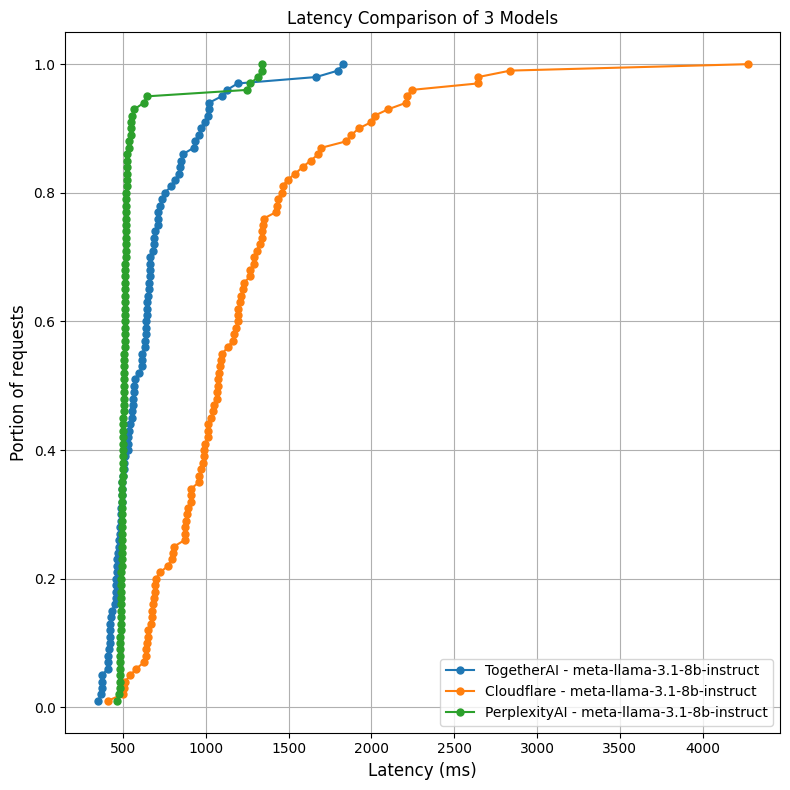

In [31]:
b.plot_metrics(b.timetofirsttoken)

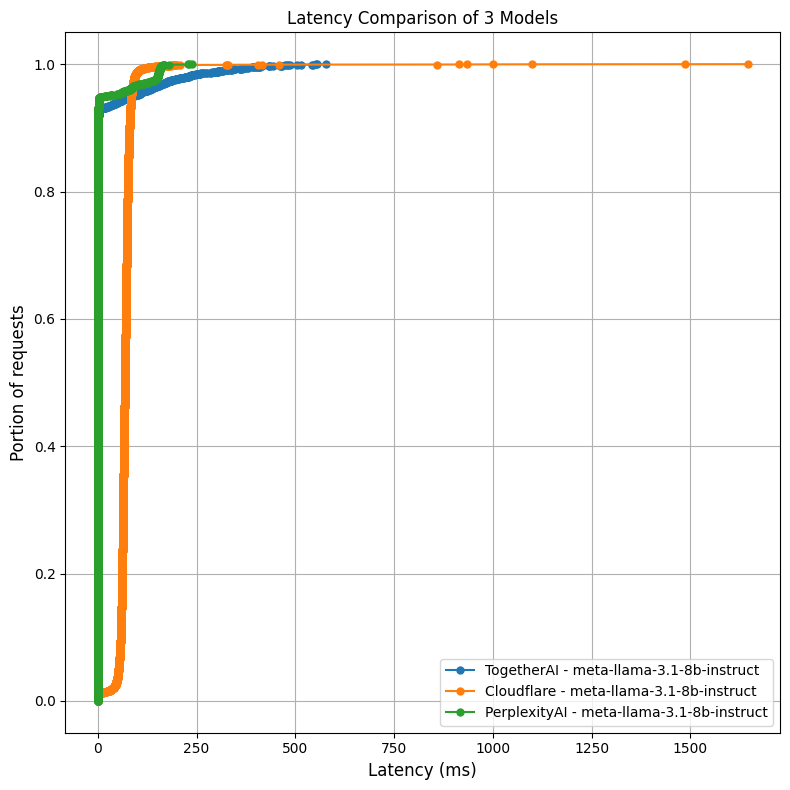

In [32]:
# Time between tokens
b.plot_metrics(b.timebetweentokens)

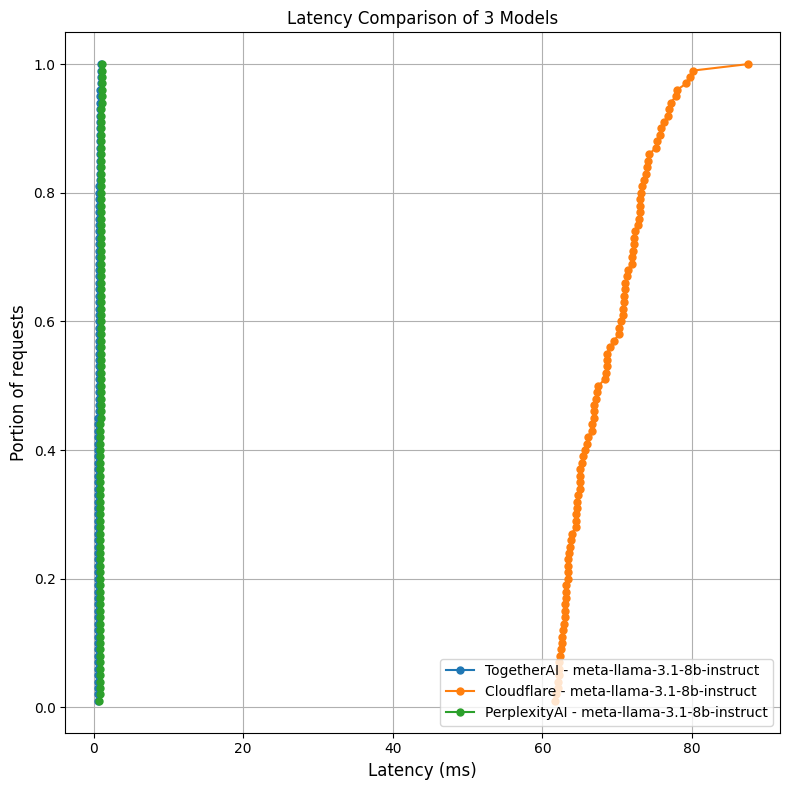

In [33]:
b.plot_metrics(b.timebetweentokens_median)

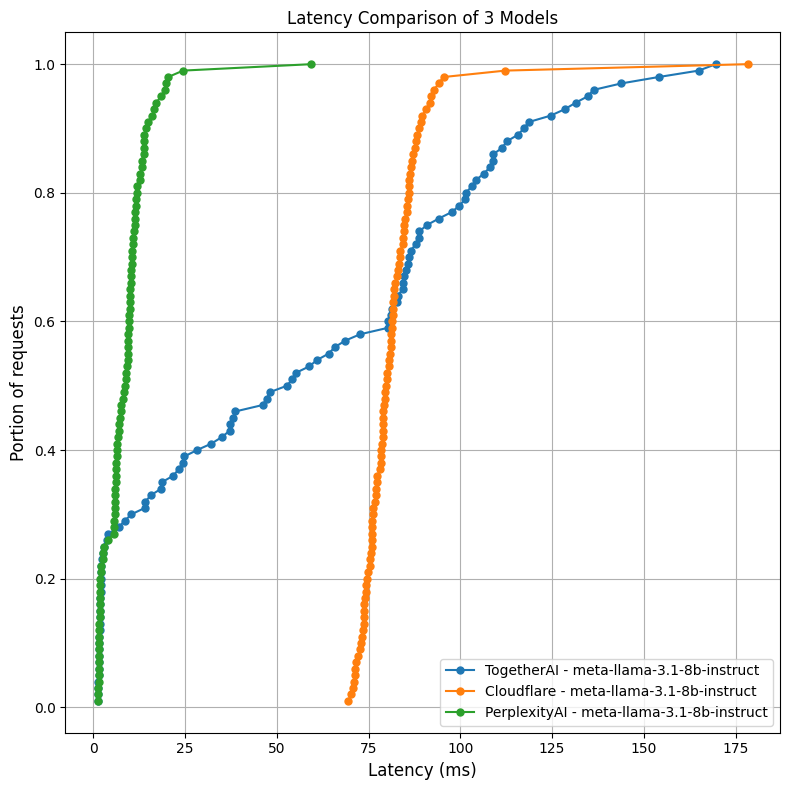

In [34]:
b.plot_metrics(b.timebetweentokens_p95)

### Perplexity AI benchmark for 3 diff models

In [38]:
# TTFT and TBT also do for 3 different models
# End to end response times for each provider, 3 different models
prompt = "What are some fun things to do in New York? Give me 1 short example."
models = ["meta-llama-3.1-8b-instruct", "meta-llama-3.1-70b-instruct","meta-llama-3.1-sonar-405B"]

b = Benchmark([PerplexityAI()], 50, models=models, prompt=prompt)
b.run()

##### PerplexityAI

##### Model: meta-llama-3.1-8b-instruct
 ##### Prompt: What are some fun things to do in New York? Give me 1 short example.

Request 0

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some photos. It's a classic NYC experience that's free and accessible to all!

Would you like more ideas?

##### _Generated in *0.82* seconds_

Request 1

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. The bridge is a popular spot for tourists and locals alike, and the walk is about 1.1 miles each way. You can stop at the Brooklyn Bridge Park on the other side for some great food and drink options, or continue on to explore the trendy neighborhoods of Brooklyn.

##### _Generated in *1.13* seconds_

Request 2

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential NYC adventure

##### _Generated in *0.75* seconds_

Request 3

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on the other side for a picnic or to grab a bite to eat. It's a great way to experience the city's energy and take in the sights and sounds of the bustling metropolis.

##### _Generated in *0.78* seconds_

Request 4

Here's a short example:

**Take a stroll through Central Park**: This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Loeb Boathouse, the Bethesda Fountain, or the Conservatory Garden. It's a great way to experience the beauty of nature in the heart of New York City

##### _Generated in *1.71* seconds_

Request 5

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can start in Brooklyn and walk to Manhattan, or vice versa. It's a great way to experience the city's energy and take in some amazing views. Plus, it's a great spot for photos

##### _Generated in *0.77* seconds_

Request 6

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across this iconic bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on the other side for some great food, drinks, and people-watching. It's a fun and free activity that's perfect for a sunny day in the city

##### _Generated in *0.84* seconds_

Request 7

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a classic New York experience that's free and fun for all ages

##### _Generated in *0.76* seconds_

Request 8

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some photos. It's a classic New York experience that's free and fun for all ages

##### _Generated in *0.74* seconds_

Request 9

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential New York City experience

##### _Generated in *0.81* seconds_

Request 10

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. You can also stop at the Brooklyn Bridge Park on the other side for a picnic or a visit to the Brooklyn Bridge Park's playgrounds and gardens.

##### _Generated in *0.71* seconds_

Request 11

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across this iconic bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on the other side for a picnic or to explore the waterfront. It's a free and exhilarating experience that's sure to give you a taste of the city's energy and beauty

##### _Generated in *0.81* seconds_

Request 12

Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Enjoy breathtaking views of the Manhattan skyline, the East River, and Brooklyn while walking across this iconic bridge. You can stop at the Brooklyn Bridge Park on the other side for great food, drinks, and people-watching. It's a classic NYC experience

##### _Generated in *0.71* seconds_

Request 13

Here's a short example:

**Take a stroll through Central Park**: Walk through the beautiful gardens, visit the Bethesda Fountain, and enjoy the scenery of this iconic 843-acre park in the middle of Manhattan. You can also rent a bike, have a picnic, or attend a free concert or movie screening in the park during the summer months.

Would you like more ideas?

##### _Generated in *0.72* seconds_

Request 14

Here's a short example:

**Take a stroll through Central Park**: This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse. It's a great way to experience the beauty of nature in the heart of New York City

##### _Generated in *0.85* seconds_

Request 15

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on either side for food, drinks, and people-watching. It's a classic New York experience that's free and accessible to everyone

##### _Generated in *0.76* seconds_

Request 16

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on the other side for some great food, drinks, and people-watching. It's a classic NYC experience that's free and fun for all ages

##### _Generated in *0.72* seconds_

Request 17

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway and take in the sights, snap some photos, and enjoy the lively atmosphere of the surrounding neighborhoods. It's a classic New York experience that's free and easily accessible

##### _Generated in *0.78* seconds_

Request 18

Here's a short example:

**Take a stroll across the Brooklyn Bridge**: This iconic bridge offers breathtaking views of the Manhattan skyline, the East River, and Brooklyn. You can walk or bike across the bridge, and stop at the Brooklyn Bridge Park on the other side for food, drinks, and great views.

There are countless other fun things to do in New York, but this is just one example to get you started

##### _Generated in *0.79* seconds_

Request 19

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential NYC adventure

##### _Generated in *0.75* seconds_

Request 20

Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Enjoy breathtaking views of the Manhattan skyline, the East River, and Brooklyn while walking across this iconic bridge. You can stop at the Brooklyn Bridge Park on the other side for great food, drinks, and people-watching.

##### _Generated in *0.67* seconds_

Request 21

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can also stop at the Brooklyn Bridge Park on the other side for a picnic or some street food. It's a classic NYC experience that's free and fun for all ages

##### _Generated in *0.74* seconds_

Request 22

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential NYC adventure

##### _Generated in *0.75* seconds_

Request 23

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on the other side for a picnic or to explore the shops and restaurants. It's a free and exhilarating experience that's a quintessential NYC experience

##### _Generated in *0.72* seconds_

Request 24

Here's a short example:

**Take a stroll across the Brooklyn Bridge**: This iconic bridge offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can walk or bike across the bridge, and stop at the Brooklyn Bridge Park on the other side for great food, drinks, and people-watching.

Would you like more ideas?

##### _Generated in *0.70* seconds_

Request 25

Here's a short example of a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on the other side for a picnic or to explore the waterfront. It's a free and iconic experience that's perfect for a day trip or a romantic evening walk.

##### _Generated in *0.84* seconds_

Request 26

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and enjoy the street performers and vendors along the way. It's a classic New York experience that's free and accessible to everyone

##### _Generated in *0.77* seconds_

Request 27

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the Brooklyn Bridge Park on the other side for a picnic or to explore the waterfront. It's a free and exhilarating experience that's a quintessential NYC experience

##### _Generated in *0.74* seconds_

Request 28

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential NYC experience

##### _Generated in *0.74* seconds_

Request 29

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a classic NYC experience that's free and fun for all ages

##### _Generated in *0.73* seconds_

Request 30

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway and take in the sights, snap photos, and enjoy the lively atmosphere. It's a free and easy activity that's perfect for a day trip or a romantic evening stroll.

##### _Generated in *0.79* seconds_

Request 31

Here's a short example:

**Take a stroll through Central Park**: Walk through the beautiful gardens, visit the Bethesda Fountain, and rent a bike or take a leisurely walk through the park. You can also visit the Central Park Zoo, play a game of chess with a stranger at the famous chess tables, or attend a free concert or movie screening during the summer months.

##### _Generated in *0.73* seconds_

Request 32

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a must-do for any New York visitor

##### _Generated in *0.78* seconds_

Request 33

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can also stop at the Brooklyn Bridge Park on the other side for some great food, drinks, and people-watching. It's a classic New York experience that's free and fun for all ages

##### _Generated in *0.77* seconds_

Request 34

Here's a short example of a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. The bridge is pedestrian-friendly and offers a unique perspective on the city. You can also stop at the Brooklyn Bridge Park on the other side for food, drinks, and great views.

##### _Generated in *0.78* seconds_

Request 35

Here's a short example:

**Take a stroll across the Brooklyn Bridge**: This iconic bridge offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can walk or bike across the bridge, and stop at the Brooklyn Bridge Park on the other side for a picnic or to explore the waterfront. It's a classic New York experience that's free and fun for all ages

##### _Generated in *0.75* seconds_

Request 36

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential NYC adventure

##### _Generated in *0.75* seconds_

Request 37

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential NYC adventure

##### _Generated in *0.74* seconds_

Request 38

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential NYC adventure

##### _Generated in *0.78* seconds_

Request 39

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across this iconic bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on the other side for a picnic or to take in the views of the city. It's a free and exhilarating experience that's a quintessential NYC experience

##### _Generated in *0.80* seconds_

Request 40

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a classic NYC experience that's free and accessible to everyone

##### _Generated in *0.71* seconds_

Request 41

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. The bridge is especially beautiful at sunset or twilight, when the city lights start to twinkle. It's a free and easy activity that's perfect for couples, friends, or solo travelers.

##### _Generated in *0.75* seconds_

Request 42

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway and take in the sights and sounds of the city, or continue on to explore the trendy neighborhoods of Brooklyn, such as DUMBO and Williamsburg.

##### _Generated in *0.76* seconds_

Request 43

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential NYC adventure

##### _Generated in *0.76* seconds_

Request 44

Here's a short example:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a free and exhilarating experience that's perfect for a sunny day or a romantic evening.

##### _Generated in *0.60* seconds_

Request 45

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some photos. It's a free and exhilarating experience that's a quintessential New York experience

##### _Generated in *0.73* seconds_

Request 46

Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on the other side for some great food and drink options, or continue on to explore Brooklyn's trendy neighborhoods like DUMBO and Williamsburg.

##### _Generated in *0.77* seconds_

Request 47

Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some photos. It's a classic New York experience that's free and accessible to everyone.

##### _Generated in *0.72* seconds_

Request 48

The city that never sleeps Here's a short example of a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, which is open 24/7, and take in the sights and sounds of the city. It's a great way to experience the energy and excitement of New York City

##### _Generated in *0.87* seconds_

Request 49

Here's a short example:

**Take a stroll through Central Park**

Walk through the beautiful gardens, visit the Bethesda Fountain, and rent a bike or boat to enjoy the scenery. You can also attend a free concert or movie in the park during the summer months. It's a quintessential New York experience that's free and fun for all ages

##### _Generated in *0.69* seconds_

##### Model: meta-llama-3.1-70b-instruct
 ##### Prompt: What are some fun things to do in New York? Give me 1 short example.

Request 0

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a classic NYC experience that's free and open to the public.

##### _Generated in *1.38* seconds_

Request 1

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: This iconic bridge offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can walk or bike across the bridge and take in the sights and sounds of the city. It's a classic NYC experience

##### _Generated in *1.57* seconds_

Request 2

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Enjoy spectacular views of the Manhattan skyline, the East River, and Brooklyn while walking across this iconic bridge. It's a great way to experience the city's energy and take in some amazing photo ops

##### _Generated in *1.40* seconds_

Request 3

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a classic NYC experience that's free and open to the public 24/7

##### _Generated in *1.41* seconds_

Request 4

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a great way to experience the city's energy and take in some amazing photo ops

##### _Generated in *2.24* seconds_

Request 5

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Enjoy spectacular views of the Manhattan skyline, the East River, and Brooklyn while walking across this iconic bridge. It's a classic NYC experience that's free and open to the public 24/7

##### _Generated in *1.57* seconds_

Request 6

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a classic NYC experience that's free and open to the public.

##### _Generated in *1.47* seconds_

Request 7

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a classic NYC experience that's free and open to the public 24/7

##### _Generated in *1.55* seconds_

Request 8

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Enjoy spectacular views of the Manhattan skyline, the East River, and Brooklyn while walking across this iconic bridge. It's a classic NYC experience that's free and open to the public 24/7

##### _Generated in *1.56* seconds_

Request 9

The city that never sleeps Here's a short example of a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a great way to experience the city's energy and take in some amazing photo ops

##### _Generated in *1.74* seconds_

Request 10

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: This iconic bridge offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can walk or bike across the bridge and take in the sights and sounds of the city. It's a classic NYC experience that's free and open to the public

##### _Generated in *1.84* seconds_

Request 11

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Enjoy spectacular views of the Manhattan skyline, the East River, and Brooklyn while walking across this iconic bridge. It's a classic NYC experience that's free and open to the public 24/7

##### _Generated in *1.60* seconds_

Request 12

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a classic NYC experience that's free and open to the public 24/7

##### _Generated in *1.50* seconds_

Request 13

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a classic NYC experience that's free and open to the public 24/7.

##### _Generated in *2.32* seconds_

Request 14

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: This iconic bridge offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a great way to experience the city's energy and take in some amazing sights. Plus, it's free

##### _Generated in *1.63* seconds_

Request 15

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Enjoy spectacular views of the Manhattan skyline, the East River, and Brooklyn while walking across this iconic bridge. It's a classic NYC experience that's free and open to the public 24/7

##### _Generated in *1.70* seconds_

Request 16

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a great way to experience the city's energy and take in some amazing sights.

##### _Generated in *2.42* seconds_

Request 17

The city that never sleeps Here's a short example of a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a great way to experience the city's energy and take in some amazing sights.

##### _Generated in *2.50* seconds_

Request 18

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Enjoy spectacular views of the Manhattan skyline, the East River, and Brooklyn while walking across this iconic bridge. It's a great way to experience the city's energy and take in some amazing photo ops

##### _Generated in *1.58* seconds_

Request 19

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Enjoy spectacular views of the Manhattan skyline, the East River, and Brooklyn while walking across this iconic bridge. It's a classic NYC experience that's free and open to the public 24/7

##### _Generated in *1.55* seconds_

Request 20

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a classic NYC experience that's free and open to the public 24/7

##### _Generated in *2.37* seconds_

Request 21

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Enjoy spectacular views of the Manhattan skyline, the East River, and Brooklyn while walking across this iconic bridge. It's a great way to experience the city's energy and take in some amazing photo ops

##### _Generated in *1.50* seconds_

Request 22

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a classic NYC experience that's free and open to the public 24/7

##### _Generated in *1.64* seconds_

Request 23

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Enjoy spectacular views of the Manhattan skyline, the East River, and Brooklyn while walking across this iconic bridge. It's a classic NYC experience that's free and open to the public 24/7

##### _Generated in *1.86* seconds_

Request 24

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a classic NYC experience that's free and open to the public.

##### _Generated in *1.29* seconds_

Request 25

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a classic NYC experience that's free and open to the public 24/7

##### _Generated in *1.34* seconds_

Request 26

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Enjoy spectacular views of the Manhattan skyline, the East River, and Brooklyn while walking across this iconic bridge. It's a classic NYC experience that's free and open to the public 24/7

##### _Generated in *2.16* seconds_

Request 27

The city that never sleeps Here's a short example of a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a great way to experience the city's energy and take in some amazing photo ops

##### _Generated in *1.64* seconds_

Request 28

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Enjoy spectacular views of the Manhattan skyline, the East River, and Brooklyn while walking across this iconic bridge. It's a classic NYC experience that's free and open to the public

##### _Generated in *1.45* seconds_

Request 29

The city that never sleeps Here's a short example of a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a great way to experience the city's energy and take in some amazing photo ops

##### _Generated in *1.69* seconds_

Request 30

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a classic NYC experience that's free and open to the public 24/7

##### _Generated in *2.42* seconds_

Request 31

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a great way to experience the city's energy and take in some amazing photo ops

##### _Generated in *1.35* seconds_

Request 32

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a classic NYC experience that's free and open to the public 24/7

##### _Generated in *1.35* seconds_

Request 33

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a classic NYC experience that's free and open to the public.

##### _Generated in *1.54* seconds_

Request 34

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a classic NYC experience that's free and open to the public 24/7

##### _Generated in *1.60* seconds_

Request 35

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a classic NYC experience that's free and open to the public 24/7

##### _Generated in *1.34* seconds_

Request 36

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Enjoy spectacular views of the Manhattan skyline, the East River, and Brooklyn while walking across this iconic bridge. It's a classic NYC experience that's free and open to the public 24/7

##### _Generated in *2.20* seconds_

Request 37

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a classic NYC experience that's free and open to the public.

##### _Generated in *1.35* seconds_

Request 38

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: This iconic bridge offers breathtaking views of the Manhattan skyline, the East River, and Brooklyn. You can walk or bike across the bridge and take in the sights and sounds of the city. It's a classic NYC experience

##### _Generated in *1.64* seconds_

Request 39

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a classic NYC experience that's free and open to the public.

##### _Generated in *1.44* seconds_

Request 40

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a classic NYC experience that's free and open to the public 24/7

##### _Generated in *1.50* seconds_

Request 41

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a classic NYC experience that's free and open to the public 24/7

##### _Generated in *1.39* seconds_

Request 42

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a classic NYC experience that's free and open to the public 24/7

##### _Generated in *1.71* seconds_

Request 43

The city that never sleeps Here's a short example of a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a classic NYC experience that's free and open to the public 24/7.

##### _Generated in *2.41* seconds_

Request 44

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a classic NYC experience that's free and open to the public 24/7

##### _Generated in *1.58* seconds_

Request 45

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a great way to experience the city's energy and take in some amazing photo ops

##### _Generated in *1.53* seconds_

Request 46

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a classic NYC experience that's free and open to the public.

##### _Generated in *1.26* seconds_

Request 47

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a classic NYC experience that's free and open to the public 24/7

##### _Generated in *1.42* seconds_

Request 48

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a classic NYC experience that's free and open to the public.

##### _Generated in *1.26* seconds_

Request 49

The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Enjoy spectacular views of the Manhattan skyline, the East River, and Brooklyn while walking across this iconic bridge. It's a classic NYC experience that's free and open to the public 24/7

##### _Generated in *1.60* seconds_

##### Model: meta-llama-3.1-sonar-405B
 ##### Prompt: What are some fun things to do in New York? Give me 1 short example.

Request 0

One fun thing to do in New York is to **walk The High Line**. This 1.45-mile elevated park, built on an old railroad line, offers unique views of the city and the Hudson River. It's located in the Chelsea neighborhood and connects to Hudson Yards, making it a great place to explore and enjoy the city's green spaces.

##### _Generated in *5.02* seconds_

Request 1

One fun thing to do in New York is to walk across the Brooklyn Bridge. This iconic bridge offers unparalleled views of the Manhattan skyline and the East River. Starting from the Brooklyn side and walking towards Manhattan provides the best views and less initial crowds, especially during sunset when the skyline lights up.

##### _Generated in *6.39* seconds_

Request 2

One fun thing to do in New York is to walk across the **Brooklyn Bridge**. This iconic bridge offers unparalleled views of the Manhattan skyline and the East River. Starting from the Brooklyn side and walking towards Manhattan provides the best views and fewer crowds, especially during sunset when the skyline lights up.

##### _Generated in *4.35* seconds_

Request 3

One fun thing to do in New York is to walk across the **Brooklyn Bridge**. This 1.1-mile pedestrian pathway offers sweeping views and exclusive photo opportunities of the Manhattan skyline and the East River. It's a popular and iconic activity that allows you to experience the city from a unique perspective.

##### _Generated in *5.86* seconds_

Request 4

One fun thing to do in New York is to **walk across the Brooklyn Bridge**. This iconic bridge offers nonstop skyline and East River views, making it a bucket list item for many visitors. The walkway sits above the traffic, providing a unique and memorable experience.

##### _Generated in *7.17* seconds_

Request 5

One fun thing to do in New York is to **walk across the Brooklyn Bridge**. This iconic bridge offers nonstop skyline and East River views, making it a bucket list item for many visitors. Starting from the Brooklyn side and walking towards Manhattan provides the best views and fewer crowds, especially during sunset.

##### _Generated in *6.08* seconds_

Request 6

One fun thing to do in New York City is to **walk The High Line**. This 1.45-mile elevated park, built on an old railroad track, offers unique views of the city and the Hudson River. It stretches from the Hudson Yards area to the Whitney Museum, providing numerous photo opportunities and a chance to explore the Chelsea neighborhood from a different perspective.

##### _Generated in *7.07* seconds_

Request 7

One fun thing to do in New York is to **walk The High Line**. This 1.45-mile elevated park, built on an old railroad track, offers unique views of the Hudson River and the city skyline. It's a popular and free activity that allows you to explore the Chelsea neighborhood and enjoy various photo opportunities.

##### _Generated in *4.55* seconds_

Request 8

One fun thing to do in New York is to **walk the Brooklyn Bridge**. Starting from the Brooklyn side and walking towards Manhattan offers unparalleled views of the city skyline, especially during sunset when the buildings light up one by one. This activity is easy, fun, and provides a unique perspective on the city.

##### _Generated in *4.57* seconds_

Request 9

One fun thing to do in New York is to walk across the Brooklyn Bridge. This iconic bridge offers nonstop skyline and East River views, making it a bucket list item for many visitors. Starting from the Brooklyn side and walking towards Manhattan provides the best views and less initial crowds.

##### _Generated in *4.92* seconds_

Request 10

One fun thing to do in New York is to walk across the Brooklyn Bridge. The walkway offers nonstop skyline and East River views, making it a bucket list item for many people. It's a great way to experience the city's iconic landmarks and take in the bustling atmosphere.

##### _Generated in *4.05* seconds_

Request 11

One fun thing to do in New York is to walk across the Brooklyn Bridge. Starting from the Brooklyn side and walking towards Manhattan provides unparalleled views of the city skyline, especially during sunset when the buildings light up one by one.

##### _Generated in *4.58* seconds_

Request 12

One fun thing to do in New York is to **visit the Statue of Liberty and Ellis Island**. This iconic monument symbolizes freedom and hope, and a ferry tour from Battery Park allows you to explore both the Statue of Liberty and the historical Ellis Island, offering a glimpse into the fascinating history of immigration to the United States.

##### _Generated in *4.68* seconds_

Request 13

One fun thing to do in New York is to walk across the Brooklyn Bridge. This iconic bridge offers nonstop skyline and East River views, making it a bucket list item for many visitors. Starting from the Brooklyn side and walking towards Manhattan provides the best views and less crowds, especially during sunset when the Manhattan skyline lights up.

##### _Generated in *5.58* seconds_

Request 14

One fun thing to do in New York is to **walk across the Brooklyn Bridge**. This iconic bridge offers nonstop skyline and East River views, making it a bucket list item for many people. The walkway sits above the traffic, providing a unique perspective on the city.

##### _Generated in *4.31* seconds_

Request 15

One fun thing to do in New York is to **walk The High Line**. This 1.45-mile elevated park, built on an old railroad track, offers unique views of the city and connects to the Hudson Yards and the Whitney Museum. It's a great way to explore the Chelsea neighborhood and enjoy the city from a different perspective.

##### _Generated in *4.44* seconds_

Request 16

One fun thing to do in New York is to **walk across the Brooklyn Bridge**. Starting from the Brooklyn side and walking towards Manhattan offers unparalleled views of the city skyline, especially during sunset when the buildings light up one by one.

##### _Generated in *4.13* seconds_

Request 17

One fun thing to do in New York is to walk across the Brooklyn Bridge. This 1.1-mile pedestrian pathway offers sweeping views of the Manhattan skyline and exclusive photo opportunities. It's a popular and iconic activity that provides a unique perspective of the city.

##### _Generated in *6.14* seconds_

Request 18

One fun thing to do in New York City is to **walk across the Brooklyn Bridge**. Starting from the Brooklyn side and walking towards Manhattan provides stunning views of the Manhattan skyline and the East River. It's a free and iconic experience that offers unparalleled views, especially during sunset when the city lights up.

##### _Generated in *4.80* seconds_

Request 19

One fun thing to do in New York is to walk across the **Brooklyn Bridge**. This iconic bridge offers nonstop skyline and East River views, making it a must-do activity for many visitors. The walkway sits above the traffic, providing a unique perspective on the city.

##### _Generated in *4.76* seconds_

Request 20

One fun thing to do in New York is to **walk The High Line**. This 1.45-mile elevated park built on an old railroad track offers unique views of the city and connects to Hudson Yards, providing a scenic and free experience.

##### _Generated in *4.70* seconds_

Request 21

One fun thing to do in New York is to **walk the High Line**. This 1.45-mile elevated park built on an old railroad line offers unique views of the city and the Hudson River. It's a great way to experience New York's urban landscape and enjoy some green space.

##### _Generated in *4.35* seconds_

Request 22

One fun thing to do in New York is to **walk The High Line**. This 1.45-mile elevated park, built on an old railroad track, offers unique views of the city and the Hudson River. It's located in the Chelsea neighborhood and connects to the Hudson Yards, providing a variety of photo opportunities and a peaceful escape from the bustling streets below.

##### _Generated in *5.13* seconds_

Request 23

One fun thing to do in New York is to walk across the Brooklyn Bridge. Starting from the Brooklyn side and walking towards Manhattan provides stunning views of the Manhattan skyline, especially during sunset when the buildings light up one by one.

##### _Generated in *4.62* seconds_

Request 24

One fun thing to do in New York is to **walk across the Brooklyn Bridge**. This iconic bridge offers nonstop skyline and East River views, making it a bucket list item for many people. Starting from the Brooklyn side and walking towards Manhattan provides the best views and less crowds, especially during sunset when the Manhattan skyline lights up.

##### _Generated in *4.63* seconds_

Request 25

One fun thing to do in New York City is to take a ride on the Staten Island Ferry. It's completely free and offers great views of the Statue of Liberty and the New York Harbor. The ferry runs 24/7 and takes about 25 minutes each way, making it a convenient and accessible activity for tourists and locals alike.

##### _Generated in *5.06* seconds_

Request 26

One fun thing to do in New York City is to **walk across the Brooklyn Bridge**. This iconic bridge offers nonstop skyline and East River views, making it a bucket list item for many visitors. The walkway sits above the traffic, providing a unique and memorable experience.

##### _Generated in *3.81* seconds_

Request 27

One fun thing to do in New York is to **walk across the Brooklyn Bridge**. Starting from the Brooklyn side and walking towards Manhattan offers unparalleled views of the city skyline, especially during sunset when the buildings light up one by one. This activity is free, easy to do, and provides a unique perspective on the city's architecture and landscape.

##### _Generated in *6.25* seconds_

Request 28

One fun thing to do in New York is to **walk across the Brooklyn Bridge**. This iconic bridge offers stunning skyline and East River views, making it a must-do experience for many visitors. Starting from the Brooklyn side and walking towards Manhattan provides less crowded and more enjoyable views, especially during sunset.

##### _Generated in *5.56* seconds_

Request 29

One fun thing to do in New York is to **walk across the Brooklyn Bridge**. Starting from the Brooklyn side and walking towards Manhattan offers stunning views of the Manhattan skyline, especially during sunset. This activity is free and provides a unique perspective on the city's iconic landmarks.

##### _Generated in *4.28* seconds_

Request 30

One fun thing to do in New York City is to walk across the Brooklyn Bridge. This iconic bridge offers nonstop skyline and East River views, making it a bucket list item for many people. The walkway sits above the traffic, providing a unique and memorable experience.

##### _Generated in *4.81* seconds_

Request 31

New York City is a vibrant and diverse place with countless activities to enjoy. Here's a quick example:

1. **Visit the Statue of Liberty**: Take a ferry to Liberty Island to see the iconic Statue of Liberty up close. You can also visit the Ellis Island Immigration Museum to learn about the history of immigration in the United States.

There are many more adventures to explore in New York, from world-class museums to Broadway shows and from Central Park to the bustling streets of Manhattan. Let me know if you'd like more suggestions

##### _Generated in *6.69* seconds_

Request 32

One fun thing to do in New York is to **walk The High Line**. This 1.45-mile elevated park built on an old railroad line offers unique views of the city and connects to Hudson Yards, providing a unique urban experience.

##### _Generated in *5.20* seconds_

Request 33

One fun thing to do in New York is to walk across the Brooklyn Bridge. This iconic bridge offers unparalleled views of the Manhattan skyline and the East River. Starting from the Brooklyn side and walking towards Manhattan provides the best views and fewer crowds, especially during sunset when the skyline lights up.

##### _Generated in *9.32* seconds_

Request 34

One fun thing to do in New York is to **walk across the Brooklyn Bridge**. This iconic bridge offers nonstop skyline and East River views, making it a bucket list item for many visitors. The walkway sits above the traffic, providing a unique and memorable experience.

##### _Generated in *5.18* seconds_

Request 35

One fun thing to do in New York is to take the Staten Island Ferry, which offers great views of the Statue of Liberty and is free. The ferry runs 24/7 and provides a unique perspective on the city's skyline and harbor.

##### _Generated in *4.35* seconds_

Request 36

One fun thing to do in New York is to **take a walk across the Brooklyn Bridge**. This iconic bridge offers nonstop skyline and East River views, making it a bucket list item for many visitors. The walkway sits above the traffic, providing a unique and memorable experience.

##### _Generated in *5.35* seconds_

Request 37

One fun thing to do in New York is to walk across the Brooklyn Bridge. Starting from the Brooklyn side and walking towards Manhattan provides unparalleled views of the Manhattan skyline, especially during sunset when the city lights up.

##### _Generated in *3.33* seconds_

Request 38

One fun thing to do in New York is to walk across the Brooklyn Bridge. This iconic bridge offers unparalleled views of the Manhattan skyline and the East River. Starting from the Brooklyn side and walking towards Manhattan provides the best views and less crowds, especially during sunset when the skyline lights up.

##### _Generated in *3.41* seconds_

Request 39

One fun thing to do in New York is to **visit the Statue of Liberty**. You can take a ferry from Battery Park to see this iconic monument up close and also visit Ellis Island to learn about the history of immigration in the United States.

##### _Generated in *3.97* seconds_

Request 40

One fun thing to do in New York is to walk across the Brooklyn Bridge. This 1.1-mile pedestrian pathway offers sweeping views of the Manhattan skyline and exclusive photo opportunities. Starting from the Brooklyn side and walking towards Manhattan can provide less crowded and more enjoyable views, especially during sunset when the skyline lights up.

##### _Generated in *10.50* seconds_

Request 41

One fun thing to do in New York is to **walk The High Line**. This 1.45-mile elevated park, built on an old railroad line, offers unique views of the city, gardens, art installations, and performances. It runs from Gansevoort Street to 34th Street, connecting to Hudson Yards and providing a unique perspective on Manhattan.

##### _Generated in *5.88* seconds_

Request 42

One fun thing to do in New York is to walk across the Brooklyn Bridge. This iconic bridge offers nonstop skyline and East River views, making it a bucket list item for many people. Starting from the Brooklyn side and walking towards Manhattan provides less crowded and more enjoyable scenery, especially during sunset.

##### _Generated in *4.33* seconds_

Request 43

One fun thing to do in New York is to walk across the Brooklyn Bridge. This iconic bridge offers nonstop skyline and East River views, making it a bucket list item for many visitors. Starting from the Brooklyn side and walking towards Manhattan provides the best views and less crowds, especially during sunset.

##### _Generated in *5.03* seconds_

Request 44

One fun thing to do in New York is to walk across the **Brooklyn Bridge**. This iconic bridge offers nonstop skyline and East River views, making it a bucket list item for many visitors. The walkway sits above the traffic, providing a unique and memorable experience.

##### _Generated in *5.25* seconds_

Request 45

One fun thing to do in New York City is to **walk the Brooklyn Bridge**. Starting from the Brooklyn side and walking towards Manhattan offers unparalleled views of the city skyline, especially during sunset when the buildings light up one by one. This activity is free and provides a unique perspective on the city's architecture and landscape.

##### _Generated in *3.88* seconds_

Request 46

One fun thing to do in New York is to **walk The High Line**. This 1.45-mile elevated park built on an old railroad track offers unique views of the city and connects to the Hudson Yards. It's a great way to experience the city's green spaces and enjoy the scenery.

##### _Generated in *3.79* seconds_

Request 47

One fun thing to do in New York is to walk **The High Line**. This 1.45-mile elevated park built on an old railroad line offers unique views of the city, gardens, art installations, and various food options. It runs from Gansevoort Street to 34th Street and is a great way to experience the city from a different perspective.

##### _Generated in *4.47* seconds_

Request 48

One fun thing to do in New York is to walk across the Brooklyn Bridge. This iconic bridge offers stunning skyline and East River views, making it a must-do experience for many visitors. Starting from the Brooklyn side and walking towards Manhattan provides the best views and less crowds, especially during sunset.

##### _Generated in *4.40* seconds_

Request 49

One fun thing to do in New York is to take a ride on the Staten Island Ferry. It's free, runs 24/7, and offers great views of the Statue of Liberty and Lower Manhattan. The trip lasts about 25 minutes each way, making it a quick and accessible activity for tourists and locals alike.

##### _Generated in *5.48* seconds_

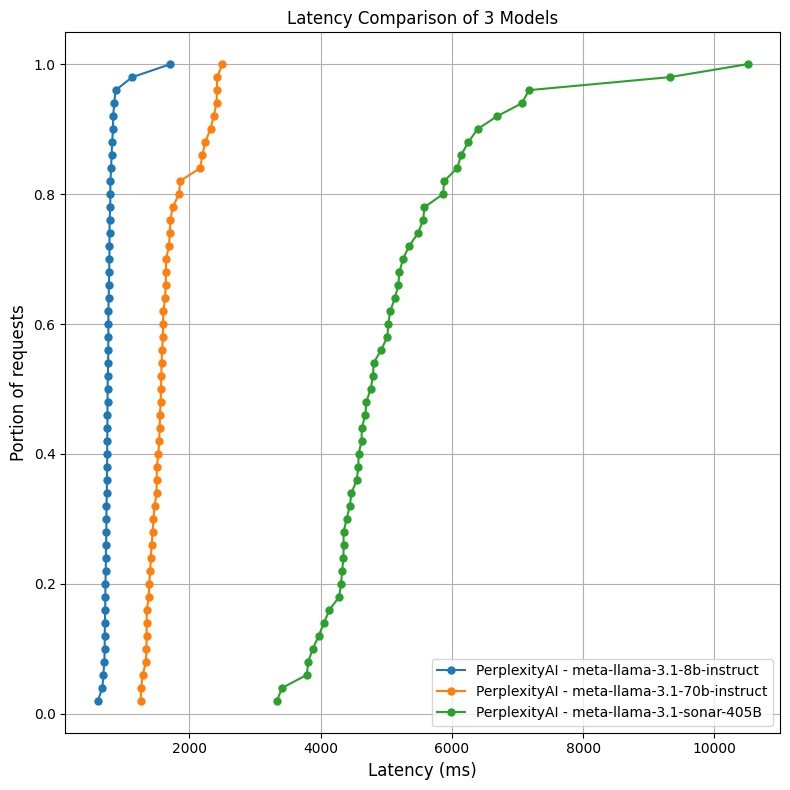

In [39]:
b.plot_metrics(b.response_times)

In [6]:
# TTFT and TBT also do for 3 different models
# End to end response times for each provider, 3 different models
prompt = "What are some fun things to do in New York? Give me 1 short example."
models = ["meta-llama-3.1-8b-instruct", "meta-llama-3.1-70b-instruct","meta-llama-3.1-sonar-405B"]

b = Benchmark([PerplexityAI()], 50, models=models, prompt=prompt,streaming=True)
b.run()

##### PerplexityAI

##### Model: meta-llama-3.1-8b-instruct
 ##### Prompt: What are some fun things to do in New York? Give me 1 short example.

Request 0

##### Time to First Token (TTFT): 0.6895 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and the Brooklyn Bridge Park. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some photos. It's a free and easy activity that's perfect for a sunny day or a romantic evening stroll

##### Total Response Time: 1.0125 seconds

##### Number of output tokens/chunks: 42

Request 1

##### Time to First Token (TTFT): 0.5038 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some photos. It's a free and fun activity that's perfect for a sunny day

##### Total Response Time: 0.7508 seconds

##### Number of output tokens/chunks: 38

Request 2

##### Time to First Token (TTFT): 0.4866 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential New York City experience

##### Total Response Time: 0.7866 seconds

##### Number of output tokens/chunks: 42

Request 3

##### Time to First Token (TTFT): 0.5476 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across this iconic bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on the other side for some great food, drinks, and people-watching. It's a classic NYC experience that's free and fun for all ages

##### Total Response Time: 0.8298 seconds

##### Number of output tokens/chunks: 39

Request 4

##### Time to First Token (TTFT): 1.3099 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a classic New York experience that's free and accessible to all

##### Total Response Time: 1.5986 seconds

##### Number of output tokens/chunks: 40

Request 5

##### Time to First Token (TTFT): 0.5338 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on the other side for some great food, drinks, and people-watching. It's a classic NYC experience that's free and fun for all ages

##### Total Response Time: 0.8187 seconds

##### Number of output tokens/chunks: 40

Request 6

##### Time to First Token (TTFT): 0.4940 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**: This iconic bridge offers breathtaking views of the Manhattan skyline, the East River, and Brooklyn. You can walk or bike across the bridge, and stop at the Brooklyn Bridge Park on the other side for food, drinks, and great views.

Want more ideas

##### Total Response Time: 0.6926 seconds

##### Number of output tokens/chunks: 34

Request 7

##### Time to First Token (TTFT): 1.2991 seconds


The city that never sleeps Here's a short example of a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's sure to leave you with lifelong memories

##### Total Response Time: 1.6869 seconds

##### Number of output tokens/chunks: 49

Request 8

##### Time to First Token (TTFT): 0.4961 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a classic New York experience that's free and accessible to all

##### Total Response Time: 0.7765 seconds

##### Number of output tokens/chunks: 40

Request 9

##### Time to First Token (TTFT): 0.4963 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on the other side for a picnic or to explore the waterfront. It's a fun and free activity that's perfect for a sunny day

##### Total Response Time: 0.7542 seconds

##### Number of output tokens/chunks: 38

Request 10

##### Time to First Token (TTFT): 0.5124 seconds


Here's a short example:

**Take a stroll through Central Park**: This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse. It's a great way to experience the beauty of nature in the heart of New York City

##### Total Response Time: 0.8604 seconds

##### Number of output tokens/chunks: 46

Request 11

##### Time to First Token (TTFT): 0.6933 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and thrilling experience that's a must-do for any visitor to New York City

##### Total Response Time: 0.9839 seconds

##### Number of output tokens/chunks: 43

Request 12

##### Time to First Token (TTFT): 0.4994 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a classic NYC experience that's free and accessible to everyone

##### Total Response Time: 0.7742 seconds

##### Number of output tokens/chunks: 40

Request 13

##### Time to First Token (TTFT): 1.3210 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on either side for a picnic or to take in the sights. It's a free and iconic NYC experience that's perfect for a sunny day or a romantic evening.

##### Total Response Time: 1.6098 seconds

##### Number of output tokens/chunks: 41

Request 14

##### Time to First Token (TTFT): 0.6665 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across this iconic bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on the other side for a picnic or to explore the waterfront. It's a free and exhilarating experience that's perfect for a sunny day

##### Total Response Time: 0.9169 seconds

##### Number of output tokens/chunks: 38

Request 15

##### Time to First Token (TTFT): 0.4910 seconds


Here's a short example:

**Take a stroll through Central Park**

Walk through the beautiful gardens, visit the Bethesda Fountain, and enjoy the scenery of this iconic 843-acre park in the middle of Manhattan. You can also rent a bike, have a picnic, or attend a free concert or movie screening in the park during the summer months. It's a quintessential New York experience

##### Total Response Time: 0.7838 seconds

##### Number of output tokens/chunks: 40

Request 16

##### Time to First Token (TTFT): 0.5107 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some photos. It's a free and fun activity that's perfect for a sunny day in New York City

##### Total Response Time: 0.7861 seconds

##### Number of output tokens/chunks: 40

Request 17

##### Time to First Token (TTFT): 0.5091 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some photos. It's a free and exhilarating experience that's a quintessential NYC experience

##### Total Response Time: 0.7747 seconds

##### Number of output tokens/chunks: 39

Request 18

##### Time to First Token (TTFT): 0.5132 seconds


Here's a short example of a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. The bridge is pedestrian-friendly and offers a unique perspective on the city. You can stop at the Brooklyn Bridge Park on the other side for food, drinks, and more great views.

##### Total Response Time: 0.8056 seconds

##### Number of output tokens/chunks: 42

Request 19

##### Time to First Token (TTFT): 1.2874 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some photos. It's a classic New York experience that's free and fun for all ages

##### Total Response Time: 1.5687 seconds

##### Number of output tokens/chunks: 39

Request 20

##### Time to First Token (TTFT): 0.5292 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential NYC experience

##### Total Response Time: 0.8575 seconds

##### Number of output tokens/chunks: 41

Request 21

##### Time to First Token (TTFT): 0.5070 seconds


Here's a short example:

**Take a stroll through Central Park**

Walk through the beautiful gardens, visit the Bethesda Fountain, and enjoy the scenery of this iconic 843-acre park in the middle of Manhattan. You can also rent a bike, have a picnic, or attend a free concert or event during the summer months. It's a quintessential New York experience

##### Total Response Time: 0.7735 seconds

##### Number of output tokens/chunks: 38

Request 22

##### Time to First Token (TTFT): 0.5131 seconds


Here's a short example of a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential NYC experience

##### Total Response Time: 0.8234 seconds

##### Number of output tokens/chunks: 44

Request 23

##### Time to First Token (TTFT): 0.5244 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a classic New York experience that's free and fun for all ages

##### Total Response Time: 0.8081 seconds

##### Number of output tokens/chunks: 41

Request 24

##### Time to First Token (TTFT): 0.4887 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential NYC experience

##### Total Response Time: 0.7750 seconds

##### Number of output tokens/chunks: 41

Request 25

##### Time to First Token (TTFT): 0.5073 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**: This iconic bridge offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can walk or bike across the bridge, and stop at the Brooklyn Bridge Park on the other side for some great food and drink options. It's a classic NYC experience that's free and fun for all ages

##### Total Response Time: 0.7759 seconds

##### Number of output tokens/chunks: 39

Request 26

##### Time to First Token (TTFT): 0.4982 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some photos. It's a classic New York experience that's free and fun

##### Total Response Time: 0.7336 seconds

##### Number of output tokens/chunks: 37

Request 27

##### Time to First Token (TTFT): 0.4887 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. The bridge is especially beautiful at sunset or twilight, when the city lights start to twinkle. It's a free and easy activity that's perfect for couples, friends, or solo travelers.

##### Total Response Time: 0.7703 seconds

##### Number of output tokens/chunks: 41

Request 28

##### Time to First Token (TTFT): 1.2227 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential NYC experience

##### Total Response Time: 1.5158 seconds

##### Number of output tokens/chunks: 41

Request 29

##### Time to First Token (TTFT): 0.4925 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can also stop at the Brooklyn Bridge Park on the other side for a picnic or some people-watching. It's a free and exhilarating experience that's sure to give you a taste of the city's energy and charm

##### Total Response Time: 0.8130 seconds

##### Number of output tokens/chunks: 45

Request 30

##### Time to First Token (TTFT): 0.5737 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. The bridge is especially beautiful at sunset or twilight, when the city lights start to twinkle. It's a free and invigorating experience that's a must-do for any New York visitor

##### Total Response Time: 0.8516 seconds

##### Number of output tokens/chunks: 41

Request 31

##### Time to First Token (TTFT): 0.4872 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the Brooklyn Bridge Park on the other side for some great food, drinks, and people-watching. It's a classic NYC experience that's free and fun for all ages

##### Total Response Time: 0.7762 seconds

##### Number of output tokens/chunks: 41

Request 32

##### Time to First Token (TTFT): 0.4789 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**: This iconic bridge offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can walk or bike across the bridge, and stop at the Brooklyn Bridge Park on the other side for food, drinks, and great views. It's a classic NYC experience that's free and fun for all ages

##### Total Response Time: 0.7540 seconds

##### Number of output tokens/chunks: 40

Request 33

##### Time to First Token (TTFT): 1.3437 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can start in Brooklyn and end in Manhattan, or vice versa. It's a free and invigorating experience that's perfect for a sunny day or a romantic evening

##### Total Response Time: 1.6573 seconds

##### Number of output tokens/chunks: 39

Request 34

##### Time to First Token (TTFT): 0.4998 seconds


Here's a short example:

**Take a stroll through Central Park**: This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and Loeb Boathouse. It's a great way to experience the beauty of nature in the heart of New York City

##### Total Response Time: 0.8351 seconds

##### Number of output tokens/chunks: 45

Request 35

##### Time to First Token (TTFT): 0.4951 seconds


Here's a short example of a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential NYC experience

##### Total Response Time: 0.8108 seconds

##### Number of output tokens/chunks: 44

Request 36

##### Time to First Token (TTFT): 0.6577 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a classic New York experience that's free and accessible to everyone

##### Total Response Time: 0.9256 seconds

##### Number of output tokens/chunks: 39

Request 37

##### Time to First Token (TTFT): 0.5181 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across this iconic bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on the other side for a picnic or a visit to the Brooklyn Bridge Park's playgrounds and gardens. It's a fun and free activity that's perfect for a day out in the city

##### Total Response Time: 0.8178 seconds

##### Number of output tokens/chunks: 43

Request 38

##### Time to First Token (TTFT): 0.5055 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's a quintessential NYC adventure

##### Total Response Time: 0.7724 seconds

##### Number of output tokens/chunks: 41

Request 39

##### Time to First Token (TTFT): 0.5039 seconds


Here's a short example:

**Take a stroll through Central Park**: This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. You can walk through the park, rent a bike, have a picnic, or visit famous landmarks like the Bethesda Fountain and the Loeb Boathouse. It's a great way to experience the beauty of nature in the heart of New York City

##### Total Response Time: 0.8626 seconds

##### Number of output tokens/chunks: 46

Request 40

##### Time to First Token (TTFT): 0.4957 seconds


Here's a short example:

**Take a stroll through Central Park**

Walk through the beautiful gardens, visit the Bethesda Fountain, and enjoy the street performers and live music in the park. You can also rent a bike and ride through the park, or have a picnic on the Great Lawn. It's a classic New York experience that's free and fun for all ages

##### Total Response Time: 0.7797 seconds

##### Number of output tokens/chunks: 38

Request 41

##### Time to First Token (TTFT): 0.5073 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**: This iconic bridge offers breathtaking views of the Manhattan skyline, the East River, and Brooklyn. You can walk or bike across the bridge, and stop at the Brooklyn Bridge Park on the other side for food, drinks, and great views.

Would you like more ideas

##### Total Response Time: 0.7164 seconds

##### Number of output tokens/chunks: 35

Request 42

##### Time to First Token (TTFT): 0.5156 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can also stop at the Brooklyn Bridge Park on the other side for a picnic or some people-watching. It's a free and exhilarating experience that's a quintessential NYC experience

##### Total Response Time: 0.8155 seconds

##### Number of output tokens/chunks: 41

Request 43

##### Time to First Token (TTFT): 0.4903 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the Brooklyn Bridge Park on the other side for a picnic or to grab a bite to eat. It's a fun and free activity that's perfect for a sunny day in the city

##### Total Response Time: 0.7913 seconds

##### Number of output tokens/chunks: 41

Request 44

##### Time to First Token (TTFT): 0.5126 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the Brooklyn Bridge Park on the other side for a picnic or to grab a bite to eat. It's a free and exhilarating experience that's a quintessential NYC experience

##### Total Response Time: 0.8036 seconds

##### Number of output tokens/chunks: 41

Request 45

##### Time to First Token (TTFT): 0.4881 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a classic NYC experience that's free and accessible to everyone

##### Total Response Time: 0.7803 seconds

##### Number of output tokens/chunks: 40

Request 46

##### Time to First Token (TTFT): 0.4931 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers stunning views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some photos. It's a classic NYC experience that's free and accessible to everyone

##### Total Response Time: 0.7260 seconds

##### Number of output tokens/chunks: 38

Request 47

##### Time to First Token (TTFT): 0.6464 seconds


The city that never sleeps Here's a short example of a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers breathtaking views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and exhilarating experience that's perfect for a sunny day or a romantic evening stroll.

##### Total Response Time: 1.0333 seconds

##### Number of output tokens/chunks: 51

Request 48

##### Time to First Token (TTFT): 0.4979 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a free and fun activity that's perfect for a day out in the city

##### Total Response Time: 0.7955 seconds

##### Number of output tokens/chunks: 40

Request 49

##### Time to First Token (TTFT): 0.4904 seconds


Here's a short example:

**Take a stroll across the Brooklyn Bridge**

Walk across the iconic Brooklyn Bridge, which offers spectacular views of the Manhattan skyline, the East River, and the Statue of Liberty. You can stop at the bridge's pedestrian walkway, take in the sights, and snap some amazing photos. It's a classic New York experience that's free and fun for all ages

##### Total Response Time: 0.7969 seconds

##### Number of output tokens/chunks: 41

##### Model: meta-llama-3.1-70b-instruct
 ##### Prompt: What are some fun things to do in New York? Give me 1 short example.

Request 0

##### Time to First Token (TTFT): 0.4831 seconds


The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a great way to experience the city's energy and take in some amazing photo ops

##### Total Response Time: 1.5799 seconds

##### Number of output tokens/chunks: 34

Request 1

##### Time to First Token (TTFT): 1.3646 seconds


The city that never sleeps Here's a short example of a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a classic NYC experience that's free and open to the public 24/7

##### Total Response Time: 2.6253 seconds

##### Number of output tokens/chunks: 36

Request 2

##### Time to First Token (TTFT): 0.5030 seconds


The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: This iconic bridge offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can walk or bike across the bridge and take in the sights and sounds of the city. It's a classic NYC experience

##### Total Response Time: 1.7218 seconds

##### Number of output tokens/chunks: 36

Request 3

##### Time to First Token (TTFT): 0.5028 seconds


The city that never sleeps Here's a short example of a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a great way to experience the city's energy and take in some amazing photo ops

##### Total Response Time: 1.7393 seconds

##### Number of output tokens/chunks: 36

Request 4

##### Time to First Token (TTFT): 0.5240 seconds


The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll through Central Park**: This 843-acre green oasis in the middle of Manhattan offers a peaceful escape from the hustle and bustle of the city. Walk through the park, rent a bike, or have a picnic on the Great Lawn. You can also visit famous spots like the Bethesda Fountain, Loeb Boathouse, and the Conservatory Garden.

##### Total Response Time: 3.1097 seconds

##### Number of output tokens/chunks: 47

Request 5

##### Time to First Token (TTFT): 0.5548 seconds


The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Enjoy spectacular views of the Manhattan skyline, the East River, and Brooklyn while walking across this iconic bridge. It's a classic NYC experience that's free and open to the public 24/7

##### Total Response Time: 5.1816 seconds

##### Number of output tokens/chunks: 34

Request 6

##### Time to First Token (TTFT): 0.4892 seconds


The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: This iconic bridge offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can walk or bike across the bridge, and stop at the Brooklyn Bridge Park on the other side for some great food and drinks. It's a classic NYC experience

##### Total Response Time: 1.8403 seconds

##### Number of output tokens/chunks: 40

Request 7

##### Time to First Token (TTFT): 0.5375 seconds


The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Enjoy spectacular views of the Manhattan skyline, the East River, and Brooklyn while walking across this iconic bridge. It's a great way to experience the city's energy and take in some amazing sights

##### Total Response Time: 1.6431 seconds

##### Number of output tokens/chunks: 34

Request 8

##### Time to First Token (TTFT): 0.5097 seconds


The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Enjoy spectacular views of the Manhattan skyline, the East River, and Brooklyn while walking across this iconic bridge. It's a classic NYC experience that's free and open to the public 24/7

##### Total Response Time: 1.6310 seconds

##### Number of output tokens/chunks: 34

Request 9

##### Time to First Token (TTFT): 0.4992 seconds


The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Enjoy spectacular views of the Manhattan skyline, the East River, and Brooklyn while walking across this iconic bridge. It's a classic NYC experience that's free and open to the public 24/7

##### Total Response Time: 1.6157 seconds

##### Number of output tokens/chunks: 34

Request 10

##### Time to First Token (TTFT): 0.4868 seconds


The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a great way to experience the city's energy and take in some amazing photo ops

##### Total Response Time: 1.4619 seconds

##### Number of output tokens/chunks: 34

Request 11

##### Time to First Token (TTFT): 0.5317 seconds


The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a great way to experience the city's energy and take in some amazing sights

##### Total Response Time: 1.3733 seconds

##### Number of output tokens/chunks: 33

Request 12

##### Time to First Token (TTFT): 0.5278 seconds


The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: This iconic bridge offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can walk, bike, or even take a guided tour across the bridge for a unique perspective on the city.

##### Total Response Time: 1.5518 seconds

##### Number of output tokens/chunks: 35

Request 13

##### Time to First Token (TTFT): 0.5020 seconds


The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a classic NYC experience that's free and open to the public 24/7

##### Total Response Time: 1.5979 seconds

##### Number of output tokens/chunks: 34

Request 14

##### Time to First Token (TTFT): 0.5139 seconds


The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Enjoy spectacular views of the Manhattan skyline, the East River, and Brooklyn while walking across this iconic bridge. It's a classic NYC experience that's free and open to the public 24/7

##### Total Response Time: 1.7954 seconds

##### Number of output tokens/chunks: 34

Request 15

##### Time to First Token (TTFT): 0.4956 seconds


The city that never sleeps Here's a short example:

**Take a stroll across the Brooklyn Bridge**: Enjoy spectacular views of the Manhattan skyline, the East River, and Brooklyn while walking across this iconic bridge. It's a free and unforgettable experience that's perfect for day or night.

##### Total Response Time: 1.2425 seconds

##### Number of output tokens/chunks: 30

Request 16

##### Time to First Token (TTFT): 0.5317 seconds


The city that never sleeps Here's a short example of a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a great way to experience the city's energy and take in some amazing photo ops

##### Total Response Time: 1.6426 seconds

##### Number of output tokens/chunks: 36

Request 17

##### Time to First Token (TTFT): 0.4973 seconds


The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Enjoy spectacular views of the Manhattan skyline, the East River, and Brooklyn while walking across this iconic bridge. It's a classic NYC experience that's free and open to the public 24/7

##### Total Response Time: 1.7463 seconds

##### Number of output tokens/chunks: 34

Request 18

##### Time to First Token (TTFT): 0.5284 seconds


The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a classic NYC experience that's free and open to the public 24/7

##### Total Response Time: 1.5266 seconds

##### Number of output tokens/chunks: 34

Request 19

##### Time to First Token (TTFT): 0.5094 seconds


The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: This iconic bridge offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a great way to experience the city's energy and take in some amazing photo ops.

##### Total Response Time: 2.4340 seconds

##### Number of output tokens/chunks: 33

Request 20

##### Time to First Token (TTFT): 1.2266 seconds


The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a classic NYC experience that's free and open to the public 24/7.

##### Total Response Time: 3.3439 seconds

##### Number of output tokens/chunks: 34

Request 21

##### Time to First Token (TTFT): 0.4790 seconds


The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Enjoy spectacular views of the Manhattan skyline, the East River, and Brooklyn while walking across this iconic bridge. It's a great way to experience the city's energy and take in some amazing sights

##### Total Response Time: 1.4458 seconds

##### Number of output tokens/chunks: 34

Request 22

##### Time to First Token (TTFT): 0.5499 seconds


The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Enjoy spectacular views of the Manhattan skyline, the East River, and Brooklyn while walking across this iconic bridge. It's a classic NYC experience that's free and open to the public 24/7

##### Total Response Time: 2.4457 seconds

##### Number of output tokens/chunks: 34

Request 23

##### Time to First Token (TTFT): 0.5023 seconds


The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a great way to experience the city's energy and take in some amazing sights

##### Total Response Time: 1.5576 seconds

##### Number of output tokens/chunks: 33

Request 24

##### Time to First Token (TTFT): 0.4781 seconds


The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a classic NYC experience that's free and open to the public 24/7

##### Total Response Time: 1.6852 seconds

##### Number of output tokens/chunks: 34

Request 25

##### Time to First Token (TTFT): 0.5095 seconds


The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a classic NYC experience that's free and open to the public 24/7

##### Total Response Time: 2.5608 seconds

##### Number of output tokens/chunks: 34

Request 26

##### Time to First Token (TTFT): 0.5183 seconds


The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Enjoy spectacular views of the Manhattan skyline, the East River, and Brooklyn while walking across this iconic bridge. It's a great way to experience the city's energy and take in some amazing photo ops

##### Total Response Time: 1.6356 seconds

##### Number of output tokens/chunks: 34

Request 27

##### Time to First Token (TTFT): 0.4887 seconds


The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a classic NYC experience that's free and open to the public 24/7

##### Total Response Time: 1.5677 seconds

##### Number of output tokens/chunks: 34

Request 28

##### Time to First Token (TTFT): 0.4712 seconds


The city that never sleeps Here's a short example of a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a great way to experience the city's energy and take in some amazing photo ops

##### Total Response Time: 1.6410 seconds

##### Number of output tokens/chunks: 36

Request 29

##### Time to First Token (TTFT): 0.5201 seconds


The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a classic NYC experience that's free and open to the public 24/7

##### Total Response Time: 1.6162 seconds

##### Number of output tokens/chunks: 34

Request 30

##### Time to First Token (TTFT): 0.5203 seconds


The city that never sleeps Here's one fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Enjoy spectacular views of the Manhattan skyline, the East River, and Brooklyn while walking across this iconic bridge. It's a great way to experience the city's energy and take in some amazing photo ops

##### Total Response Time: 1.8082 seconds

##### Number of output tokens/chunks: 34

Request 31

##### Time to First Token (TTFT): 0.5085 seconds


The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a classic NYC experience that's free and open to all

##### Total Response Time: 2.2805 seconds

##### Number of output tokens/chunks: 31

Request 32

##### Time to First Token (TTFT): 0.5258 seconds


The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: This iconic bridge offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a great way to experience the city's energy and take in some amazing sights. Plus, it's free

##### Total Response Time: 2.4495 seconds

##### Number of output tokens/chunks: 35

Request 33

##### Time to First Token (TTFT): 0.4862 seconds


The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a classic NYC experience that's free and open to the public 24/7

##### Total Response Time: 2.0115 seconds

##### Number of output tokens/chunks: 34

Request 34

##### Time to First Token (TTFT): 0.5239 seconds


The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a classic NYC experience that's free and open to the public 24/7

##### Total Response Time: 1.4846 seconds

##### Number of output tokens/chunks: 34

Request 35

##### Time to First Token (TTFT): 1.3400 seconds


The city that never sleeps Here's a short example:

**Take a stroll across the Brooklyn Bridge**: Enjoy spectacular views of the Manhattan skyline, the East River, and Brooklyn while walking across this iconic bridge. It's a great way to experience the city's energy and take in some amazing photo ops

##### Total Response Time: 2.3472 seconds

##### Number of output tokens/chunks: 32

Request 36

##### Time to First Token (TTFT): 0.8725 seconds


The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Enjoy spectacular views of the Manhattan skyline, the East River, and Brooklyn while walking across this iconic bridge. It's a great way to experience the city's energy and take in some amazing photo ops

##### Total Response Time: 1.9313 seconds

##### Number of output tokens/chunks: 34

Request 37

##### Time to First Token (TTFT): 0.5069 seconds


The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Enjoy spectacular views of the Manhattan skyline, the East River, and Brooklyn while walking across this iconic bridge. It's a classic NYC experience that's free and open to all

##### Total Response Time: 1.3686 seconds

##### Number of output tokens/chunks: 32

Request 38

##### Time to First Token (TTFT): 0.5119 seconds


The city that never sleeps Here's a short example of a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a great way to experience the city's energy and take in some amazing photo ops

##### Total Response Time: 1.5282 seconds

##### Number of output tokens/chunks: 36

Request 39

##### Time to First Token (TTFT): 0.4840 seconds


The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Enjoy breathtaking views of the Manhattan skyline, the East River, and Brooklyn while walking across this iconic bridge. It's a great way to experience the city's energy and take in some amazing sights

##### Total Response Time: 1.5140 seconds

##### Number of output tokens/chunks: 34

Request 40

##### Time to First Token (TTFT): 0.5504 seconds


The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a classic NYC experience that's free and open to the public 24/7

##### Total Response Time: 1.9383 seconds

##### Number of output tokens/chunks: 34

Request 41

##### Time to First Token (TTFT): 0.5173 seconds


The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a classic NYC experience that's free and open to the public 24/7

##### Total Response Time: 1.6221 seconds

##### Number of output tokens/chunks: 34

Request 42

##### Time to First Token (TTFT): 0.5016 seconds


The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a classic NYC experience that's free and open to the public 24/7

##### Total Response Time: 1.5977 seconds

##### Number of output tokens/chunks: 34

Request 43

##### Time to First Token (TTFT): 1.5233 seconds


The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: This iconic bridge offers spectacular views of the Manhattan skyline, the East River, and Brooklyn. You can walk or bike across the bridge and take in the sights and sounds of the city. It's a classic NYC experience

##### Total Response Time: 4.1349 seconds

##### Number of output tokens/chunks: 36

Request 44

##### Time to First Token (TTFT): 3.2248 seconds


The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Enjoy spectacular views of the Manhattan skyline, the East River, and Brooklyn while walking across this iconic bridge. It's a great way to experience the city's energy and take in some amazing photo ops

##### Total Response Time: 6.0075 seconds

##### Number of output tokens/chunks: 34

Request 45

##### Time to First Token (TTFT): 0.5065 seconds


The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Enjoy spectacular views of the Manhattan skyline, the East River, and Brooklyn while walking across this iconic bridge. It's a great way to experience the city's energy and take in some amazing sights

##### Total Response Time: 1.7788 seconds

##### Number of output tokens/chunks: 34

Request 46

##### Time to First Token (TTFT): 0.5127 seconds


The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a classic NYC experience that's free and open to the public 24/7

##### Total Response Time: 1.6030 seconds

##### Number of output tokens/chunks: 34

Request 47

##### Time to First Token (TTFT): 0.4984 seconds


The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Enjoy spectacular views of the Manhattan skyline, the East River, and Brooklyn while walking across this iconic bridge. It's a classic NYC experience that's free and open to the public 24/7

##### Total Response Time: 2.5595 seconds

##### Number of output tokens/chunks: 34

Request 48

##### Time to First Token (TTFT): 0.5679 seconds


The city that never sleeps Here's a short example of a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a great way to experience the city's energy and take in some amazing photo ops

##### Total Response Time: 2.0344 seconds

##### Number of output tokens/chunks: 36

Request 49

##### Time to First Token (TTFT): 0.5398 seconds


The city that never sleeps Here's a fun thing to do in New York:

**Take a stroll across the Brooklyn Bridge**: Walk across this iconic bridge for spectacular views of the Manhattan skyline, the East River, and Brooklyn. It's a great way to experience the city's energy and take in some amazing photo ops

##### Total Response Time: 1.4652 seconds

##### Number of output tokens/chunks: 34

##### Model: meta-llama-3.1-sonar-405B
 ##### Prompt: What are some fun things to do in New York? Give me 1 short example.

Request 0

##### Time to First Token (TTFT): 2.2477 seconds


One fun thing to do in New York City is to **walk The High Line**. This 1.45-mile elevated park, built on an old railroad track, offers unique views of the city and connects to the Hudson Yards and the Whitney Museum. It's a popular spot for photo opportunities and a great way to explore the Chelsea neighborhood

##### Total Response Time: 8.0746 seconds

##### Number of output tokens/chunks: 36

Request 1

##### Time to First Token (TTFT): 2.3252 seconds


One fun thing to do in New York is to walk across the Brooklyn Bridge. This iconic bridge offers nonstop skyline and East River views, making it a must-do experience for many visitors. Starting from the Brooklyn side and walking towards Manhattan provides the best views and less crowds, especially during sunset.

##### Total Response Time: 5.7429 seconds

##### Number of output tokens/chunks: 31

Request 2

##### Time to First Token (TTFT): 2.2448 seconds


One fun thing to do in New York City is to **walk The High Line**. This 1.45-mile elevated park, built on an old railroad track, offers unique views of the city and the Hudson River. It connects to the Hudson Yards and passes through the Chelsea neighborhood, providing a variety of green spaces and art installations to explore.

##### Total Response Time: 10.0163 seconds

##### Number of output tokens/chunks: 37

Request 3

##### Time to First Token (TTFT): 1.9864 seconds


One fun thing to do in New York City is to **walk The High Line**. This 1.45-mile elevated park, built on an old railroad track, offers unique views of the city and the Hudson River. It's a popular and scenic way to explore the Chelsea neighborhood and enjoy the city's green spaces.

##### Total Response Time: 5.8266 seconds

##### Number of output tokens/chunks: 34

Request 4

##### Time to First Token (TTFT): 2.0381 seconds


One fun thing to do in New York is to walk across the Brooklyn Bridge. Starting from the Brooklyn side and walking towards Manhattan offers unparalleled views of the Manhattan skyline, especially during sunset when the buildings light up one by one. This activity is free and provides a unique perspective on the city's urban landscape.

##### Total Response Time: 7.4900 seconds

##### Number of output tokens/chunks: 32

Request 5

##### Time to First Token (TTFT): 2.7281 seconds


One fun thing to do in New York is to walk across the Brooklyn Bridge. Starting from the Brooklyn side and walking towards Manhattan offers unparalleled views of the Manhattan skyline, especially during sunset when the buildings light up one by one.

##### Total Response Time: 6.4423 seconds

##### Number of output tokens/chunks: 24

Request 6

##### Time to First Token (TTFT): 2.3374 seconds


One fun thing to do in New York is to walk across the Brooklyn Bridge. This iconic bridge offers stunning skyline and East River views, making it a must-do experience for many visitors. Starting from the Brooklyn side and walking towards Manhattan provides the best views and fewer crowds at the beginning of your walk

##### Total Response Time: 6.6182 seconds

##### Number of output tokens/chunks: 31

Request 7

##### Time to First Token (TTFT): 2.9585 seconds


One fun thing to do in New York is to walk across the Brooklyn Bridge. This iconic bridge offers nonstop skyline and East River views, making it a bucket list item for many people. Starting from the Brooklyn side and walking towards Manhattan provides the best views and less crowds, especially during sunset.

##### Total Response Time: 6.5678 seconds

##### Number of output tokens/chunks: 31

Request 8

##### Time to First Token (TTFT): 2.1589 seconds


One fun thing to do in New York is to **walk across the Brooklyn Bridge**. This iconic bridge offers unparalleled views of the Manhattan skyline and the East River, making it a must-do experience for many visitors. Starting from the Brooklyn side and walking towards Manhattan provides the best views and less crowds, especially during sunset

##### Total Response Time: 5.7630 seconds

##### Number of output tokens/chunks: 33

Request 9

##### Time to First Token (TTFT): 3.2269 seconds


One fun thing to do in New York is to walk **The High Line**. This 1.45-mile elevated park built on an old railroad line offers unique views of the city and connects to Hudson Yards, providing a scenic and free experience.

##### Total Response Time: 6.2941 seconds

##### Number of output tokens/chunks: 27

Request 10

##### Time to First Token (TTFT): 2.2249 seconds


One fun thing to do in New York is to **walk across the Brooklyn Bridge**. This iconic bridge offers unparalleled views of the Manhattan skyline and the East River. Starting from the Brooklyn side and walking towards Manhattan can provide less crowded and more scenic views, especially during sunset.

##### Total Response Time: 4.8665 seconds

##### Number of output tokens/chunks: 29

Request 11

##### Time to First Token (TTFT): 2.3081 seconds


One fun thing to do in New York is to walk the High Line, a 1.45-mile elevated park built on an old railroad track. It offers unique views of the city and connects to Hudson Yards, making it a great way to explore Chelsea and enjoy the urban landscape

##### Total Response Time: 8.5335 seconds

##### Number of output tokens/chunks: 30

Request 12

##### Time to First Token (TTFT): 2.9376 seconds


One fun thing to do in New York is to **take a walk across the Brooklyn Bridge**. This iconic bridge offers nonstop skyline and East River views, making it a bucket list item for many visitors. The walkway sits above the traffic, providing a unique and memorable experience.

##### Total Response Time: 6.3745 seconds

##### Number of output tokens/chunks: 30

Request 13

##### Time to First Token (TTFT): 2.4707 seconds


One fun thing to do in New York is to **walk across the Brooklyn Bridge**. Starting from the Brooklyn side and walking towards Manhattan provides unparalleled views of the Manhattan skyline, especially during sunset when the buildings light up one by one. This activity is free and offers a unique perspective on the city

##### Total Response Time: 7.1106 seconds

##### Number of output tokens/chunks: 31

Request 14

##### Time to First Token (TTFT): 2.1001 seconds


One fun thing to do in New York is to **walk across the Brooklyn Bridge**. Starting from the Brooklyn side and walking towards Manhattan offers unparalleled views of the city skyline, especially during sunset when the buildings light up one by one. This activity is free and provides a unique perspective on the city's iconic landmarks.

##### Total Response Time: 6.0438 seconds

##### Number of output tokens/chunks: 33

Request 15

##### Time to First Token (TTFT): 2.9323 seconds


One fun thing to do in New York is to walk across the **Brooklyn Bridge**. This iconic bridge offers nonstop skyline and East River views, making it a bucket list item for many visitors. The walkway sits above the traffic, providing a unique and memorable experience

##### Total Response Time: 6.4923 seconds

##### Number of output tokens/chunks: 29

Request 16

##### Time to First Token (TTFT): 2.0640 seconds


One fun thing to do in New York is to walk across the Brooklyn Bridge. This iconic bridge offers nonstop skyline and East River views, making it a bucket list item for many people. Starting from the Brooklyn side and walking towards Manhattan provides the best views and less crowds, especially during sunset when the Manhattan skyline lights up.

##### Total Response Time: 6.0204 seconds

##### Number of output tokens/chunks: 34

Request 17

##### Time to First Token (TTFT): 2.0204 seconds


One fun thing to do in New York is to **walk the High Line**. This 1.45-mile elevated park, built on an old railroad track, offers unique views of the city and connects to the Hudson Yards and the Whitney Museum. It's a great way to experience the city's urban landscape and enjoy some green space.

##### Total Response Time: 13.9381 seconds

##### Number of output tokens/chunks: 36

Request 18

##### Time to First Token (TTFT): 2.1971 seconds


One fun thing to do in New York is to **walk across the Brooklyn Bridge**. This iconic bridge offers unparalleled views of the Manhattan skyline and the East River. Starting from the Brooklyn side and walking towards Manhattan provides the best views and fewer crowds, especially during sunset when the skyline lights up.

##### Total Response Time: 7.5457 seconds

##### Number of output tokens/chunks: 31

Request 19

##### Time to First Token (TTFT): 2.0726 seconds


One fun thing to do in New York is to walk across the Brooklyn Bridge. This iconic bridge offers stunning views of the Manhattan skyline and the East River. Starting from the Brooklyn side and walking towards Manhattan provides the best views and less crowds, especially during sunset when the skyline lights up.

##### Total Response Time: 12.4637 seconds

##### Number of output tokens/chunks: 30

Request 20

##### Time to First Token (TTFT): 2.0363 seconds


One fun thing to do in New York is to walk across the Brooklyn Bridge. It offers nonstop skyline and East River views, making it a bucket list item for many people. Starting from the Brooklyn side and walking towards Manhattan provides less crowded and more enjoyable scenery, especially during sunset.

##### Total Response Time: 9.8376 seconds

##### Number of output tokens/chunks: 30

Request 21

##### Time to First Token (TTFT): 2.2632 seconds


One fun thing to do in New York is to walk across the Brooklyn Bridge. Starting from the Brooklyn side and walking towards Manhattan offers unparalleled views of the city skyline, especially during sunset when the buildings light up one by one.

##### Total Response Time: 5.0060 seconds

##### Number of output tokens/chunks: 24

Request 22

##### Time to First Token (TTFT): 3.9160 seconds


One fun thing to do in New York is to walk across the Brooklyn Bridge. Starting from the Brooklyn side and walking towards Manhattan offers unparalleled views of the Manhattan skyline, especially during sunset when the buildings light up one by one.

##### Total Response Time: 12.8436 seconds

##### Number of output tokens/chunks: 24

Request 23

##### Time to First Token (TTFT): 2.2580 seconds


One fun thing to do in New York is to **walk across the Brooklyn Bridge**. This iconic bridge offers nonstop skyline and East River views, making it a bucket list item for many people. Starting from the Brooklyn side and walking towards Manhattan provides the best views and less crowds.

##### Total Response Time: 11.9307 seconds

##### Number of output tokens/chunks: 30

Request 24

##### Time to First Token (TTFT): 2.1119 seconds


One fun thing to do in New York is to walk across the Brooklyn Bridge. The walkway sits above the traffic, offering nonstop skyline and East River views, making it a bucket list item for many people.

##### Total Response Time: 7.9679 seconds

##### Number of output tokens/chunks: 23

Request 25

##### Time to First Token (TTFT): 2.8681 seconds


One fun thing to do in New York is to **walk across the Brooklyn Bridge**. This iconic bridge offers nonstop skyline and East River views, making it a bucket list item for many people. Starting from the Brooklyn side and walking towards Manhattan provides the best views and less crowds, especially during sunset when the Manhattan skyline lights up.

##### Total Response Time: 16.4948 seconds

##### Number of output tokens/chunks: 35

Request 26

##### Time to First Token (TTFT): 2.2418 seconds


One fun thing to do in New York is to walk across the Brooklyn Bridge. This iconic bridge offers unparalleled views of the Manhattan skyline and the East River. Starting from the Brooklyn side and walking towards Manhattan can provide less crowded and more enjoyable views, especially during sunset when the skyline lights up

##### Total Response Time: 7.8377 seconds

##### Number of output tokens/chunks: 30

Request 27

##### Time to First Token (TTFT): 4.8643 seconds


One fun thing to do in New York is to **walk across the Brooklyn Bridge**. This iconic bridge offers nonstop skyline and East River views, making it a bucket list item for many visitors. The walkway sits above the traffic, providing a unique and memorable experience.

##### Total Response Time: 9.9009 seconds

##### Number of output tokens/chunks: 29

Request 28

##### Time to First Token (TTFT): 2.3225 seconds


One fun thing to do in New York is to take the Staten Island Ferry, which is free and offers great views of the Statue of Liberty. The ferry runs 24/7 and takes about 25 minutes each way, making it a convenient and iconic experience.

##### Total Response Time: 7.4743 seconds

##### Number of output tokens/chunks: 28

Request 29

##### Time to First Token (TTFT): 2.0198 seconds


One fun thing to do in New York City is to **walk across the Brooklyn Bridge**. This iconic bridge offers nonstop skyline and East River views, making it a bucket list item for many visitors. The walkway sits above the traffic, providing a unique and memorable experience

##### Total Response Time: 12.0717 seconds

##### Number of output tokens/chunks: 29

Request 30

##### Time to First Token (TTFT): 2.3018 seconds


One fun thing to do in New York City is to **walk across the Brooklyn Bridge**. This iconic bridge offers stunning skyline and East River views, making it a must-do activity for many visitors. The walkway is elevated above the traffic, providing a unique and memorable experience

##### Total Response Time: 6.0300 seconds

##### Number of output tokens/chunks: 29

Request 31

##### Time to First Token (TTFT): 2.2451 seconds


One fun thing to do in New York is to **walk across the Brooklyn Bridge**. Starting from the Brooklyn side and walking towards Manhattan offers unparalleled views of the city skyline, especially during sunset when the buildings light up one by one. This easy and enjoyable adventure provides a unique perspective on New York City's urban landscape

##### Total Response Time: 13.1496 seconds

##### Number of output tokens/chunks: 33

Request 32

##### Time to First Token (TTFT): 3.6845 seconds


One fun thing to do in New York is to **walk The High Line**. This 1.45-mile elevated park built on an old railroad line offers unique views of the city and connects to the Hudson Yards. It's a great way to explore the city's green spaces and enjoy the urban landscape.

##### Total Response Time: 10.2765 seconds

##### Number of output tokens/chunks: 33

Request 33

##### Time to First Token (TTFT): 2.0017 seconds


One fun thing to do in New York is to **walk across the Brooklyn Bridge**. Starting from the Brooklyn side and walking towards Manhattan provides unparalleled views of the Manhattan skyline, especially during sunset when the buildings light up one by one.

##### Total Response Time: 4.5554 seconds

##### Number of output tokens/chunks: 25

Request 34

##### Time to First Token (TTFT): 1.9872 seconds


One fun thing to do in New York City is to **walk across the Brooklyn Bridge**. This iconic bridge offers nonstop skyline and East River views, making it a bucket list item for many visitors. The walkway sits above the traffic, providing a unique and memorable experience

##### Total Response Time: 5.4109 seconds

##### Number of output tokens/chunks: 29

Request 35

##### Time to First Token (TTFT): 2.2349 seconds


One fun thing to do in New York is to **walk across the Brooklyn Bridge**. This iconic bridge offers nonstop skyline and East River views, making it a bucket list item for many visitors. Starting from the Brooklyn side and walking towards Manhattan provides the best views and less crowds, especially during sunset.

##### Total Response Time: 9.0018 seconds

##### Number of output tokens/chunks: 32

Request 36

##### Time to First Token (TTFT): 2.1465 seconds


One fun thing to do in New York City is to **walk across the Brooklyn Bridge**. This iconic bridge offers nonstop skyline and East River views, making it a bucket list item for many visitors. Starting from the Brooklyn side and walking towards Manhattan provides the best views and less crowds, especially during sunset

##### Total Response Time: 6.8433 seconds

##### Number of output tokens/chunks: 32

Request 37

##### Time to First Token (TTFT): 2.1057 seconds


One fun thing to do in New York is to **walk The High Line**. This 1.45-mile elevated park, built on an old railroad track, offers unique views of the city and connects to the Hudson Yards and the Whitney Museum. It's a popular spot for photo opportunities and provides a unique perspective on Manhattan's west side

##### Total Response Time: 9.2560 seconds

##### Number of output tokens/chunks: 36

Request 38

##### Time to First Token (TTFT): 3.0519 seconds


One fun thing to do in New York is to **walk The High Line**. This 1.45-mile elevated park, built on an old railroad track, offers unique views of the city and the Hudson River. It runs from the Hudson Yards area to the Whitney Museum, providing numerous photo opportunities and a chance to explore the Chelsea neighborhood

##### Total Response Time: 9.7316 seconds

##### Number of output tokens/chunks: 36

Request 39

##### Time to First Token (TTFT): 5.3897 seconds


One fun thing to do in New York is to **walk The High Line**. This 1.45-mile elevated park built on an old rail line offers unique views of the city, gardens, art installations, and performances, making it a must-visit for a unique perspective of Manhattan.

##### Total Response Time: 12.6127 seconds

##### Number of output tokens/chunks: 31

Request 40

##### Time to First Token (TTFT): 2.1486 seconds


One fun thing to do in New York is to walk across the Brooklyn Bridge. This iconic bridge offers unparalleled views of the Manhattan skyline and the East River. Starting from the Brooklyn side and walking towards Manhattan provides the best views and a less crowded experience, especially during sunset when the skyline lights up.

##### Total Response Time: 6.1326 seconds

##### Number of output tokens/chunks: 31

Request 41

##### Time to First Token (TTFT): 3.0882 seconds


One fun thing to do in New York is to walk the High Line, a 1.45-mile elevated park built on an old railroad track. It offers unique views of the city and connects to the Hudson Yards, providing a great way to explore the Chelsea neighborhood.

##### Total Response Time: 8.0020 seconds

##### Number of output tokens/chunks: 29

Request 42

##### Time to First Token (TTFT): 2.6214 seconds


One fun thing to do in New York is to walk across the Brooklyn Bridge. Starting from the Brooklyn side and walking towards Manhattan offers unparalleled views of the city skyline, especially during sunset when the buildings light up one by one.

##### Total Response Time: 7.4651 seconds

##### Number of output tokens/chunks: 24

Request 43

##### Time to First Token (TTFT): 4.1878 seconds


One fun thing to do in New York is to walk **The High Line**. This 1.45-mile park built on an old elevated rail line offers unique views of the city, gardens, art installations, and performances, making it a must-visit for a unique perspective on Manhattan.

##### Total Response Time: 9.5042 seconds

##### Number of output tokens/chunks: 31

Request 44

##### Time to First Token (TTFT): 3.4625 seconds


One fun thing to do in New York City is to **walk across the Brooklyn Bridge**. This iconic bridge offers nonstop skyline and East River views, making it a bucket list item for many visitors. Starting from the Brooklyn side and walking towards Manhattan provides the best views and less crowds, especially during sunset

##### Total Response Time: 8.1051 seconds

##### Number of output tokens/chunks: 32

Request 45

##### Time to First Token (TTFT): 2.0897 seconds


One fun thing to do in New York is to **visit the Statue of Liberty**. You can take a ferry from Battery Park to see this iconic monument up close and also explore Ellis Island, which is located nearby. This experience offers a unique perspective on American history and stunning views of the New York Harbor

##### Total Response Time: 6.9830 seconds

##### Number of output tokens/chunks: 32

Request 46

##### Time to First Token (TTFT): 2.0979 seconds


One fun thing to do in New York City is to **walk The High Line**. This 1.45-mile elevated park, built on an old railroad track, offers unique views of the city and connects to the Hudson Yards and the Whitney Museum. It's a great way to explore the Chelsea neighborhood and enjoy the city's green spaces

##### Total Response Time: 10.9162 seconds

##### Number of output tokens/chunks: 36

Request 47

##### Time to First Token (TTFT): 4.6754 seconds


One fun thing to do in New York is to walk across the Brooklyn Bridge. This iconic bridge offers unparalleled views of the Manhattan skyline and the East River. Starting from the Brooklyn side and walking towards Manhattan provides the best views and a less crowded experience, especially during sunset when the skyline lights up.

##### Total Response Time: 11.4174 seconds

##### Number of output tokens/chunks: 31

Request 48

##### Time to First Token (TTFT): 2.5761 seconds


One fun thing to do in New York is to walk across the Brooklyn Bridge. This iconic bridge offers unparalleled views of the Manhattan skyline and the East River. Starting from the Brooklyn side and walking towards Manhattan provides the best views and less initial crowds, especially during sunset when the skyline lights up

##### Total Response Time: 8.1907 seconds

##### Number of output tokens/chunks: 30

Request 49

##### Time to First Token (TTFT): 1.2496 seconds


One fun thing to do in New York is to **walk across the Brooklyn Bridge**. Starting from the Brooklyn side and walking towards Manhattan offers unparalleled views of the Manhattan skyline, especially during sunset when the buildings light up one by one.

##### Total Response Time: 6.3900 seconds

##### Number of output tokens/chunks: 25

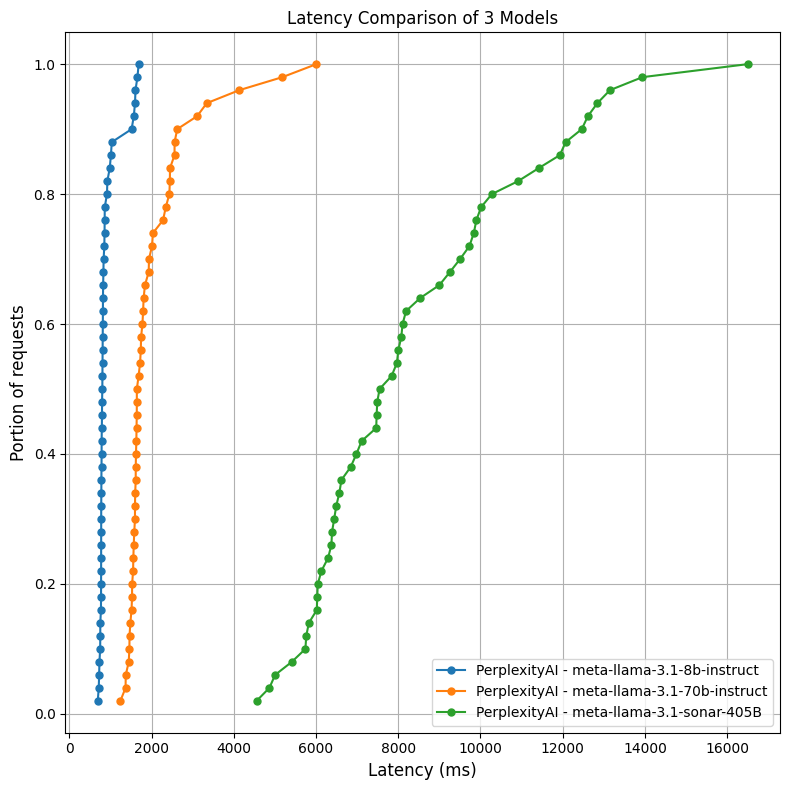

In [8]:
b.plot_metrics(b.totaltime)

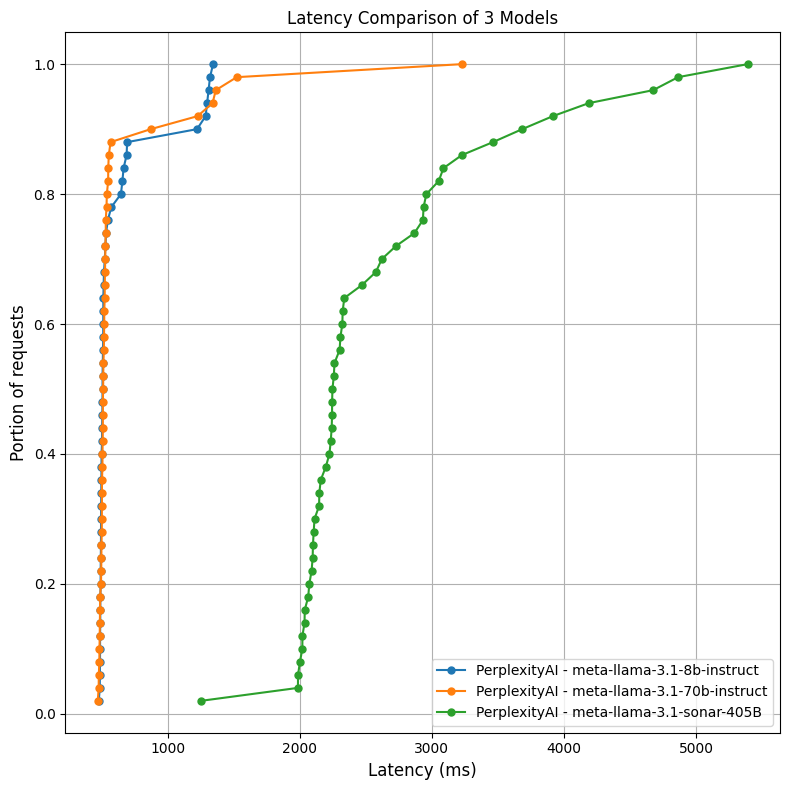

In [9]:
b.plot_metrics(b.timetofirsttoken)

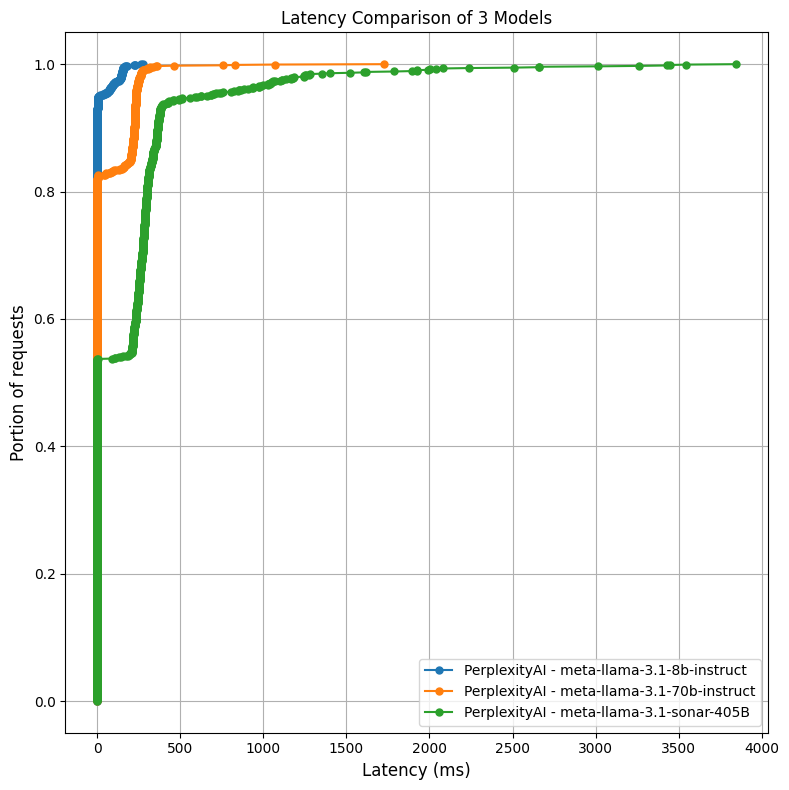

In [10]:
b.plot_metrics(b.timebetweentokens)

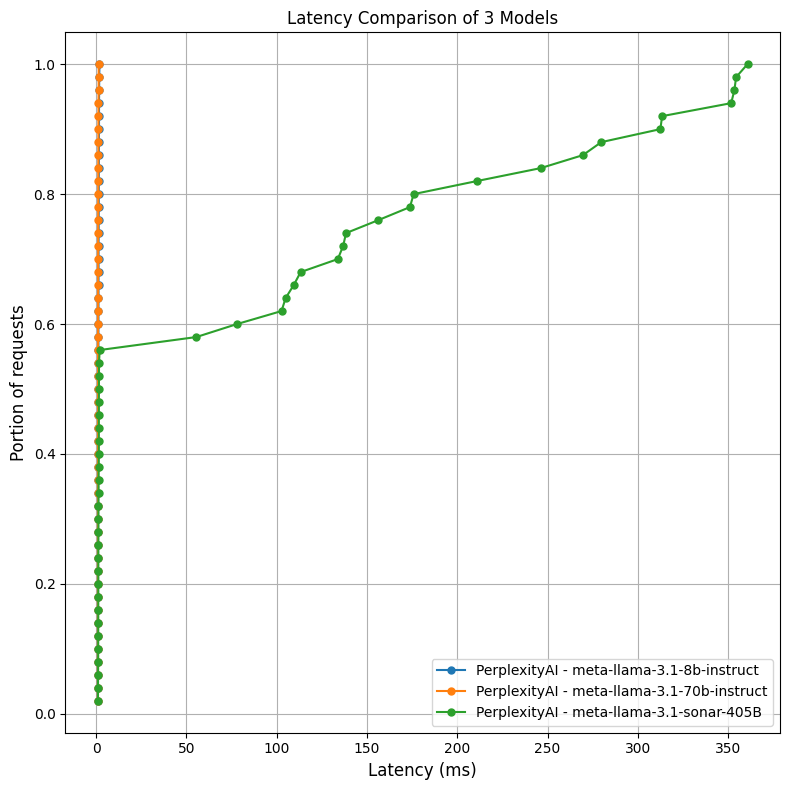

In [11]:
b.plot_metrics(b.timebetweentokens_median)

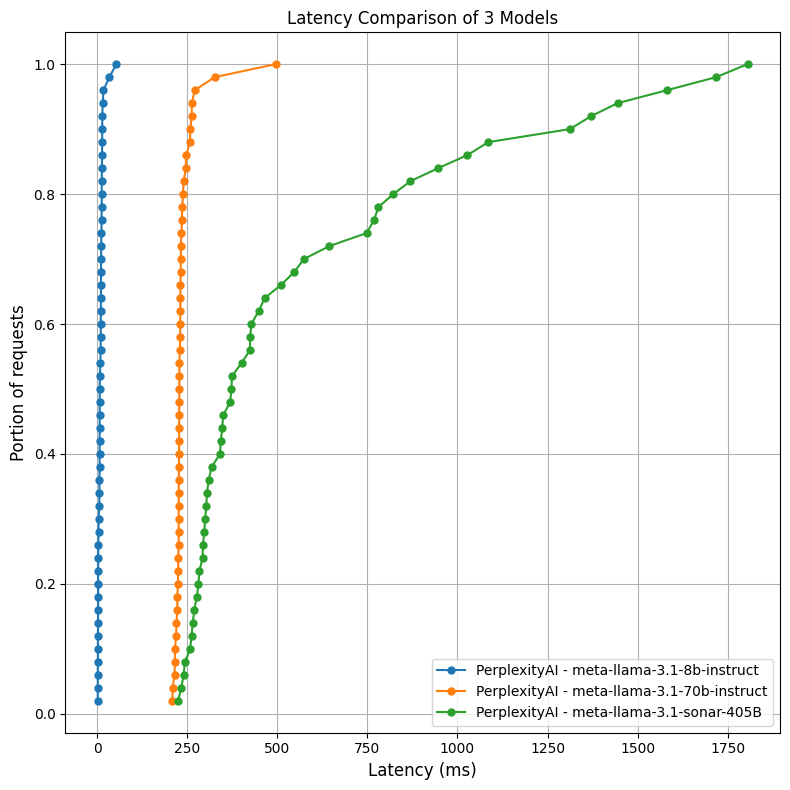

In [12]:
b.plot_metrics(b.timebetweentokens_p95)